# <center>  **Delhi the city that has difficulties to Breathe**

## 1. Installations and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns             
sns.set_theme()

In [3]:
# How many cores to use. Put -1 to use all cores.
N_JOBS = -1

# Random variable for having consistent results between runs
RANDOM_STATE = 18

In [4]:
df_states = pd.read_csv(f'archive/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

file_name           state               city  start_month_num  start_year
0     AP001  Andhra Pradesh           Tirupati                7        2016
1     AP002  Andhra Pradesh         Vijayawada                5        2017
2     AP003  Andhra Pradesh      Visakhapatnam                7        2017
3     AP004  Andhra Pradesh  Rajamahendravaram                9        2017
4     AP005  Andhra Pradesh          Amaravati               11        2017

In [5]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

We are working with a large dataset which is split in multiple files (for each city in each state), collected through different agencies. It is expected that each agency collected metrics in various formats. In addition to this, agencies started collecting data at different dates. We should check for all these notes.

First I will create a function that will return a dataframe combining all agency measurements in a given state.

In [6]:
import glob
def combine_state_df(state_name):    
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'archive/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')

    combined_df = []
    
    for state_file in state_files:
        file_name = state_file.split(f'archive/')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)
        
    return pd.concat(combined_df)

In [7]:
df = combine_state_df('Delhi')
df.info()

Combining a total of 40 files...

<class 'pandas.core.frame.DataFrame'>
Index: 2796171 entries, 0 to 20841
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  RH (%)               float64
 16  WS (m/s)             float64
 17  WD (degree)          float64
 18  BP (mmHg)            float64
 19  Xylene (ug/m3)       float64
 20  AT (degree C)        float64
 21  RF (mm)              float64
 22  city                 string 
 23  Temp 

## 2. Preprocessing

We noticed that there are two features, From Date and To Date which are both Pandas objects. These feature vectors describe a one hour window for all the metric collected at that point. Since we are dealing with time series data, it is also common to use a datetime index. I decided to keep the From Date as index and transform it from a Pandas object into the datetime format.

In [8]:
# Make the 'From Date' column the index as datetime
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [9]:
df = create_dt_index(df)
df.head(2)

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2020-11-13 14:00:00         142.70        390.00        0.57        17.92   
2020-11-13 15:00:00         130.43        326.85        1.58        17.61   

                     NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
datetime                                                               
2020-11-13 14:00:00      18.48        48.87         2.78        0.83   
2020-11-13 15:00:00      19.19        56.64         2.69        0.71   

                     Ozone (ug/m3)  Benzene (ug/m3)  ...  O Xylene (ug/m3)  \
datetime                                             ...                     
2020-11-13 14:00:00          39.24              2.4  ...               NaN   
2020-11-13 15:00:00          30.93              2.7  ...               NaN   

                     CH4 (ug/m3)  NMHC (ug/m3)  SPM (ug/m3)  THC (ug/m3)  \
datetime                                                                   
2020-11-13 14:00:00          NaN           NaN          NaN          NaN   
2020-11-13 15:00:00          NaN           NaN          NaN          NaN   

                     Gust (km/hr)  MP-Xylene ()  Eth-Benzene ()  Xylene ()  \
datetime                                                                     
2020-11-13 14:00:00           NaN           NaN             NaN        NaN   
2020-11-13 15:00:00           NaN           NaN             NaN        NaN   

                     CH4 ()  
datetime                     
2020-11-13 14:00:00     NaN  
2020-11-13 15:00:00     NaN  

[2 rows x 58 columns]


### Feature Reduction
As observed from the dataframe's info, some features appear to be similar. I will try to identify potential similarities between such features, and merge them

In [10]:
# Helper function to plot groups of data into subplots
def plot_feature_similarities(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=3.0)
    
    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        # Move to new row
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0
            
        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        axes[row_num, col_num].set(xlabel=None)
        col_num += 1

    plt.plot()

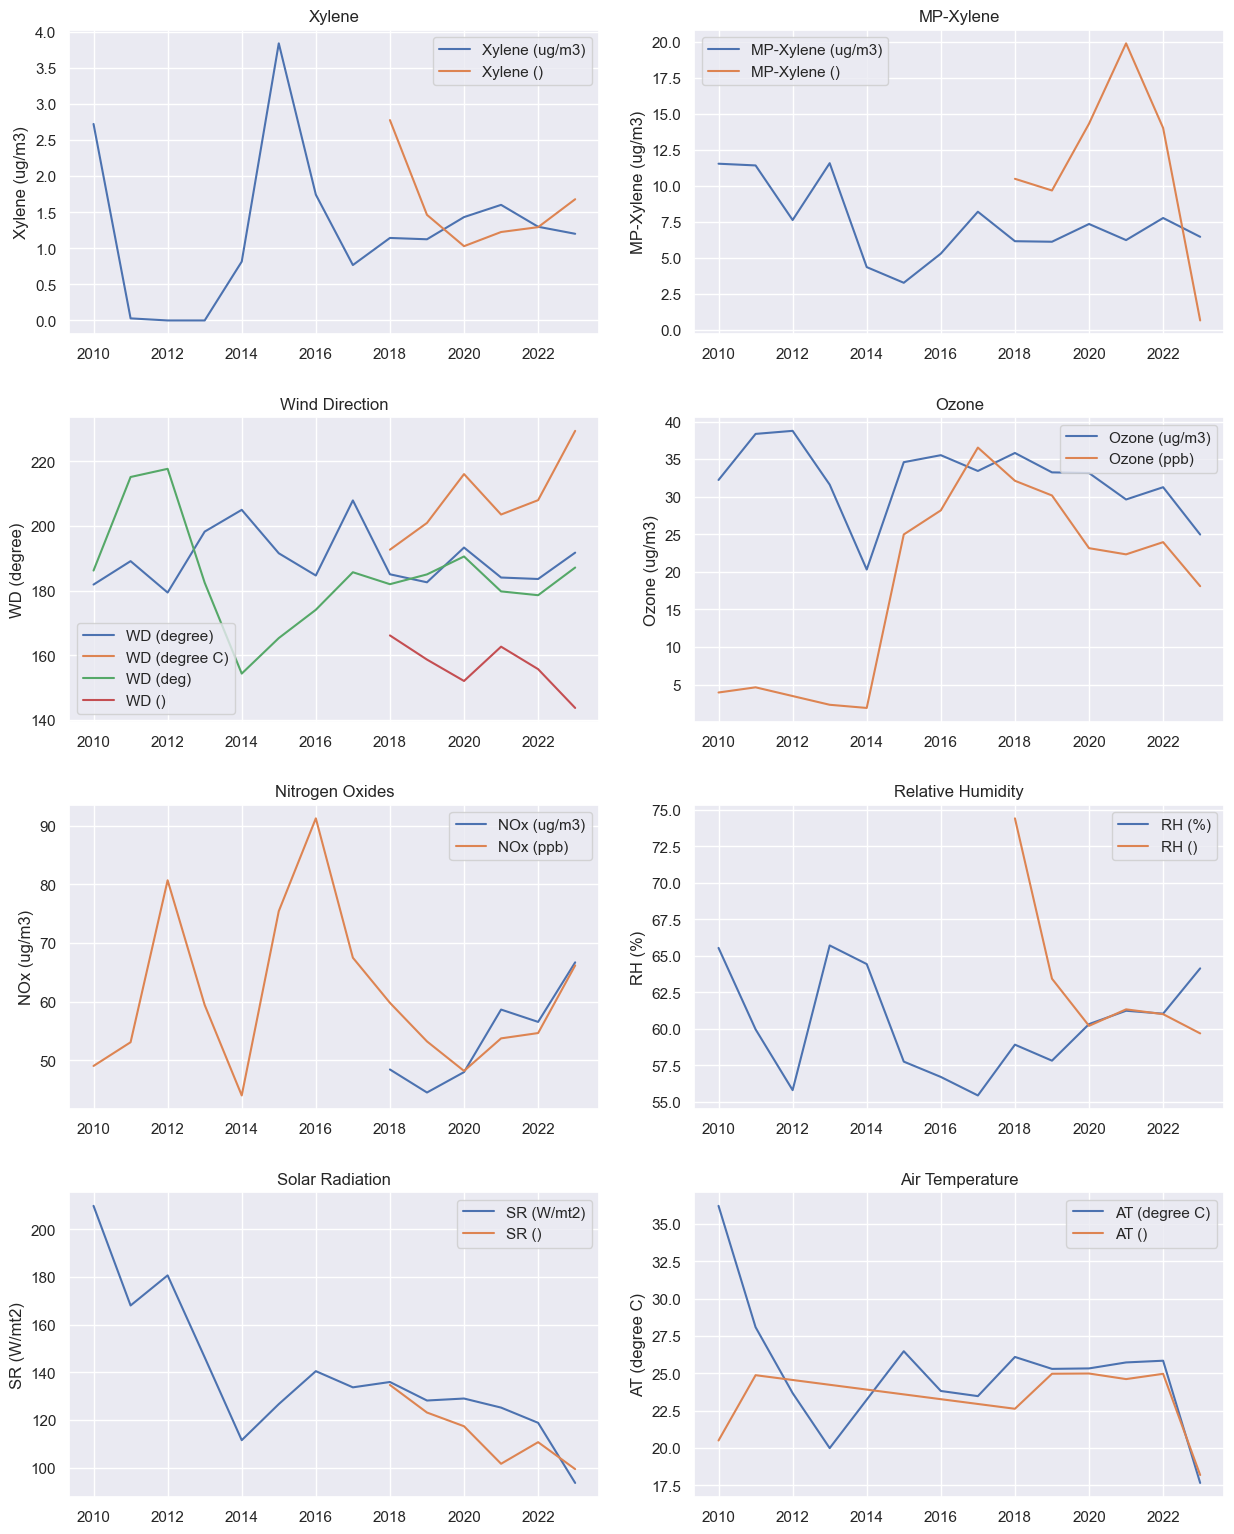

In [11]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':    ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative Humidity': ['RH (%)', 'RH ()'],
    'Solar Radiation':   ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':   ['AT (degree C)', 'AT ()']
}

plot_feature_similarities(df, groups, columns=2)

It seems like some of the features are capturing the same metric units as others. This is a good indication and we can double confirm by using the Pandas describe.

In [12]:
all_groups = [item for sublist in list(groups.values()) for item in sublist]
df[all_groups].describe().applymap(lambda x: f"{x:0.3f}")

/var/folders/j4/vfn7cfw96lb0kz5lthlkj59r0000gp/T/ipykernel_98897/975514156.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[all_groups].describe().applymap(lambda x: f"{x:0.3f}")


Xylene (ug/m3)  Xylene () MP-Xylene (ug/m3) MP-Xylene () WD (degree)  \
count     242944.000  34578.000        264768.000    29205.000  813361.000   
mean           1.337      1.319             7.040       13.824     186.417   
std            5.762      3.348            13.603       19.986      94.905   
min            0.000      0.000             0.010        0.010       0.020   
25%            0.000      0.000             1.210        2.890     104.850   
50%            0.000      0.400             2.940        7.040     187.380   
75%            1.010      1.400             7.410       15.760     268.950   
max          476.310    231.000           491.510      286.010     360.000   

      WD (degree C)    WD (deg)       WD () Ozone (ug/m3) Ozone (ppb)  \
count     43888.000  655812.000  122463.000   1874697.000   47576.000   
mean        205.871     184.905     157.480        32.370      25.864   
std          88.418      80.286      91.992        34.778      19.535   
min           1.200       0.030       1.300         0.010       0.050   
25%         119.570     121.010      86.950         8.550      13.530   
50%         230.435     185.310     147.830        19.600      20.480   
75%         285.550     252.050     229.700        43.150      33.130   
max         356.520     359.590     359.700       200.000     198.470   

      NOx (ug/m3)    NOx (ppb)       RH (%)      RH ()   SR (W/mt2)  \
count   86086.000  1876466.000  1611483.000  39722.000  1555347.000   
mean       52.076       56.894       59.893     62.812      130.106   
std        59.768       70.730       22.548     20.497      180.273   
min         0.100        0.000        0.010      0.820        0.000   
25%        17.380       16.980       43.120     46.450        5.580   
50%        31.050       31.680       61.330     63.820       29.500   
75%        61.100       64.280       78.000     80.000      216.210   
max       498.850      500.000      100.000     99.200     1995.000   

           SR () AT (degree C)      AT ()  
count  43267.000   1110834.000  83016.000  
mean     116.041        25.136     24.178  
std      172.197         8.561      8.426  
min        2.720         0.100      1.880  
25%        3.480        18.580     17.420  
50%       11.350        26.400     25.380  
75%      174.735        31.500     30.300  
max      836.420        58.900     56.270

I was able to merge the following features. The rest have too many missing values so we are going to drop them.

In [13]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [14]:
def merge_columns(dataframe, columns):
    for column, cols_to_merge in columns.items():
        # Check if the original column exist, otherwise create it
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])
            
    return dataframe

In [15]:
df = merge_columns(df, reduction_groups)

### Missing Values
One important first thing to check now is how many missing values there are for these features.

In [16]:
df.isnull().sum().sort_values(ascending=False)

NMHC (ug/m3)           2796171
Gust (kl/h)            2796171
Gust (m/s)             2796171
Variance (n)           2796171
Gust (km/hr)           2796171
SPM (ug/m3)            2796171
Temp (ug/m3)           2796171
Eth-Benzene ()         2796171
Power (W)              2796171
CO2 (mg/m3)            2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene 

Looks like we are dealing with a dataset which contains a lot of missing values. On a closer look we can observe that some of these feature columns are completely empty, so we can easily drop those columns.

In [17]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [18]:
# Helper function that returs a DataFrame containing the number of null values and percentages for each column
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percent Missing (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

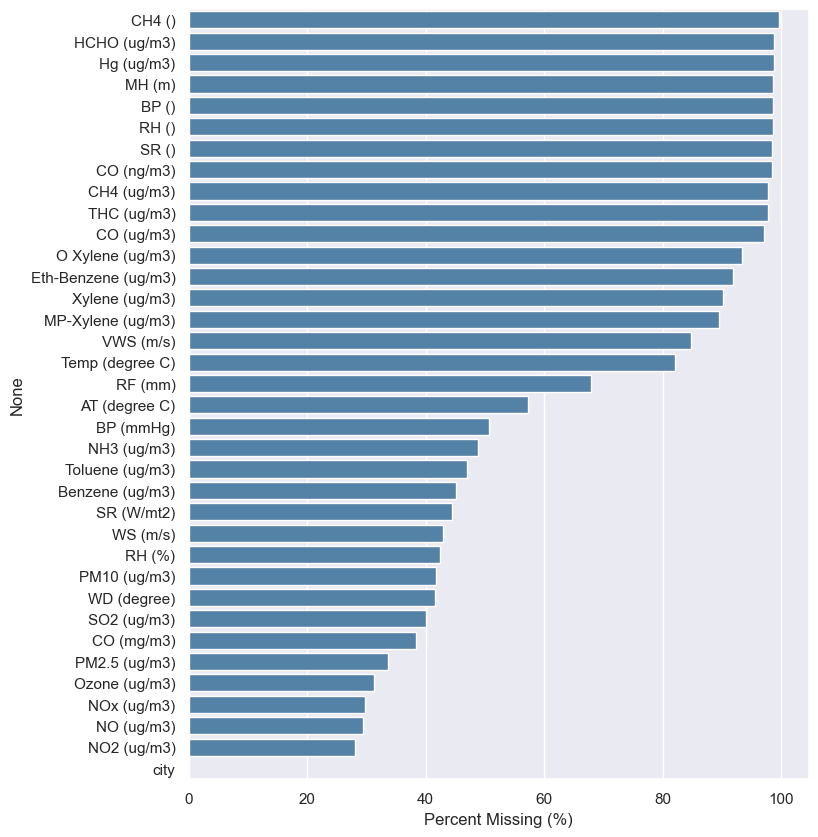

In [19]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

The barplot shows that the majority of features contain very little information.

### Dataset's Null Count Information

So far we investigated only a single state. We may get a better feeling for the missing data if we investigate the complete dataset.

In [20]:
def get_overall_ds_info():
    features = {}
    total_records = 0

    for i, state_name in enumerate(unique_states):
        
        temp_df = combine_state_df(state_name)  # Get combined state dataframe
        temp_df = create_dt_index(temp_df)      # Create datetime index
        temp_df = temp_df.dropna(how='all')     # Drop empty rows

        comparisons = get_null_info(temp_df)

        total_records += df.shape[0]

        for feature in comparisons.index:
            if feature in features:
                features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
            else:
                features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]
                
    ds_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
    ds_null_info['Percent Missing (%)'] = round(ds_null_info['Null Count'] * 100 / total_records, 2)
    ds_null_info = ds_null_info.sort_values(by=['Null Count'], ascending=False)
    return ds_null_info

Combining a total of 10 files...

Combining a total of 1 files...

Combining a total of 9 files...

Combining a total of 35 files...

Combining a total of 14 files...

Combining a total of 3 files...

Combining a total of 40 files...

Combining a total of 17 files...

Combining a total of 1 files...

Combining a total of 30 files...

Combining a total of 2 files...

Combining a total of 1 files...

Combining a total of 39 files...

Combining a total of 9 files...

Combining a total of 41 files...

Combining a total of 2 files...

Combining a total of 2 files...

Combining a total of 22 files...

Combining a total of 1 files...

Combining a total of 1 files...

Combining a total of 12 files...

Combining a total of 8 files...

Combining a total of 1 files...

Combining a total of 35 files...

Combining a total of 1 files...

Combining a total of 14 files...

Combining a total of 26 files...

Combining a total of 2 files...

Combining a total of 3 files...

Combining a total of 57 files.

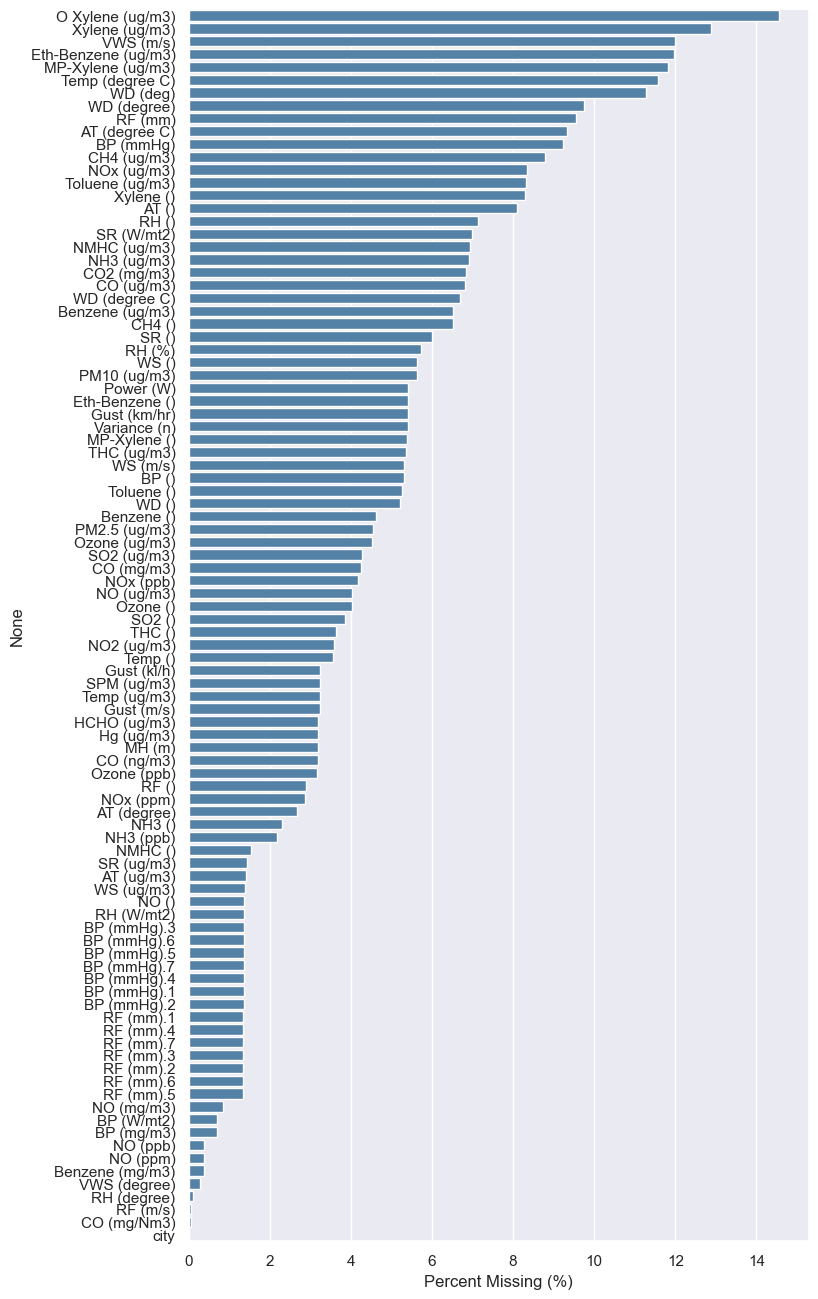

In [21]:
overall_ds_info = get_overall_ds_info()

plt.figure(figsize=(8, 16))
sns.barplot(data=overall_ds_info, x='Percent Missing (%)', y=overall_ds_info.index, orient='h', color='steelblue')
plt.show()

From these barplots, we can deduce that the various states collected different kinds and amounts of metrics. Typically with datasets like these, people tend to keep the features that contain less than 25-30% missing values, unless they contain important information.

### Drop Nulls by Threshold

Back to our capital's dataframe, we can drop the columns which contain a certain thrueshold (i.e > 40%) of missing values.

In [22]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [23]:
get_null_info(df)

Null Count  Percent Missing (%)
CO (mg/m3)        1070972                38.30
PM2.5 (ug/m3)      939895                33.61
Ozone (ug/m3)      873898                31.25
NOx (ug/m3)        833619                29.81
NO (ug/m3)         821483                29.38
NO2 (ug/m3)        783452                28.02
city                    0                 0.00

In [24]:
df

PM2.5 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  CO (mg/m3)  \
datetime                                                                  
2020-11-13 14:00:00         142.70        0.57        17.92        0.83   
2020-11-13 15:00:00         130.43        1.58        17.61        0.71   
2020-11-13 16:00:00         114.45        3.96        24.29        0.84   
2020-11-13 17:00:00         148.47       14.84        37.68        1.65   
2020-11-13 18:00:00         151.22       40.67        46.61        3.24   
...                            ...         ...          ...         ...   
2023-03-31 19:00:00          28.95         NaN        61.47         NaN   
2023-03-31 20:00:00          59.88         NaN        76.23         NaN   
2023-03-31 21:00:00         368.03         NaN        72.86         NaN   
2023-03-31 22:00:00            NaN         NaN        55.75         NaN   
2023-03-31 23:00:00          18.20         NaN        37.87         NaN   

                     Ozone (ug/m3)   city  NOx (ug/m3)  
datetime                                                
2020-11-13 14:00:00          39.24  Delhi        18.48  
2020-11-13 15:00:00          30.93  Delhi        19.19  
2020-11-13 16:00:00          26.15  Delhi        28.26  
2020-11-13 17:00:00          22.16  Delhi        52.52  
2020-11-13 18:00:00          21.95  Delhi        87.29  
...                            ...    ...          ...  
2023-03-31 19:00:00            NaN  Delhi          NaN  
2023-03-31 20:00:00            NaN  Delhi          NaN  
2023-03-31 21:00:00            NaN  Delhi          NaN  
2023-03-31 22:00:00            NaN  Delhi          NaN  
2023-03-31 23:00:00            NaN  Delhi          NaN  

[2796171 rows x 7 columns]

## 3. Current Situation Analysis

### 3.1 Data exploration

In [25]:
from scipy import signal, stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11

In [26]:
df_clean = df.dropna(how='all').reset_index(drop=False)

# Renaming columns
df_clean.columns = ['Timestamp','PM25', 'NO', 'NO2', 'CO', 'Ozone', 'city', 'NOx']

pollutants = ['PM25', 'NO', 'NO2', 'CO', 'Ozone', 'NOx']

print(f" Loaded data : {len(df_clean)} observations")
print(f" Complete data : {df_clean.dropna().shape[0]} observations")
print(f" City : {df_clean['city'].unique()[0]}")
print(f"\n Polluants : {pollutants}")

df_clean

 Loaded data : 2796171 observations
 Complete data : 1435221 observations
 City : Delhi

 Polluants : ['PM25', 'NO', 'NO2', 'CO', 'Ozone', 'NOx']


Timestamp    PM25     NO    NO2    CO  Ozone   city    NOx
0       2020-11-13 14:00:00  142.70   0.57  17.92  0.83  39.24  Delhi  18.48
1       2020-11-13 15:00:00  130.43   1.58  17.61  0.71  30.93  Delhi  19.19
2       2020-11-13 16:00:00  114.45   3.96  24.29  0.84  26.15  Delhi  28.26
3       2020-11-13 17:00:00  148.47  14.84  37.68  1.65  22.16  Delhi  52.52
4       2020-11-13 18:00:00  151.22  40.67  46.61  3.24  21.95  Delhi  87.29
...                     ...     ...    ...    ...   ...    ...    ...    ...
2796166 2023-03-31 19:00:00   28.95    NaN  61.47   NaN    NaN  Delhi    NaN
2796167 2023-03-31 20:00:00   59.88    NaN  76.23   NaN    NaN  Delhi    NaN
2796168 2023-03-31 21:00:00  368.03    NaN  72.86   NaN    NaN  Delhi    NaN
2796169 2023-03-31 22:00:00     NaN    NaN  55.75   NaN    NaN  Delhi    NaN
2796170 2023-03-31 23:00:00   18.20    NaN  37.87   NaN    NaN  Delhi    NaN

[2796171 rows x 8 columns]

In [27]:
# Stats
print("Stats Overview")
print("="*60)
df_clean[pollutants].describe().round(2)

Stats Overview


PM25          NO         NO2          CO       Ozone         NOx
count  1856276.00  1974688.00  2012719.00  1725199.00  1922273.00  1962552.00
mean       110.10       33.97       43.40        1.68       32.21       56.68
std        103.16       63.23       40.05        2.60       34.50       70.29
min          0.01        0.01        0.01        0.00        0.01        0.00
25%         41.25        4.12       17.43        0.67        8.67       17.00
50%         77.50        9.91       31.40        1.10       19.64       31.65
75%        145.12       31.12       56.70        1.80       42.73       64.13
max       1000.00      500.00      499.97       50.00      200.00      500.00

In [28]:
# Outliers
print("Detected Outliers")
print("="*60)

for pol in pollutants:
    if pol in df_clean.columns:
        max_val = df_clean[pol].max()
        max_date = df_clean[df_clean[pol] == max_val]['Timestamp'].values[0] if not pd.isna(max_val) else 'N/A'
        print(f"{pol:<10} Max: {max_val:>8.2f} le {max_date}")

Detected Outliers
PM25       Max:  1000.00 le 2020-11-09T23:00:00.000000000
NO         Max:   500.00 le 2022-03-29T23:00:00.000000000
NO2        Max:   499.97 le 2015-12-07T17:00:00.000000000
CO         Max:    50.00 le 2010-12-20T02:00:00.000000000
Ozone      Max:   200.00 le 2020-05-15T14:00:00.000000000
NOx        Max:   500.00 le 2021-02-23T22:00:00.000000000


### 3.2 Visualization of the Time Series

In [29]:
df_plot = df_clean.set_index('Timestamp')
df_daily = df_plot[pollutants].resample('D').mean()


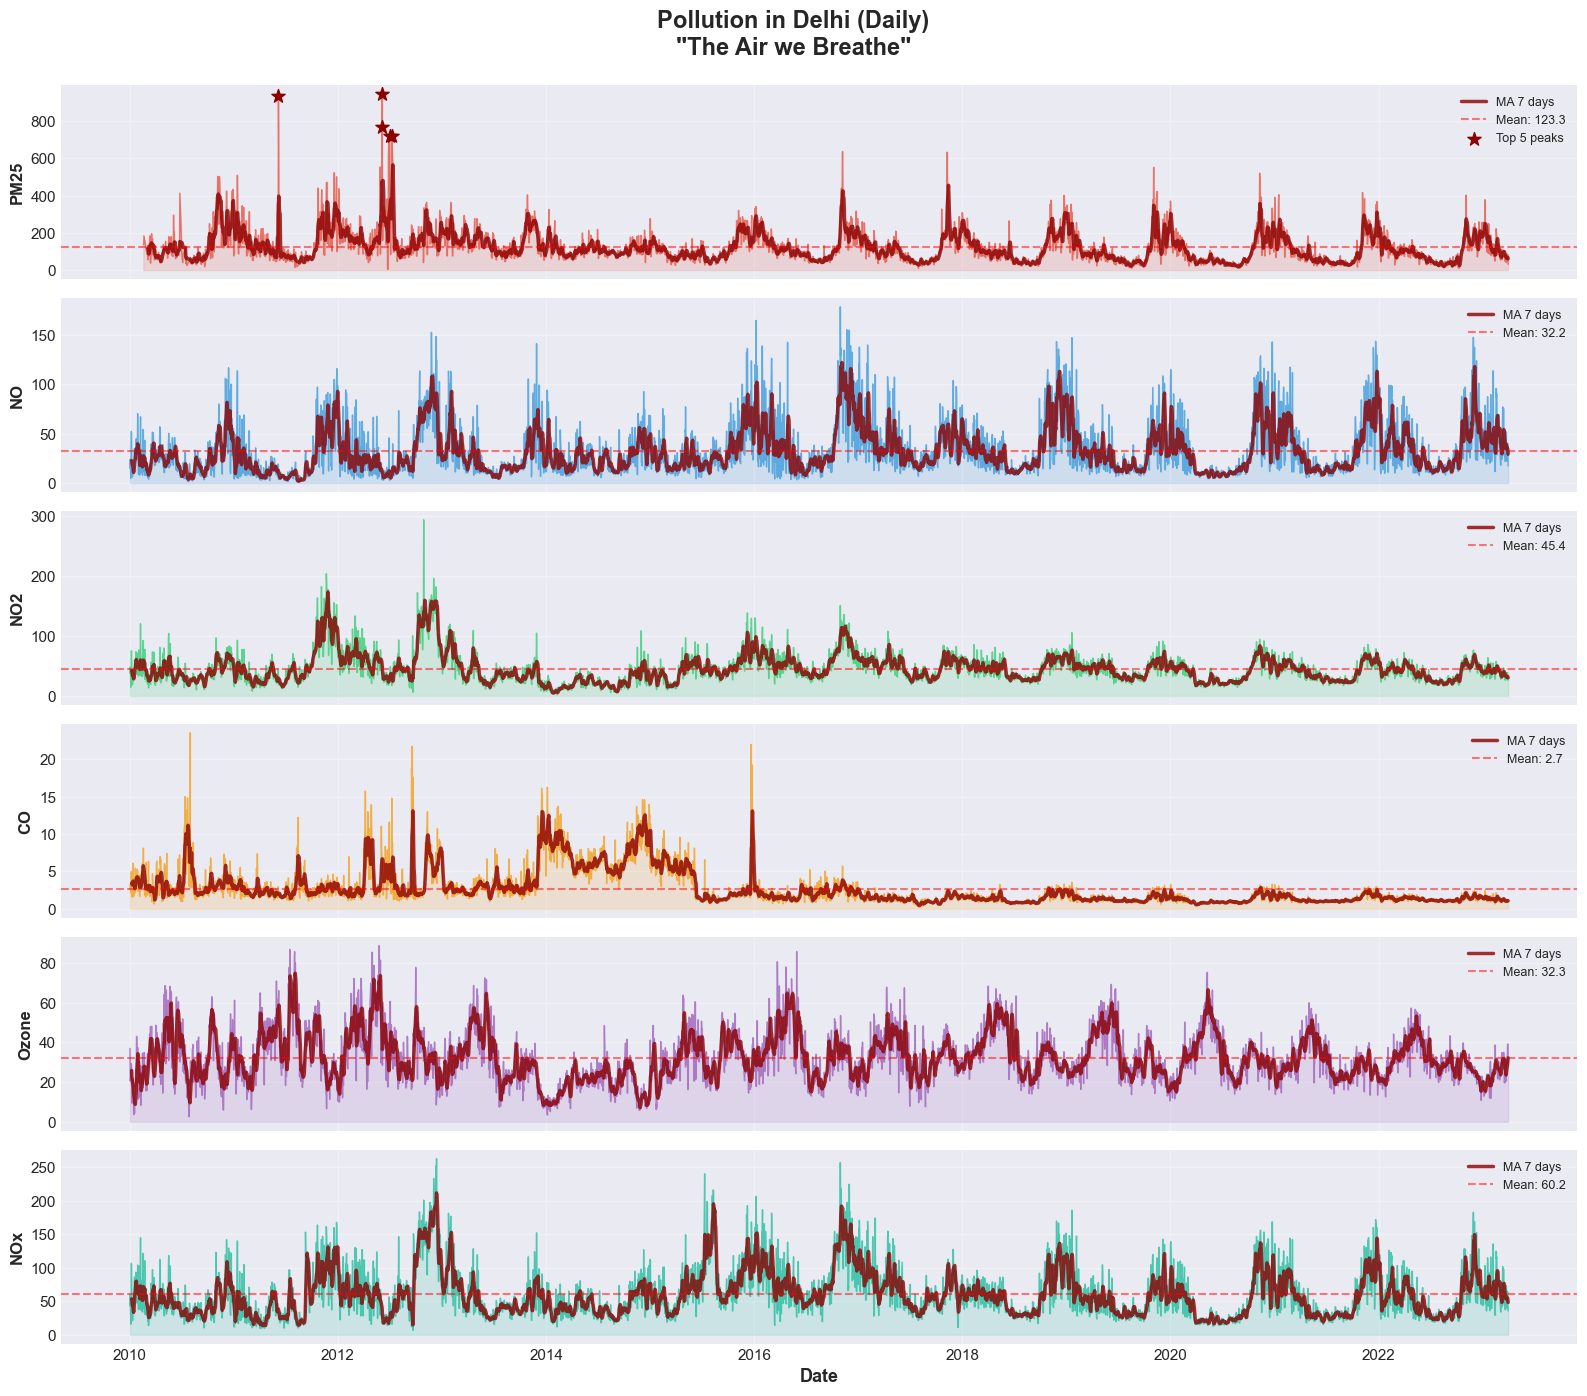

In [30]:
fig, axes = plt.subplots(6, 1, figsize=(16, 14), sharex=True)

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, (pollutant, color) in enumerate(zip(pollutants, colors)):
    if pollutant not in df_daily.columns:
        continue
        
    data = df_daily[pollutant].dropna()
    
    # Time series
    axes[idx].plot(data.index, data.values, linewidth=1, color=color, alpha=0.7)
    axes[idx].fill_between(data.index, data.values, alpha=0.15, color=color)
    
    # Moving Average (7 days)
    rolling_mean = data.rolling(window=7).mean()
    axes[idx].plot(rolling_mean.index, rolling_mean.values, 
                  linewidth=2.5, color='darkred', alpha=0.8, 
                  label='MA 7 days')
    
    # Moyenne globale
    mean_val = data.mean()
    axes[idx].axhline(y=mean_val, color='red', linestyle='--', 
                      linewidth=1.5, alpha=0.5, label=f'Mean: {mean_val:.1f}')
    
    axes[idx].set_ylabel(pollutant, fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    
    # Peaks for PM2.5
    if pollutant == 'PM25':
        top_values = data.nlargest(5)
        axes[idx].scatter(top_values.index, top_values.values, 
                        color='darkred', s=100, zorder=5, 
                        label='Top 5 peaks', marker='*')
        axes[idx].legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel('Date', fontsize=13, fontweight='bold')
plt.suptitle('Pollution in Delhi (Daily)\n"The Air we Breathe"', 
             fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

#### Observations Initiales

À ce stade, notez :
- Présence de **pics extrêmes** (surtout PM2.5)
- **Variabilité élevée** au fil du temps
- Possibles **patterns saisonniers**
- **Tendance générale** visible avec la moyenne mobile

### 3.3 Comparaison with International Norms

In [31]:
WHO_STANDARDS = {
    'PM25': 15,      # μg/m³ (moyenne annuelle OMS, mais on compare avec journalier)
    'NO2': 25,       # μg/m³ (moyenne journalière)
    'Ozone': 100,    # μg/m³ (moyenne sur 8h)
    'CO': 4.0        # mg/m³ (moyenne journalière)
}
print(" Used WHO norms :")
for pol, limit in WHO_STANDARDS.items():
    print(f"   {pol:<10} : {limit} μg/m³" if pol != 'CO' else f"   {pol:<10} : {limit} mg/m³")

 Used WHO norms :
   PM25       : 15 μg/m³
   NO2        : 25 μg/m³
   Ozone      : 100 μg/m³
   CO         : 4.0 mg/m³


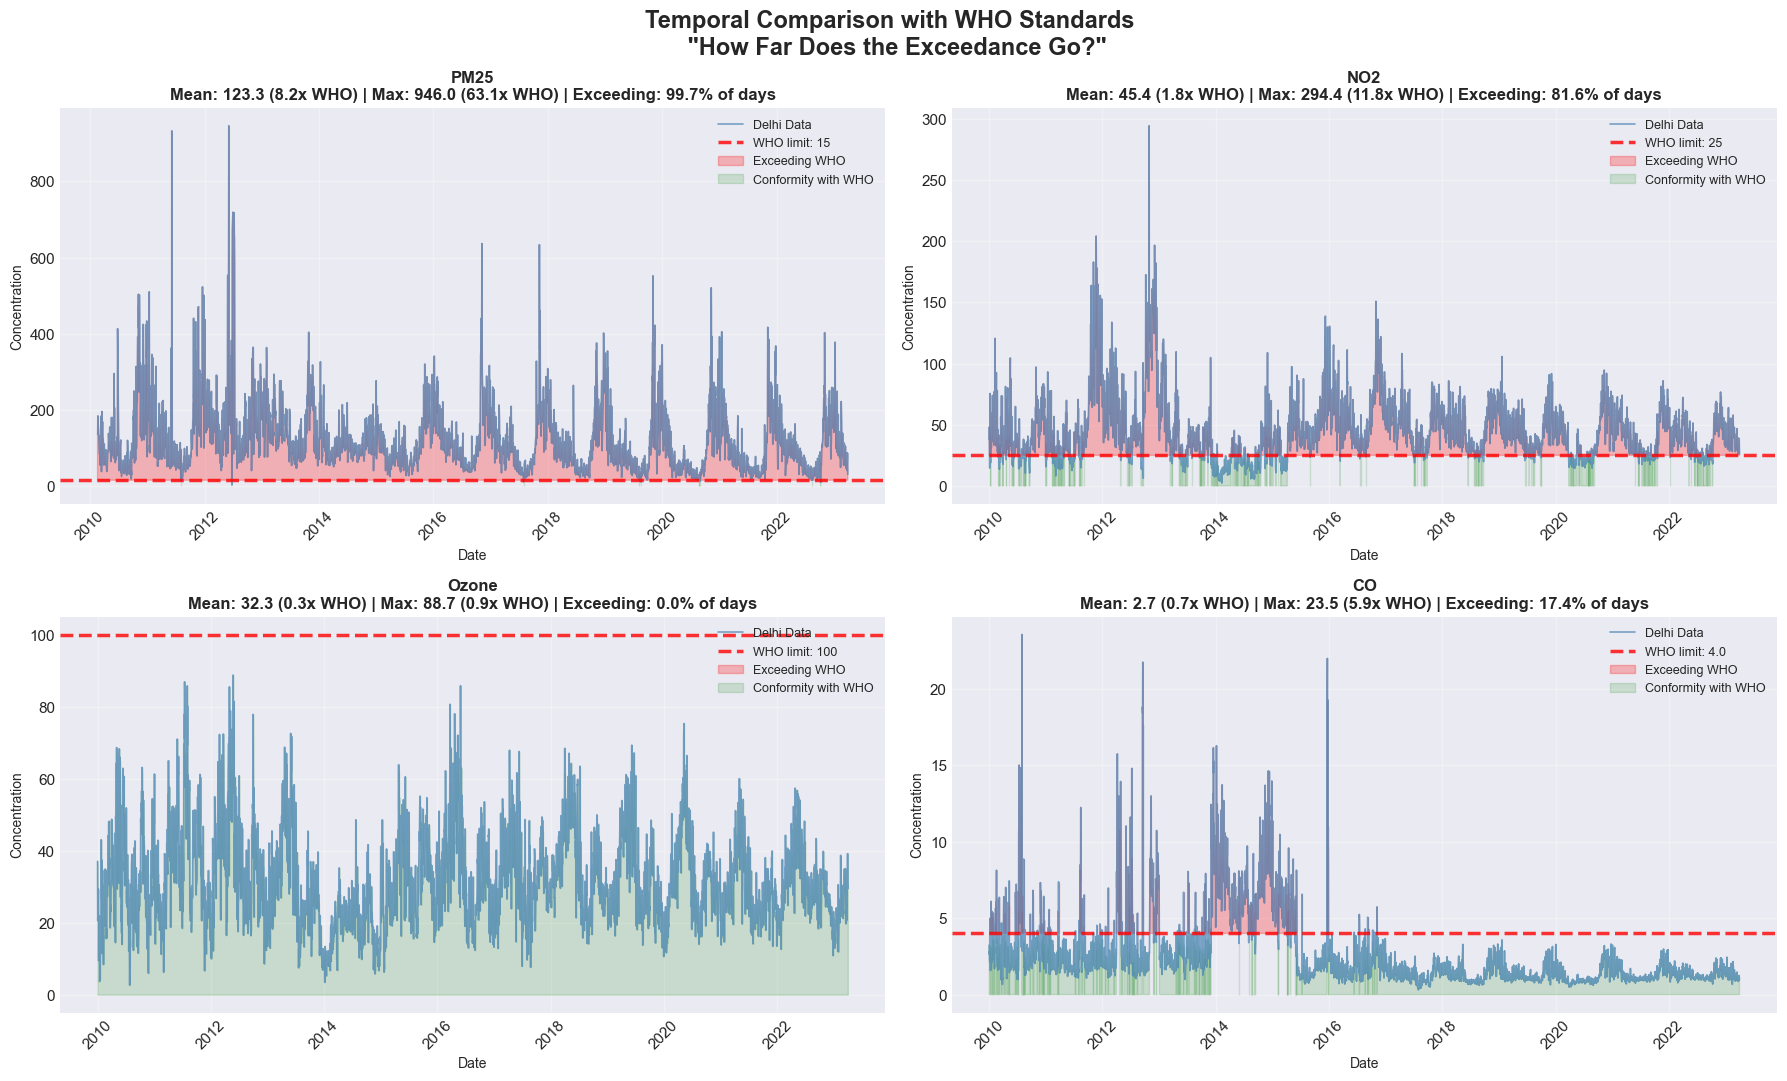

In [32]:
# Temporal Comparaison with WHO norms
fig, axes = plt.subplots(2, 2, figsize=(18, 11))
axes = axes.flatten()

pollutants_who = ['PM25', 'NO2', 'Ozone', 'CO']

for idx, pol in enumerate(pollutants_who):
    if pol not in df_daily.columns:
        continue
        
    data = df_daily[pol].dropna()
    
    # Time series
    axes[idx].plot(data.index, data.values, linewidth=1.2, alpha=0.7, 
                  label='Delhi Data', color='steelblue')
    
    # Norme OMS
    who_limit = WHO_STANDARDS[pol]
    axes[idx].axhline(y=who_limit, color='red', linestyle='--', 
                     linewidth=2.5, label=f'WHO limit: {who_limit}', alpha=0.8)
    
    # Zone de dépassement
    axes[idx].fill_between(data.index, who_limit, data.values, 
                          where=(data.values > who_limit), 
                          color='red', alpha=0.25, label='Exceeding WHO')
    
    # Zone conforme
    axes[idx].fill_between(data.index, 0, data.values, 
                          where=(data.values <= who_limit), 
                          color='green', alpha=0.15, label='Conformity with WHO')
    
    # Statistiques
    pct_exceeding = 100 * (data > who_limit).sum() / len(data)
    avg_val = data.mean()
    ratio = avg_val / who_limit
    max_val = data.max()
    ratio2 = max_val / who_limit
    axes[idx].set_title(
        f'{pol}\n'
        f'Mean: {avg_val:.1f} ({ratio:.1f}x WHO) | '
        f'Max: {max_val:.1f} ({ratio2:.1f}x WHO) | '
        f'Exceeding: {pct_exceeding:.1f}% of days', 
        fontsize=12, fontweight='bold'
    )
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Concentration', fontsize=10)
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Temporal Comparison with WHO Standards \n \"How Far Does the Exceedance Go?\"', 
             fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.4 Seasonal Analysis and Annual Patterns


In [33]:
df_season = df_plot.copy()
df_season['Month'] = df_season.index.month
df_season['Year'] = df_season.index.year
df_season['Season'] = df_season['Month'].apply(lambda x: 
    'Winter' if x in [12, 1, 2] else
    'Spring' if x in [3, 4, 5] else
    'Summer' if x in [6, 7, 8] else 'Autumn'
)

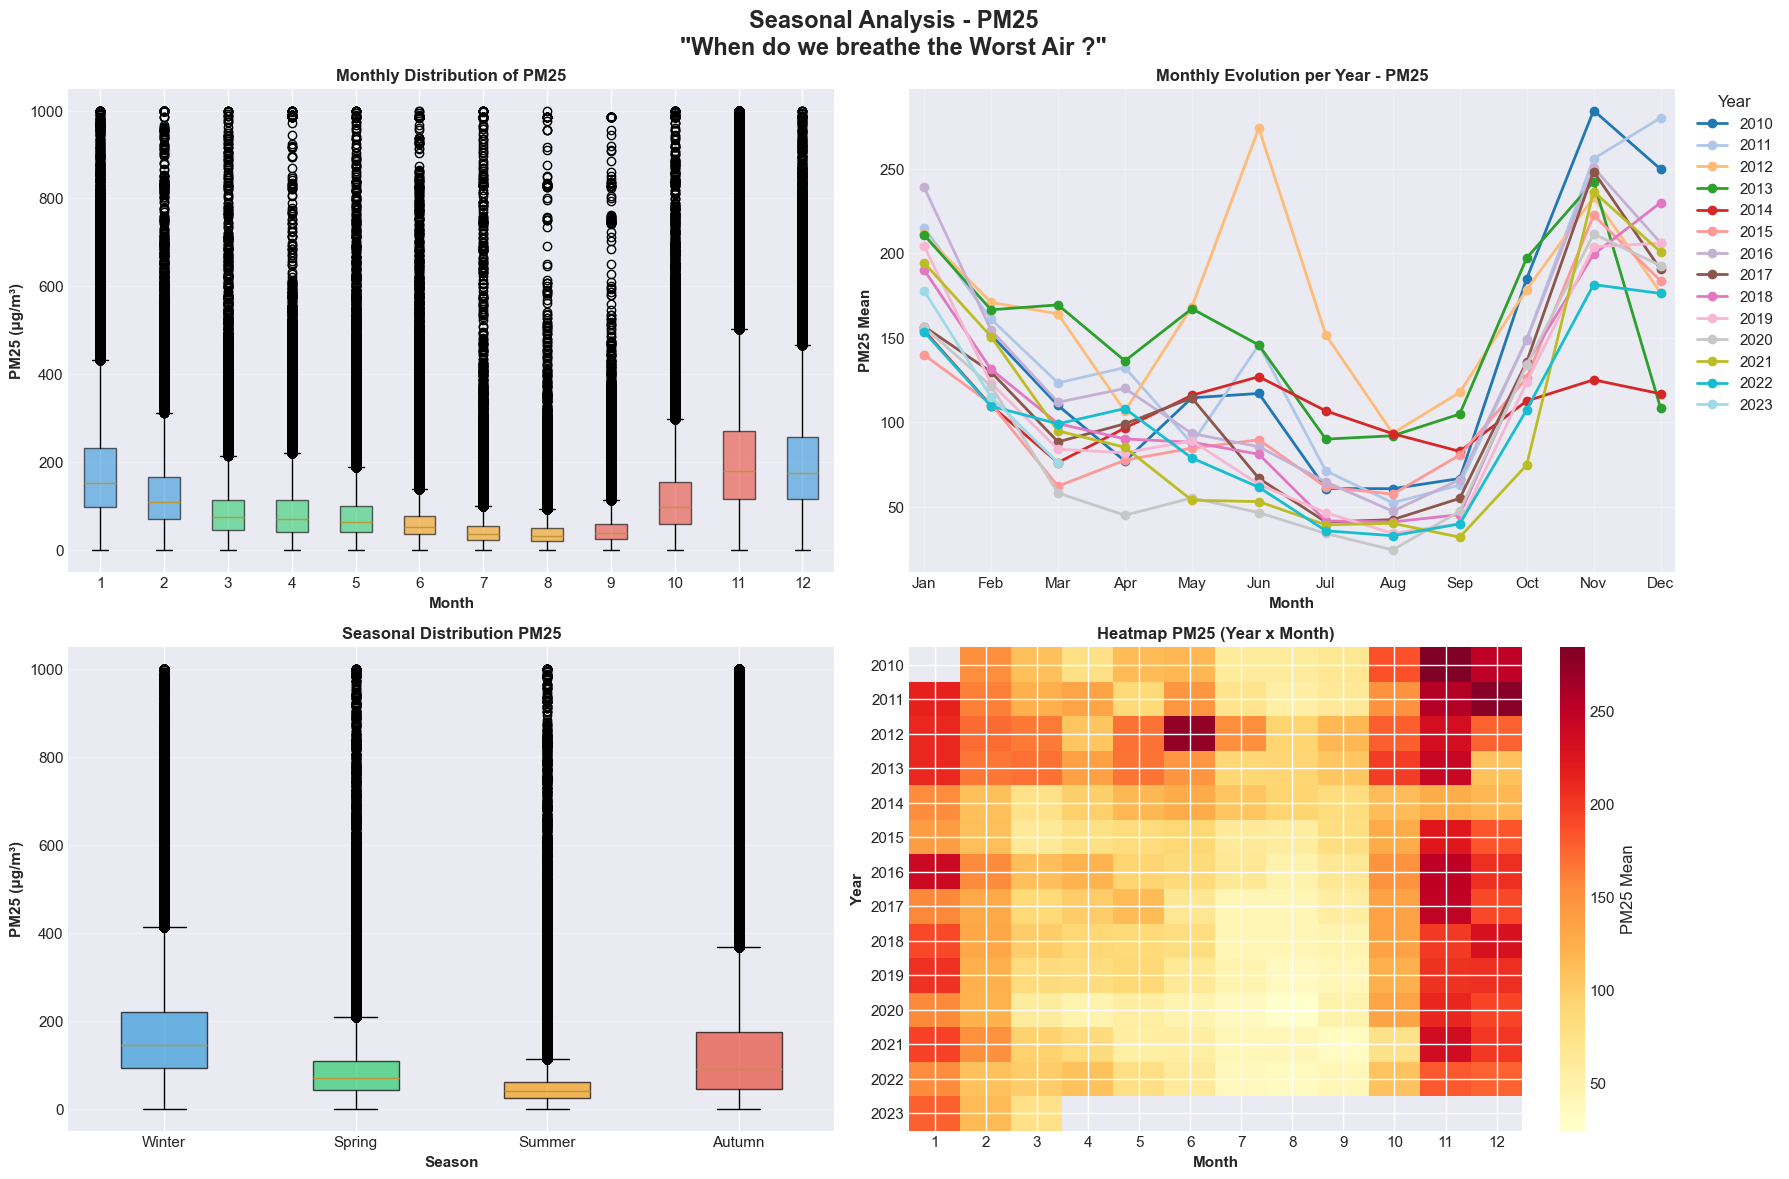

In [34]:
# Seasonal Analysis for PM25
pollutant = 'PM25'

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Couleurs par saison
season_colors = {
    'Winter': '#3498db',
    'Spring': '#2ecc71', 
    'Summer': '#f39c12',
    'Autumn': '#e74c3c'
}

month_to_season = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
    5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'
}

# 1. Boxplot par mois
monthly_data = [df_season[df_season['Month'] == m][pollutant].dropna().values 
                for m in range(1, 13)]
bp = axes[0, 0].boxplot(monthly_data, labels=range(1, 13), patch_artist=True)

for patch, month in zip(bp['boxes'], range(1, 13)):
    season = month_to_season[month]
    patch.set_facecolor(season_colors[season])
    patch.set_alpha(0.6)

axes[0, 0].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel(f'{pollutant} (μg/m³)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Monthly Distribution of {pollutant}', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Moyenne mensuelle par année
monthly_avg = (
    df_season.groupby(['Year', 'Month'])[pollutant]
    .mean()
    .unstack('Year')
    .sort_index(axis=1)         
    .reindex(range(1, 13), fill_value=np.nan) 
)

import calendar
import matplotlib.cm as cm
from matplotlib import cycler

years = monthly_avg.columns.to_list()
n = len(years)

cmap = cm.get_cmap('tab20', n) if n <= 20 else cm.get_cmap('nipy_spectral', n)
colors = [cmap(i) for i in range(n)]

axes[0, 1].set_prop_cycle(cycler(color=colors))

for y, c in zip(years, colors):
    axes[0, 1].plot(
        monthly_avg.index,
        monthly_avg[y],
        marker='o', linewidth=2, label=str(y)
    )

axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(calendar.month_abbr[1:])

axes[0, 1].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel(f'{pollutant} Mean', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Monthly Evolution per Year - {pollutant}', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].margins(x=0.02, y=0.05)

axes[0, 1].legend(
    title='Year',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.,
    frameon=False
)

# 3. Boxplot par saison
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_data = [df_season[df_season['Season'] == s][pollutant].dropna().values 
                 for s in season_order]
bp2 = axes[1, 0].boxplot(seasonal_data, labels=season_order, patch_artist=True)

for patch, season in zip(bp2['boxes'], season_order):
    patch.set_facecolor(season_colors[season])
    patch.set_alpha(0.7)

axes[1, 0].set_xlabel('Season', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel(f'{pollutant} (μg/m³)', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'Seasonal Distribution {pollutant}', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Heatmap année x mois
pivot_table = df_season.groupby(['Year', 'Month'])[pollutant].mean().unstack(level=1)
im = axes[1, 1].imshow(pivot_table.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
axes[1, 1].set_xticks(range(12))
axes[1, 1].set_xticklabels(range(1, 13))
axes[1, 1].set_yticks(range(len(pivot_table)))
axes[1, 1].set_yticklabels(pivot_table.index)
axes[1, 1].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Year', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Heatmap {pollutant} (Year x Month)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1, 1], label=f'{pollutant} Mean')

plt.suptitle(f'Seasonal Analysis - {pollutant}\n"When do we breathe the Worst Air ?"', 
             fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

In [35]:
# Seasonal Stats
print(f"\nSeasonal Stats - {pollutant}")
print("="*80)

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    season_data = df_season[df_season['Season'] == season][pollutant].dropna()
    print(f"\n{season} :")
    print(f"   Mean: {season_data.mean():.2f}")
    print(f"   Median: {season_data.median():.2f}")
    print(f"   Min-Max: {season_data.min():.2f} - {season_data.max():.2f}")
    print(f"   Standard deviation: {season_data.std():.2f}")


Seasonal Stats - PM25

Winter :
   Mean: 169.34
   Median: 144.25
   Min-Max: 0.02 - 1000.00
   Standard deviation: 109.94

Spring :
   Mean: 84.96
   Median: 69.50
   Min-Max: 0.03 - 1000.00
   Standard deviation: 65.44

Summer :
   Mean: 49.38
   Median: 39.75
   Min-Max: 0.01 - 1000.00
   Standard deviation: 49.71

Autumn :
   Mean: 128.87
   Median: 90.56
   Min-Max: 0.02 - 1000.00
   Standard deviation: 122.06


### 3.5 Polluants Distribution

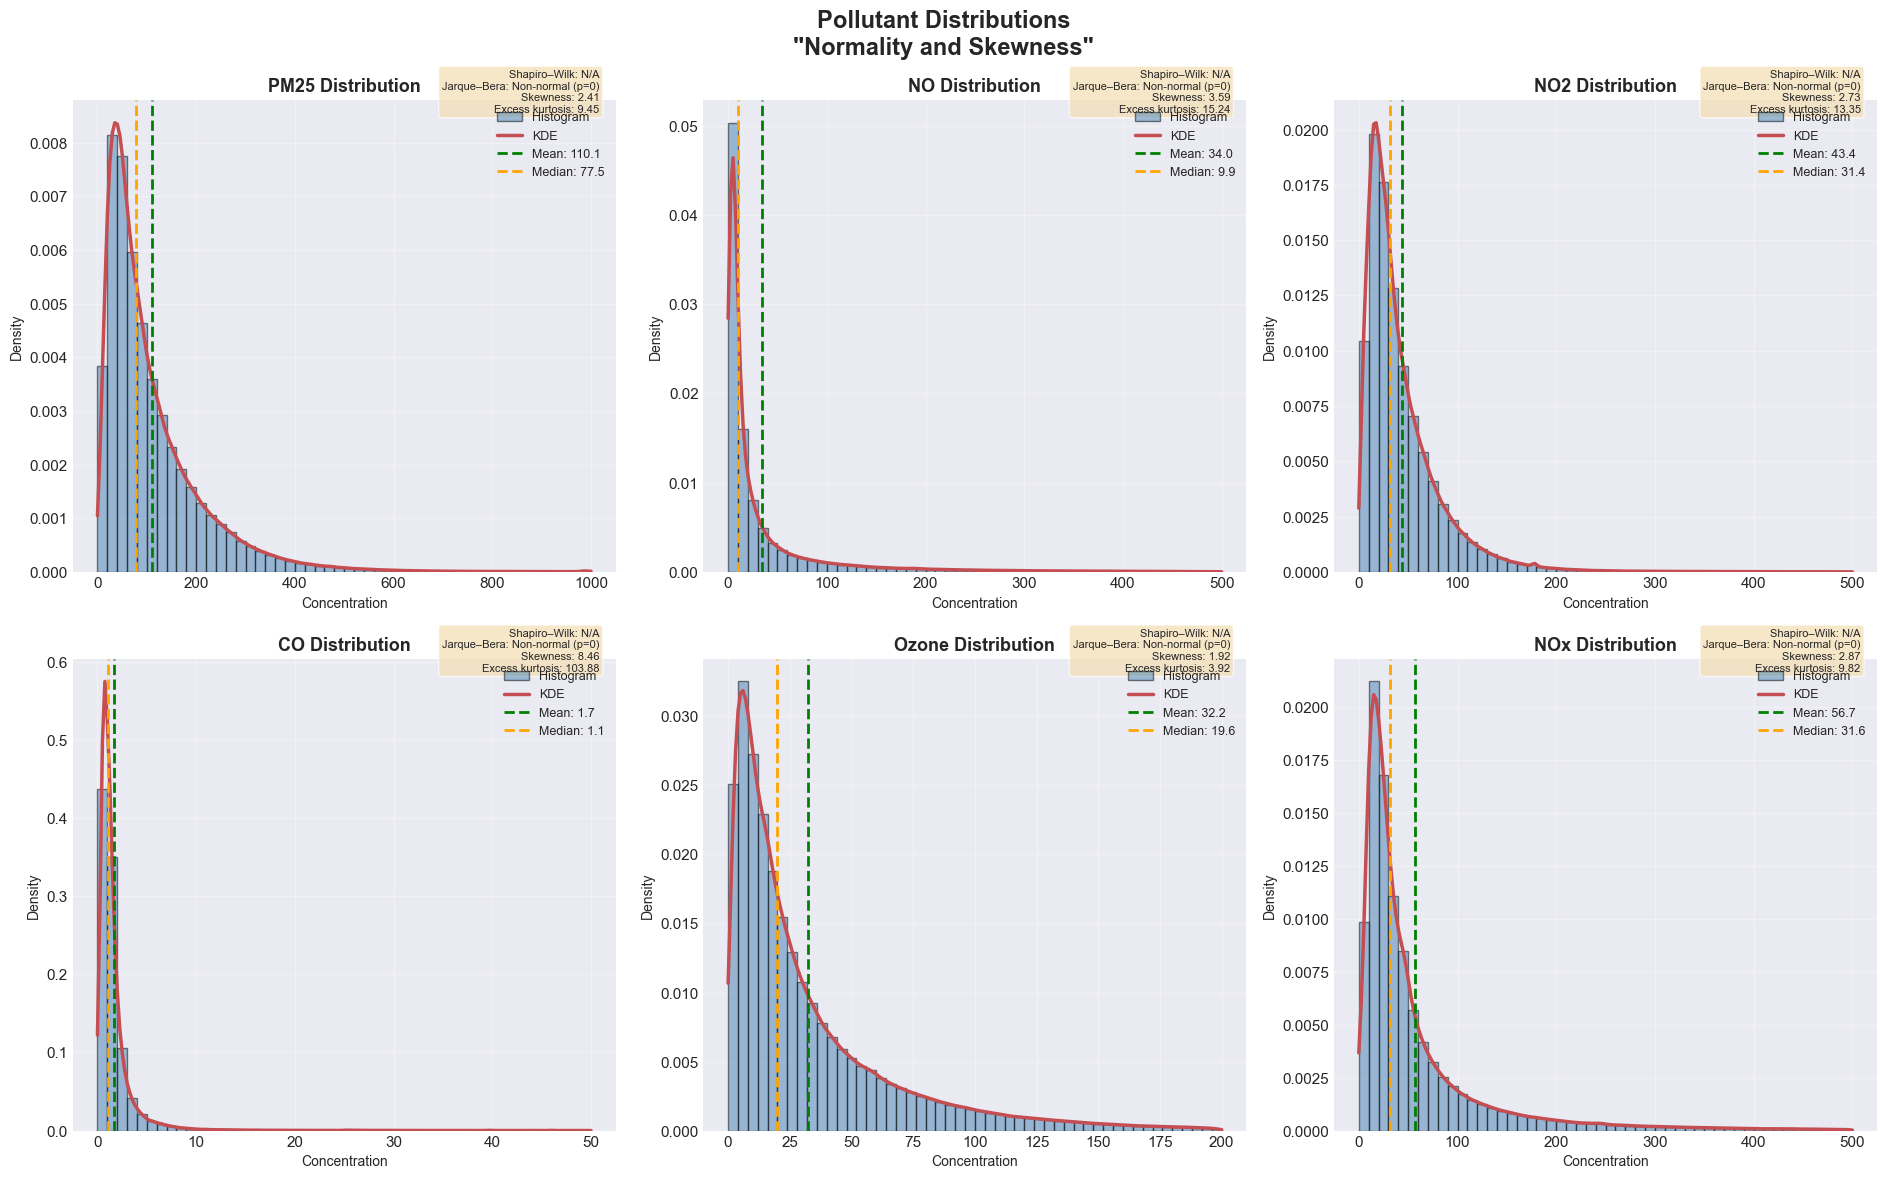

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(19, 12))
axes = axes.flatten()

alpha = 0.05  # significance level for normality tests

for idx, pol in enumerate(pollutants):
    if idx >= len(axes):
        break  # avoid indexing beyond available axes

    if pol not in df_clean.columns:
        axes[idx].set_visible(False)
        continue

    data = df_clean[pol].dropna()
    if data.empty:
        axes[idx].set_title(f'No data for {pol}', fontsize=13, fontweight='bold')
        axes[idx].set_axis_off()
        continue

    # Histogram + KDE
    axes[idx].hist(
        data, bins=50, alpha=0.5, color='steelblue',
        edgecolor='black', density=True, label='Histogram'
    )

    # KDE (skip if variance is ~0 to avoid singular covariance)
    if len(data) > 1 and np.nanstd(data) > 0:
        try:
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 200)
            axes[idx].plot(x_range, kde(x_range), 'r-', linewidth=2.5, label='KDE')
        except Exception:
            pass  # fall back to histogram-only if KDE fails

    # Summary statistics
    mean_val = data.mean()
    median_val = data.median()
    axes[idx].axvline(mean_val, color='green', linestyle='--',
                      linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='orange', linestyle='--',
                      linewidth=2, label=f'Median: {median_val:.1f}')

    axes[idx].set_title(f'{pol} Distribution', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Concentration', fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

    # Normality tests
    if len(data) > 3:
        # Shapiro–Wilk (subsample up to 5000 to control cost)
        if len(data) <= 5000:
            sample = data.values
        else:
            sample = np.random.default_rng().choice(data.values, size=5000, replace=False)

        shapiro_txt = 'N/A'
        try:
            stat_shapiro, p_shapiro = shapiro(sample)
            shapiro_txt = f"{'Normal' if p_shapiro > alpha else 'Non-normal'} (p={p_shapiro:.3g})"
        except Exception:
            pass

        # Jarque–Bera (skewness & kurtosis)
        jb_txt = 'N/A'
        try:
            stat_jb, p_jb = stats.jarque_bera(data)  # <-- fixed: use stats.jarque_bera
            jb_txt = f"{'Normal' if p_jb > alpha else 'Non-normal'} (p={p_jb:.3g})"
        except Exception:
            pass

        # Skewness & kurtosis (excess kurtosis)
        skewness = stats.skew(data, bias=False)
        kurtosis_val = stats.kurtosis(data, bias=False)  # excess kurtosis (0.0 for normal)

        info = (
            f'Shapiro–Wilk: {shapiro_txt}\n'
            f'Jarque–Bera: {jb_txt}\n'
            f'Skewness: {skewness:.2f}\n'
            f'Excess kurtosis: {kurtosis_val:.2f}'
        )
        axes[idx].text(
            0.97, 0.97, info,
            transform=axes[idx].transAxes,
            va='bottom', ha='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
            fontsize=8
        )

    # Legend (deduplicate)
    handles, labels = axes[idx].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[idx].legend(by_label.values(), by_label.keys(), fontsize=9, loc='upper right')

fig.suptitle('Pollutant Distributions\n"Normality and Skewness"',
             fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()


## 4. Hidden Patterns

In [37]:
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

# Détection de ruptures
import ruptures as rpt

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 11

### 4.1  STL Decomposition

**Formula** : $Y_t = T_t + S_t + R_t$ (modèle additif)

In [38]:
def stl_decomposition(series, period=7, seasonal=13, name='Series'):
   
    clean_series = series.dropna()
    
    if len(clean_series) < 2 * period:
        print(f"  Series too short for the period {period}")
        return None
    
    # Interpolate NaNs
    if clean_series.isnull().any():
        clean_series = clean_series.interpolate(method='linear')
    
    # STL
    stl = STL(clean_series, period=period, seasonal=seasonal)
    result = stl.fit()
    
    # Visualization
    fig = result.plot()
    fig.set_size_inches(16, 10)
    fig.suptitle(f'STL Decomposition - {name}\n"Separating Signal, Trend and Noise"', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Component analysis
    var_observed = np.var(result.observed)
    var_trend = np.var(result.trend)
    var_seasonal = np.var(result.seasonal)
    var_resid = np.var(result.resid)
    
    print(f"\n COMPONENT ANALYSIS - {name}")
    print("="*70)
    print(f"Observed variance:    {var_observed:>10.2f} (100.0%)")
    print(f"Trend variance:       {var_trend:>10.2f} ({100*var_trend/var_observed:>5.1f}%)")
    print(f"Seasonal variance:    {var_seasonal:>10.2f} ({100*var_seasonal/var_observed:>5.1f}%)")
    print(f"Residual variance:    {var_resid:>10.2f} ({100*var_resid/var_observed:>5.1f}%)")
    
    # Component strength
    strength_trend = max(0, 1 - (var_resid / (var_trend + var_resid)))
    strength_seasonal = max(0, 1 - (var_resid / (var_seasonal + var_resid)))
    
    print(f"\nTrend strength:       {strength_trend:.3f}")
    print(f"Seasonality strength: {strength_seasonal:.3f}")
    
    if strength_trend > 0.6:
        print("Strong trend detected")
    if strength_seasonal > 0.4:
        print("Significant seasonality detected")
    return result


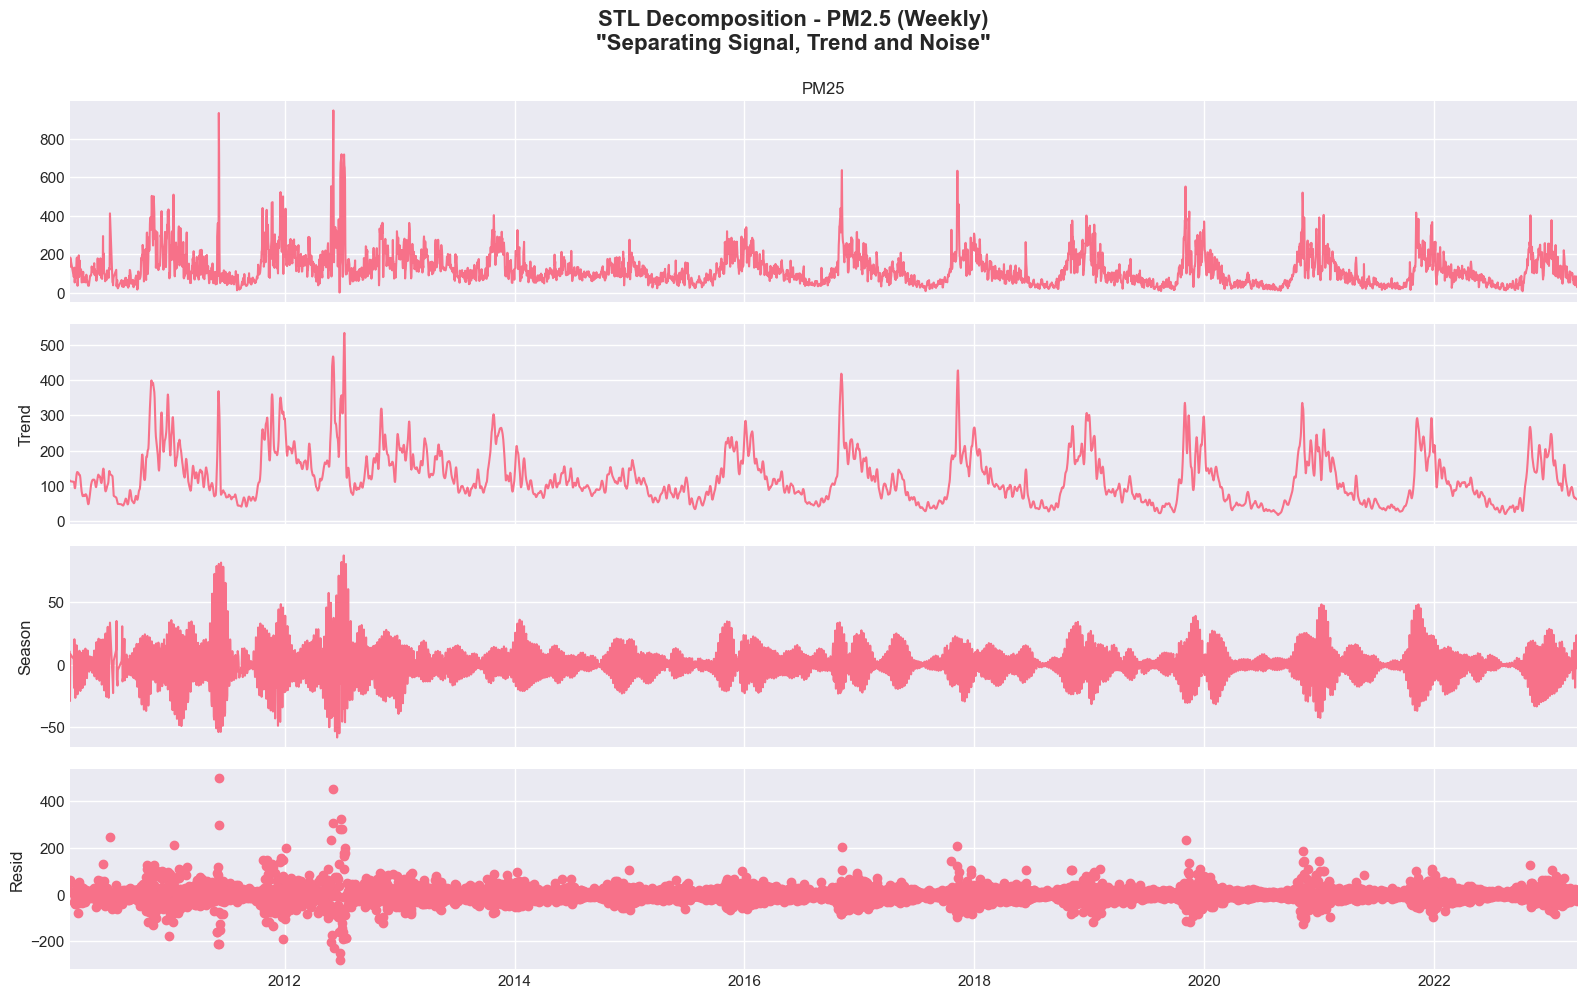


 COMPONENT ANALYSIS - PM2.5 (Weekly)
Observed variance:       7342.37 (100.0%)
Trend variance:          5262.77 ( 71.7%)
Seasonal variance:        159.16 (  2.2%)
Residual variance:       1328.52 ( 18.1%)

Trend strength:       0.798
Seasonality strength: 0.107
Strong trend detected


In [39]:
pm25_series = df_daily['PM25']
stl_pm25_weekly = stl_decomposition(pm25_series, period=7, seasonal=13, name='PM2.5 (Weekly)')


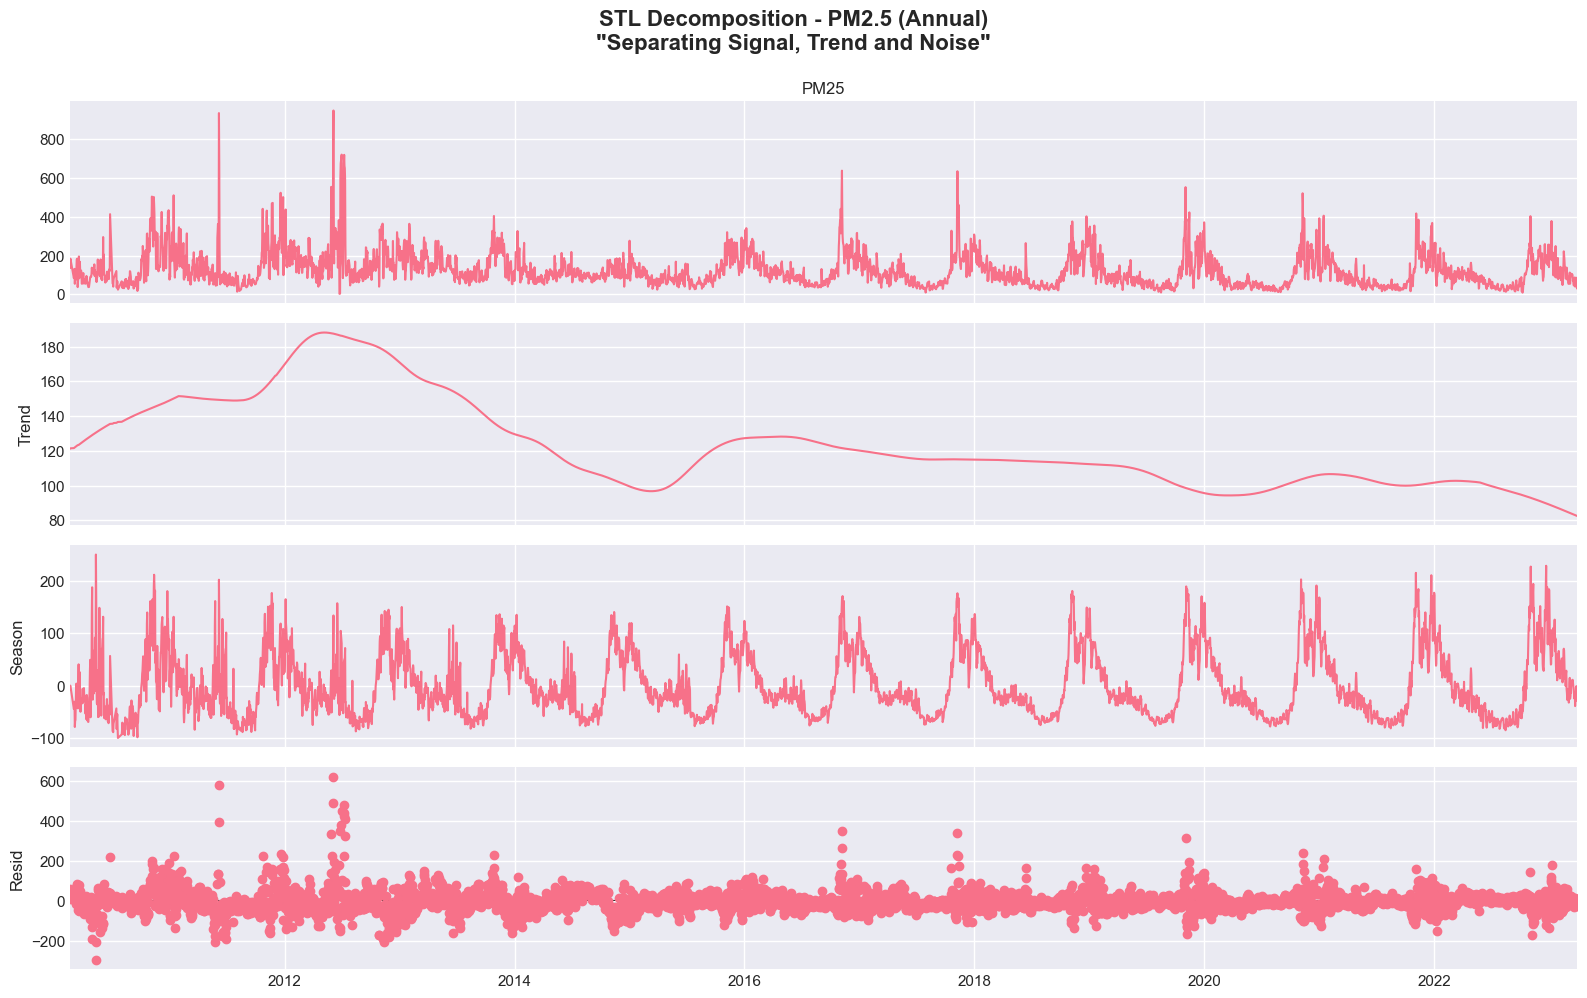


 COMPONENT ANALYSIS - PM2.5 (Annual)
Observed variance:       7342.37 (100.0%)
Trend variance:           646.07 (  8.8%)
Seasonal variance:       3747.62 ( 51.0%)
Residual variance:       2883.00 ( 39.3%)

Trend strength:       0.183
Seasonality strength: 0.565
Significant seasonality detected


In [40]:
# Note: period=365 to capture annual seasonality
stl_pm25_yearly = stl_decomposition(pm25_series, period=365, seasonal=13, name='PM2.5 (Annual)')


#### Interprétation STL

- **Tendance** : Montre l'évolution globale (amélioration ou détérioration)
- **Saisonnalité** : Révèle les cycles réguliers (hebdo, annuel)
- **Résidus** : Contient les événements exceptionnels et le bruit

**Force > 0.6** → Composante dominante  
**Force < 0.3** → Composante faible

### 4.2 Break Points Detection


**Méthodes** :
- **PELT** : Détection automatique (nombre de ruptures optimal)
- **Binary Segmentation** : Nombre fixe de ruptures

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

def detect_changepoints(
    series,
    n_bkps=5,
    model="l2",           # faster than 'rbf' for large series
    pen=10,
    name="Series",
    plot=True,            # disable to speed up batch runs
    min_size=30,          # minimum samples between breakpoints
    jump=None,            # grid step for candidate breakpoints
    stride=None,          # subsample factor, e.g., 2 keeps every other point
    context_window=7      # +/- window to summarize mean before/after
):
    """
    Detect change points in a time series using PELT (penalized, auto count)
    and Binary Segmentation (fixed count).

    Speed-ups:
      - Optional downsampling (stride)
      - Reduced candidate grid via 'jump'
      - Use 'l2' cost by default (faster than 'rbf')
      - Optional plotting
    """
    # ---- Clean + optional downsampling ----
    clean_series = series.dropna()
    if stride is not None and stride > 1:
        clean_series = clean_series.iloc[::stride]

    if len(clean_series) < max(2 * min_size, 50):
        print(f"[{name}] Series too short for reliable detection.")
        return None, None

    signal = clean_series.values.reshape(-1, 1)
    n = len(clean_series)

    # Sensible default for 'jump' to shrink candidate set when not provided
    if jump is None:
        # ~1000 candidates max; increase for longer series
        jump = max(5, n // 1000)

    # ---- PELT: penalized (auto number of changes) ----
    algo_pelt = rpt.Pelt(model=model, min_size=min_size, jump=jump).fit(signal)
    result_pelt = algo_pelt.predict(pen=pen)

    # ---- Binary Segmentation: fixed number of changes ----
    algo_binseg = rpt.Binseg(model=model, min_size=min_size, jump=jump).fit(signal)
    result_binseg = algo_binseg.predict(n_bkps=n_bkps)

   # ---- Optional visualization (fixed for Matplotlib >=3.8) ----
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)
        
        # --- PELT ---
        axes[0].plot(clean_series.index, clean_series.values, color="steelblue", linewidth=1)
        for bkp in result_pelt[:-1]:
            # convert index -> timestamp
            x = clean_series.index[bkp]
            axes[0].axvline(x, color="red", linestyle="--", alpha=0.8)
        axes[0].set_title(
            f"Change-point Detection — PELT ({len(result_pelt)-1} changes)\n{name}",
            fontsize=13, fontweight="bold"
        )
        axes[0].set_ylabel("Value")

        # --- Binary Segmentation ---
        axes[1].plot(clean_series.index, clean_series.values, color="steelblue", linewidth=1)
        for bkp in result_binseg[:-1]:
            x = clean_series.index[bkp]
            axes[1].axvline(x, color="orange", linestyle="--", alpha=0.8)
        axes[1].set_title(
            f"Change-point Detection — Binary Segmentation ({n_bkps} changes)\n{name}",
            fontsize=13, fontweight="bold"
        )
        axes[1].set_xlabel("Index")
        axes[1].set_ylabel("Value")

        plt.tight_layout()
        plt.show()


    # ---- Fast before/after summaries using cumulative sums ----
    arr = clean_series.values.astype(float)
    csum = np.cumsum(np.concatenate(([0.0], arr)))

    def window_mean(a, csum_vec, center, halfw):
        left = max(0, center - halfw)
        right = min(len(a), center)
        # avoid empty slice
        if right <= left:
            return np.nan
        return (csum_vec[right] - csum_vec[left]) / (right - left)

    def window_mean_after(a, csum_vec, center, halfw):
        left = center
        right = min(len(a), center + halfw)
        if right <= left:
            return np.nan
        return (csum_vec[right] - csum_vec[left]) / (right - left)

    idx_to_date = clean_series.index

    print(f"\nDETECTED CHANGE POINTS — {name}")
    print("=" * 70)

    # PELT (auto)
    print(f"\nPELT (penalty={pen}) — {len(result_pelt)-1} changes")
    for i, bkp in enumerate(result_pelt[:-1], 1):
        date = idx_to_date[bkp]
        before = window_mean(arr, csum, bkp, context_window)
        after = window_mean_after(arr, csum, bkp, context_window)
        change = (after - before) / before * 100 if before not in (0, np.nan) else np.nan
        print(f"  {i}. {date:%Y-%m-%d} (index {bkp})")
        print(f"     Before: {before:.2f} → After: {after:.2f} ({change:+.1f}%)")

    # Binary Segmentation (fixed count)
    print(f"\nBinary Segmentation — requested {n_bkps} changes")
    for i, bkp in enumerate(result_binseg[:-1], 1):
        date = idx_to_date[bkp]
        before = window_mean(arr, csum, bkp, context_window)
        after = window_mean_after(arr, csum, bkp, context_window)
        change = (after - before) / before * 100 if before not in (0, np.nan) else np.nan
        print(f"  {i}. {date:%Y-%m-%d} (index {bkp})")
        print(f"     Before: {before:.2f} → After: {after:.2f} ({change:+.1f}%)")

    return result_pelt, result_binseg


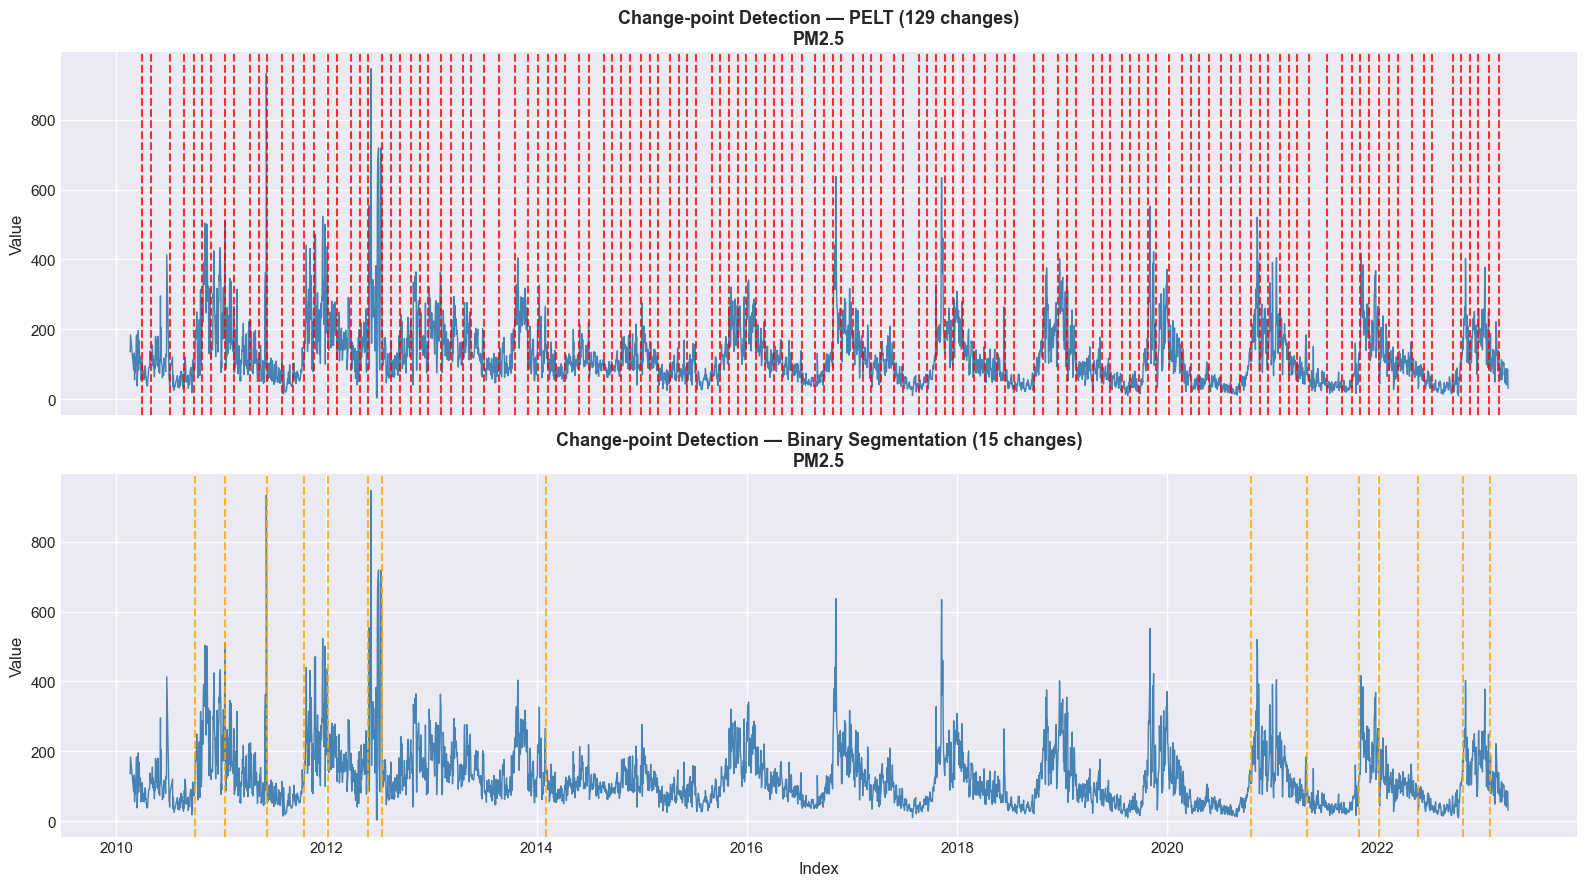


DETECTED CHANGE POINTS — PM2.5

PELT (penalty=500) — 129 changes
  1. 2010-03-31 (index 30)
     Before: 84.18 → After: 75.93 (-9.8%)
  2. 2010-04-30 (index 60)
     Before: 104.86 → After: 119.50 (+14.0%)
  3. 2010-07-06 (index 120)
     Before: 134.92 → After: 67.59 (-49.9%)
  4. 2010-08-23 (index 150)
     Before: 48.69 → After: 84.03 (+72.6%)
  5. 2010-09-27 (index 185)
     Before: 70.68 → After: 111.98 (+58.4%)
  6. 2010-10-27 (index 215)
     Before: 209.22 → After: 323.15 (+54.5%)
  7. 2010-11-26 (index 245)
     Before: 206.30 → After: 144.22 (-30.1%)
  8. 2011-01-15 (index 295)
     Before: 307.77 → After: 151.96 (-50.6%)
  9. 2011-02-14 (index 325)
     Before: 172.67 → After: 117.98 (-31.7%)
  10. 2011-04-11 (index 380)
     Before: 143.54 → After: 142.97 (-0.4%)
  11. 2011-05-11 (index 410)
     Before: 88.13 → After: 109.13 (+23.8%)
  12. 2011-06-10 (index 440)
     Before: 354.26 → After: 69.53 (-80.4%)
  13. 2011-07-31 (index 490)
     Before: 76.67 → After: 52.69 (-31

In [42]:
changepoints_pelt, changepoints_binseg = detect_changepoints(
    pm25_series, 
    n_bkps=15, 
    model='l2', 
    pen=500,  # Augmenter pour moins de ruptures
    name='PM2.5'
)

#### Interprétation des Ruptures

Les ruptures peuvent correspondre à :
- **Événements majeurs** : Lockdowns COVID (mars 2020, 2021)
- **Festivals** : Diwali (octobre-novembre) → Feux d'artifice
- **Saisons** : Transitions hiver/été
- **Changements de politique** : Nouvelles régulations

### 4.3 Stationarity Test

 Tests utilisés :

1. Test ADF (Augmented Dickey-Fuller)
- **H₀** : Série NON stationnaire (présence de racine unitaire)
- **H₁** : Série stationnaire
- **Décision** : Si p-value < 0.05 → Rejeter H₀ → **Stationnaire**

 2. Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
- **H₀** : Série EST stationnaire
- **H₁** : Série non stationnaire
- **Décision** : Si p-value > 0.05 → Ne pas rejeter H₀ → **Stationnaire**

In [43]:
def test_stationarity(series, name='Series'):
    """
    Effectue les tests de stationnarité ADF et KPSS.
    """
    clean_series = series.dropna()
    
    print(f"\n{'='*70}")
    print(f"TESTS DE STATIONNARITÉ : {name}")
    print('='*70)
    
    # TEST ADF
    print("\nTest ADF (Augmented Dickey-Fuller)")
    print("-"*70)
    print("H₀ : La série n'est PAS stationnaire")
    print("H₁ : La série est stationnaire")
    
    adf_result = adfuller(clean_series, autolag='AIC')
    
    print(f"\nStatistique ADF : {adf_result[0]:.4f}")
    print(f"p-value         : {adf_result[1]}")
    print(f"Lags utilisés   : {adf_result[2]}")
    print(f"\nValeurs critiques :")
    for key, value in adf_result[4].items():
        print(f"   {key:>5} : {value:.4f}")
    
    if adf_result[1] < 0.05:
        print(f"\nRésultat : Série STATIONNAIRE (p = {adf_result[1]:.4f} < 0.05)")
        adf_stationary = True
    else:
        print(f"\nRésultat : Série NON STATIONNAIRE (p = {adf_result[1]:.4f} >= 0.05)")
        adf_stationary = False
    
    # TEST KPSS
    print("\n\nTest KPSS (Kwiatkowski-Phillips-Schmidt-Shin)")
    print("-"*70)
    print("H₀ : La série EST stationnaire")
    print("H₁ : La série n'est pas stationnaire")
    
    kpss_result = kpss(clean_series, regression='c', nlags='auto')
    
    print(f"\nStatistique KPSS : {kpss_result[0]:.4f}")
    print(f"p-value          : {kpss_result[1]:.4f}")
    print(f"Lags utilisés    : {kpss_result[2]}")
    print(f"\nValeurs critiques :")
    for key, value in kpss_result[3].items():
        print(f"   {key:>5} : {value:.4f}")
    
    if kpss_result[1] > 0.05:
        print(f"\nRésultat : Série STATIONNAIRE (p = {kpss_result[1]:.4f} > 0.05)")
        kpss_stationary = True
    else:
        print(f"\nRésultat : Série NON STATIONNAIRE (p = {kpss_result[1]:.4f} <= 0.05)")
        kpss_stationary = False
    
    # SYNTHÈSE
    print("\n" + "="*70)
    print("SYNTHÈSE")
    print("="*70)
    
    if adf_stationary and kpss_stationary:
        print("Les deux tests indiquent : SÉRIE STATIONNAIRE")
    elif not adf_stationary and not kpss_stationary:
        print("Les deux tests indiquent : SÉRIE NON STATIONNAIRE")
    else:
        print("Résultats contradictoires entre ADF et KPSS")
        print("   → Examiner visuellement la série")
        print("   → Essayer des transformations")
    
    return {
        'adf_statistic': adf_result[0],
        'adf_pvalue': adf_result[1],
        'adf_stationary': adf_stationary,
        'kpss_statistic': kpss_result[0],
        'kpss_pvalue': kpss_result[1],
        'kpss_stationary': kpss_stationary
    }

In [44]:
# Test de stationnarité sur les résidus
stationarity_pm25_resid = test_stationarity(stl_pm25_yearly.resid, name='PM2.5 (Residuals)')


TESTS DE STATIONNARITÉ : PM2.5 (Residuals)

Test ADF (Augmented Dickey-Fuller)
----------------------------------------------------------------------
H₀ : La série n'est PAS stationnaire
H₁ : La série est stationnaire



Statistique ADF : -8.3792
p-value         : 2.536983990389196e-13
Lags utilisés   : 32

Valeurs critiques :
      1% : -3.4317
      5% : -2.8622
     10% : -2.5671

Résultat : Série STATIONNAIRE (p = 0.0000 < 0.05)


Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
----------------------------------------------------------------------
H₀ : La série EST stationnaire
H₁ : La série n'est pas stationnaire

Statistique KPSS : 0.0171
p-value          : 0.1000
Lags utilisés    : 31

Valeurs critiques :
     10% : 0.3470
      5% : 0.4630
    2.5% : 0.5740
      1% : 0.7390

Résultat : Série STATIONNAIRE (p = 0.1000 > 0.05)

SYNTHÈSE
Les deux tests indiquent : SÉRIE STATIONNAIRE


In [45]:
# Test sur la série originale pour comparaison
stationarity_pm25_obs = test_stationarity(stl_pm25_yearly.observed, name='PM2.5 (Original)')


TESTS DE STATIONNARITÉ : PM2.5 (Original)

Test ADF (Augmented Dickey-Fuller)
----------------------------------------------------------------------
H₀ : La série n'est PAS stationnaire
H₁ : La série est stationnaire

Statistique ADF : -6.1532
p-value         : 7.475029277887142e-08
Lags utilisés   : 24

Valeurs critiques :
      1% : -3.4317
      5% : -2.8622
     10% : -2.5671

Résultat : Série STATIONNAIRE (p = 0.0000 < 0.05)


Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
----------------------------------------------------------------------
H₀ : La série EST stationnaire
H₁ : La série n'est pas stationnaire

Statistique KPSS : 1.1396
p-value          : 0.0100
Lags utilisés    : 39

Valeurs critiques :
     10% : 0.3470
      5% : 0.4630
    2.5% : 0.5740
      1% : 0.7390

Résultat : Série NON STATIONNAIRE (p = 0.0100 <= 0.05)

SYNTHÈSE
Résultats contradictoires entre ADF et KPSS
   → Examiner visuellement la série
   → Essayer des transformations


### 4.4  ACF et PACF (Auto-Corrélation)


ACF (AutoCorrelation Function)
- Corrélation entre $Y_t$ et $Y_{t-k}$ pour différents lags $k$
- **Décroissance lente** → Série non stationnaire
- **Pic à lag k** → Cycle de période k

PACF (Partial AutoCorrelation Function)
- Corrélation entre $Y_t$ et $Y_{t-k}$ en **retirant** l'effet des lags intermédiaires
- Utile pour identifier l'ordre AR dans ARIMA

In [46]:
def plot_acf_pacf(series, lags=60, name='Series'):
    """
    Plot and analyze the ACF and PACF of a time series.
    """
    clean_series = series.dropna()
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # ACF
    plot_acf(clean_series, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title(f'Autocorrelation Function (ACF) - {name}', 
                      fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Lag', fontsize=11)
    axes[0].set_ylabel('ACF', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # PACF
    plot_pacf(clean_series, lags=lags, ax=axes[1], method='ywm', alpha=0.05)
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {name}', 
                      fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Lag', fontsize=11)
    axes[1].set_ylabel('PACF', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Compute ACF and PACF values
    acf_values = acf(clean_series, nlags=lags)
    pacf_values = pacf(clean_series, nlags=lags, method='ywm')
    
    # Identify significant lags (95% confidence interval)
    confidence_interval = 1.96 / np.sqrt(len(clean_series))
    significant_acf = np.where(np.abs(acf_values[1:]) > confidence_interval)[0] + 1
    significant_pacf = np.where(np.abs(pacf_values[1:]) > confidence_interval)[0] + 1
    
    print(f"\nACF/PACF ANALYSIS - {name}")
    print("="*70)
    print(f"\nSignificant ACF lags (first 15):")
    print(f"   {significant_acf[:15].tolist()}")
    print(f"\nSignificant PACF lags (first 15):")
    print(f"   {significant_pacf[:15].tolist()}")
    
    # Basic interpretation
    print("\nInterpretation:")
    if acf_values[1] > 0.9:
        print("   ACF(1) is very high → Strong persistence → Possible non-stationarity.")
    if 7 in significant_acf[:15]:
        print("   Peak at lag 7 → Possible weekly seasonality.")
    if 30 in significant_acf[:30] or 31 in significant_acf[:30]:
        print("   Peak around lag 30 → Possible monthly seasonality.")
    
    return acf_values, pacf_values

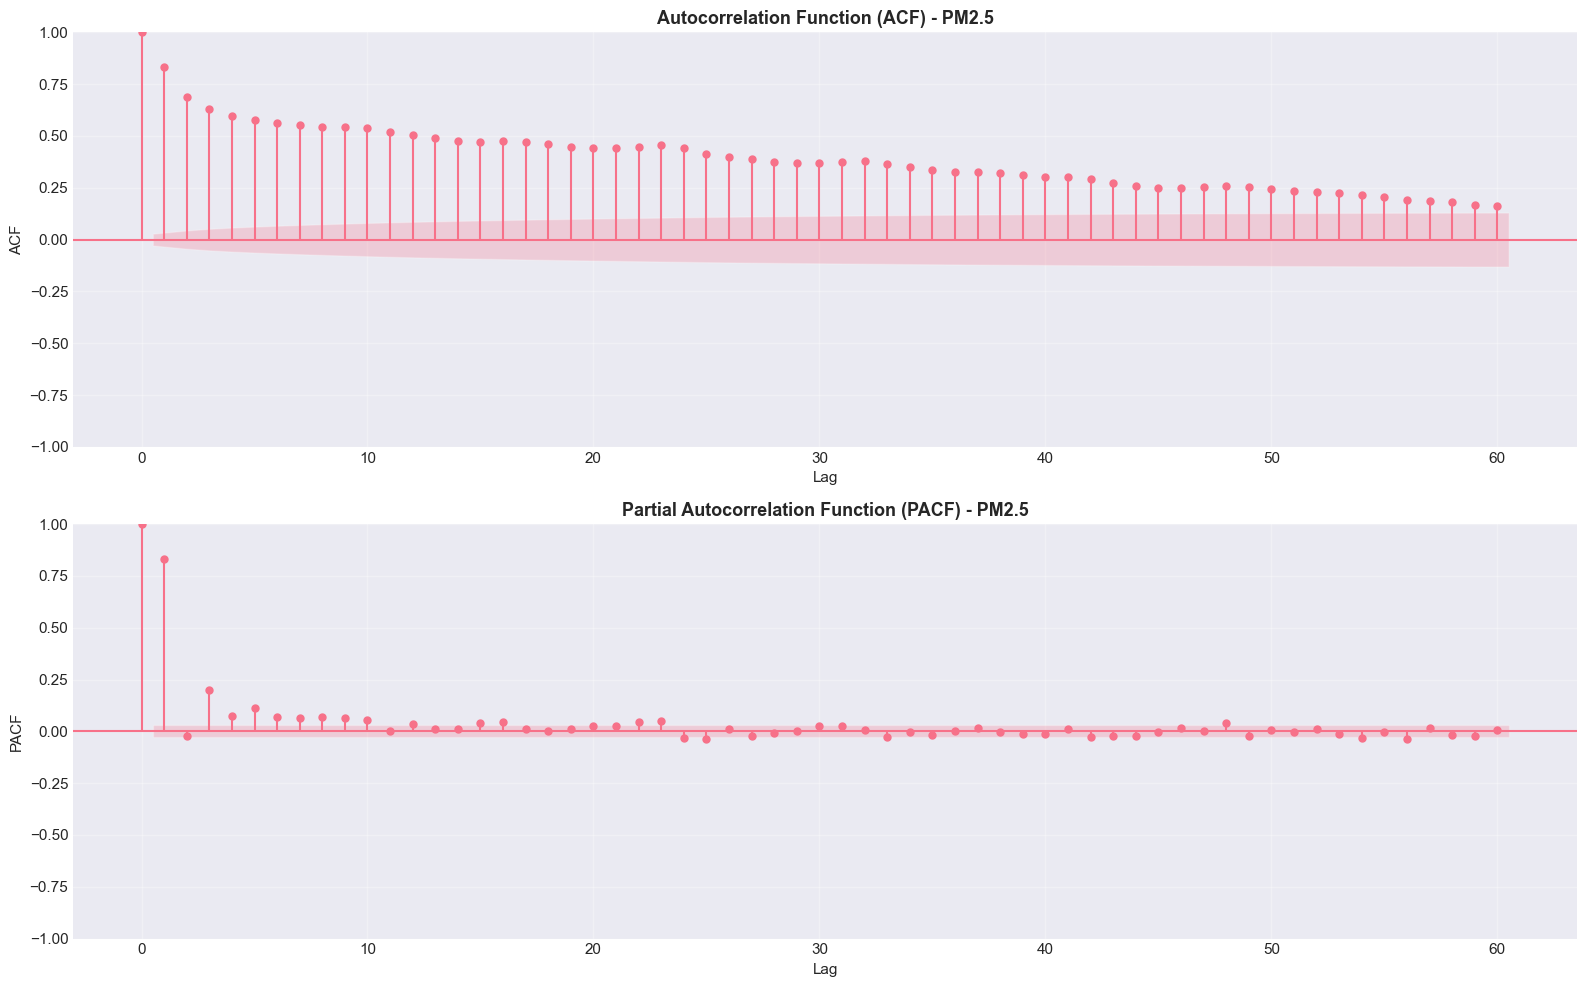


ACF/PACF ANALYSIS - PM2.5

Significant ACF lags (first 15):
   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Significant PACF lags (first 15):
   [1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 22, 23, 24]

Interpretation:
   Peak at lag 7 → Possible weekly seasonality.
   Peak around lag 30 → Possible monthly seasonality.


In [47]:
acf_pm25, pacf_pm25 = plot_acf_pacf(pm25_series, lags=60, name='PM2.5')

### 4.5 Transformations pour Stationnariser

Transformations courantes :
1. **Log** : Stabilise la variance
2. **Différenciation** : $\nabla Y_t = Y_t - Y_{t-1}$ → Retire la tendance
3. **Différenciation saisonnière** : $\nabla_s Y_t = Y_t - Y_{t-s}$ → Retire la saisonnalité
4. **Combinaisons** : Log + Diff

In [48]:
def apply_transformations(series, name='Series'):
    """
    Apply several transformations to a time series and test stationarity.
    """
    clean_series = series.dropna()
    
    # 1. Log transformation
    log_series = np.log(clean_series + 1)  # +1 to avoid log(0)
    
    # 2. First-order differencing
    diff_series = clean_series.diff().dropna()
    
    # 3. Seasonal differencing (period = 7 days)
    seasonal_diff_series = clean_series.diff(7).dropna()
    
    # 4. Log + Differencing
    log_diff_series = log_series.diff().dropna()
    
    # Visualization
    fig, axes = plt.subplots(5, 1, figsize=(16, 18))
    
    # Original
    axes[0].plot(clean_series.index, clean_series.values, linewidth=1, color='blue')
    axes[0].set_title(f'{name} - Original', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Value', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Log
    axes[1].plot(log_series.index, log_series.values, linewidth=1, color='orange')
    axes[1].set_title(f'{name} - Log Transformation', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('log(Value)', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Differencing
    axes[2].plot(diff_series.index, diff_series.values, linewidth=1, color='green')
    axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[2].set_title(f'{name} - First-order Differencing', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('ΔValue', fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    # Seasonal differencing
    axes[3].plot(seasonal_diff_series.index, seasonal_diff_series.values, linewidth=1, color='purple')
    axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[3].set_title(f'{name} - Seasonal Differencing (7 days)', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Δ₇Value', fontsize=10)
    axes[3].grid(True, alpha=0.3)
    
    # Log + Diff
    axes[4].plot(log_diff_series.index, log_diff_series.values, linewidth=1, color='red')
    axes[4].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[4].set_title(f'{name} - Log + Differencing', fontsize=12, fontweight='bold')
    axes[4].set_ylabel('Δlog(Value)', fontsize=10)
    axes[4].set_xlabel('Date', fontsize=11)
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stationarity tests for each transformation
    transformations = {
        'Original': clean_series,
        'Log': log_series,
        'Differencing': diff_series,
        'Seasonal Diff (7d)': seasonal_diff_series,
        'Log + Diff': log_diff_series
    }
    
    results = {}
    print(f"\n\n{'='*80}")
    print(f"STATIONARITY TESTS FOR EACH TRANSFORMATION")
    print('='*80)
    
    for trans_name, trans_series in transformations.items():
        print(f"\n{trans_name}...")
        results[trans_name] = test_stationarity(trans_series, name=f'{name} - {trans_name}')
    
    # Summary table
    print("\n\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(f"{'Transformation':<30} {'ADF p-val':>12} {'KPSS p-val':>12} {'Stationary?':>15}")
    print("-"*80)
    
    for trans_name, result in results.items():
        adf_p = result['adf_pvalue']
        kpss_p = result['kpss_pvalue']
        is_stat = result['adf_stationary'] and result['kpss_stationary']
        status = "YES" if is_stat else "NO"
        print(f"{trans_name:<30} {adf_p:>12.4f} {kpss_p:>12.4f} {status:>15}")
    
    # Recommendation
    print("\n" + "="*80)
    print("RECOMMENDATION")
    print("="*80)
    
    for trans_name, result in results.items():
        if result['adf_stationary'] and result['kpss_stationary']:
            print(f"Recommended transformation: {trans_name}")
            print("→ This transformation yields a stationary series suitable for ARIMA modeling.")
            break
    else:
        print("No transformation produced a fully stationary series.")
        print("→ Consider higher-order differencing or models that can handle non-stationarity (e.g., ARIMA with integration).")
    
    return {
        'log': log_series,
        'diff': diff_series,
        'seasonal_diff': seasonal_diff_series,
        'log_diff': log_diff_series,
        'test_results': results
    }


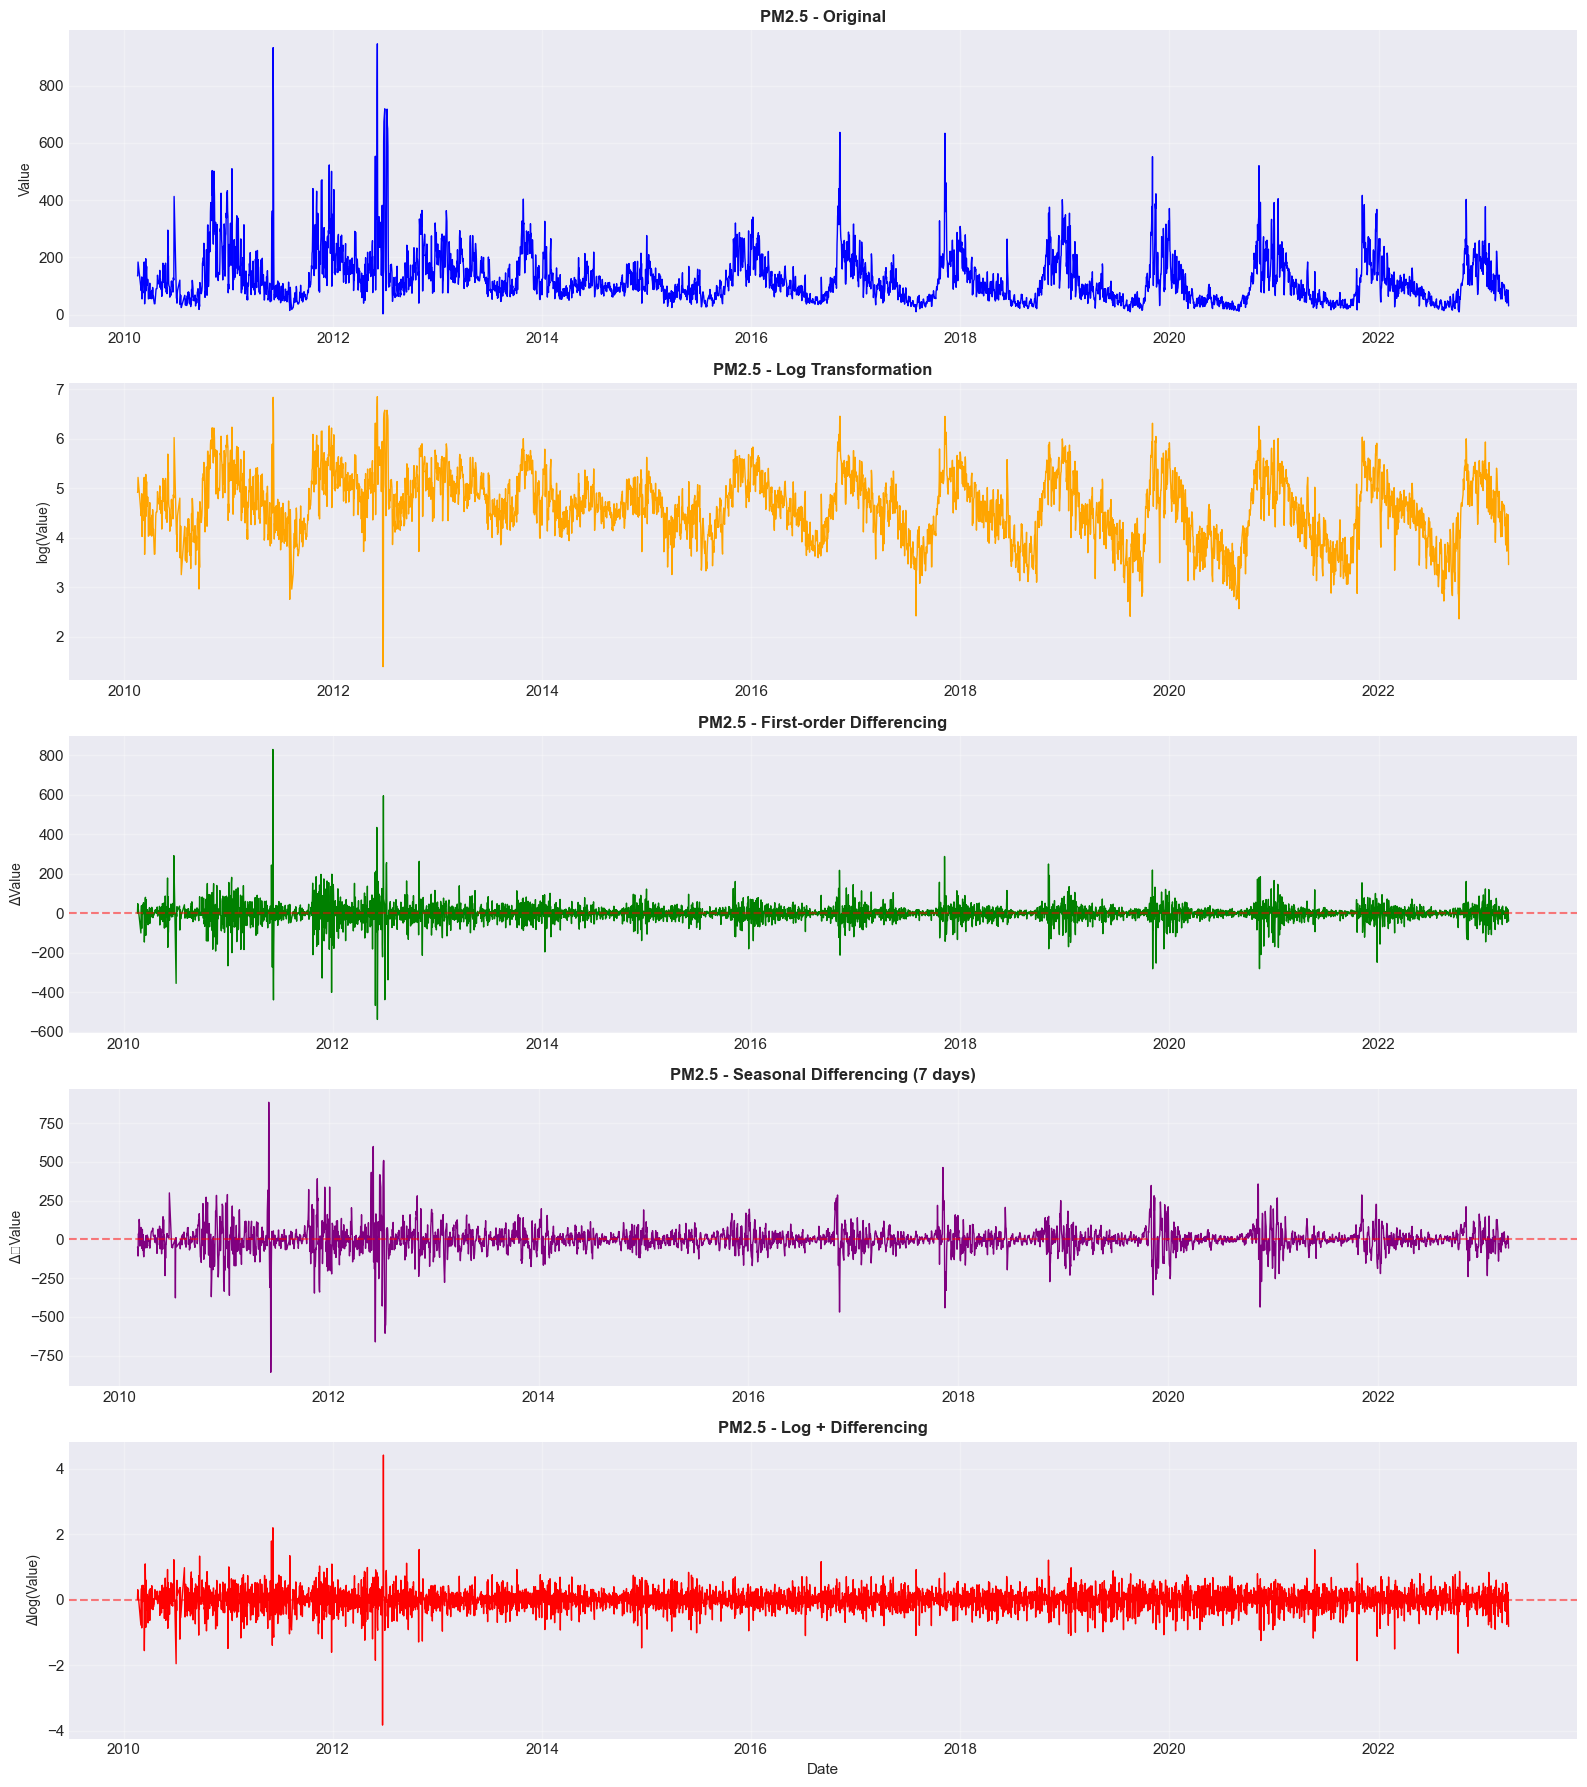



STATIONARITY TESTS FOR EACH TRANSFORMATION

Original...

TESTS DE STATIONNARITÉ : PM2.5 - Original

Test ADF (Augmented Dickey-Fuller)
----------------------------------------------------------------------
H₀ : La série n'est PAS stationnaire
H₁ : La série est stationnaire

Statistique ADF : -6.1532
p-value         : 7.475029277887142e-08
Lags utilisés   : 24

Valeurs critiques :
      1% : -3.4317
      5% : -2.8622
     10% : -2.5671

Résultat : Série STATIONNAIRE (p = 0.0000 < 0.05)


Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
----------------------------------------------------------------------
H₀ : La série EST stationnaire
H₁ : La série n'est pas stationnaire

Statistique KPSS : 1.1396
p-value          : 0.0100
Lags utilisés    : 39

Valeurs critiques :
     10% : 0.3470
      5% : 0.4630
    2.5% : 0.5740
      1% : 0.7390

Résultat : Série NON STATIONNAIRE (p = 0.0100 <= 0.05)

SYNTHÈSE
Résultats contradictoires entre ADF et KPSS
   → Examiner visuellement la série
   → E

In [49]:
transformations_pm25 = apply_transformations(pm25_series, name='PM2.5')

## 5. Dangerous Relations : Polluters in Partnership ?

### 5.1 Correlation Matrix

In [50]:
corr_matrix = df_daily[pollutants].corr(method='pearson')

print("Correlation Matrix (Pearson)")
print("="*70)
print(corr_matrix.round(3))

Correlation Matrix (Pearson)
        PM25     NO    NO2     CO  Ozone    NOx
PM25   1.000  0.534  0.502  0.196 -0.008  0.474
NO     0.534  1.000  0.693  0.078 -0.110  0.859
NO2    0.502  0.693  1.000 -0.017  0.129  0.824
CO     0.196  0.078 -0.017  1.000 -0.259  0.066
Ozone -0.008 -0.110  0.129 -0.259  1.000 -0.010
NOx    0.474  0.859  0.824  0.066 -0.010  1.000


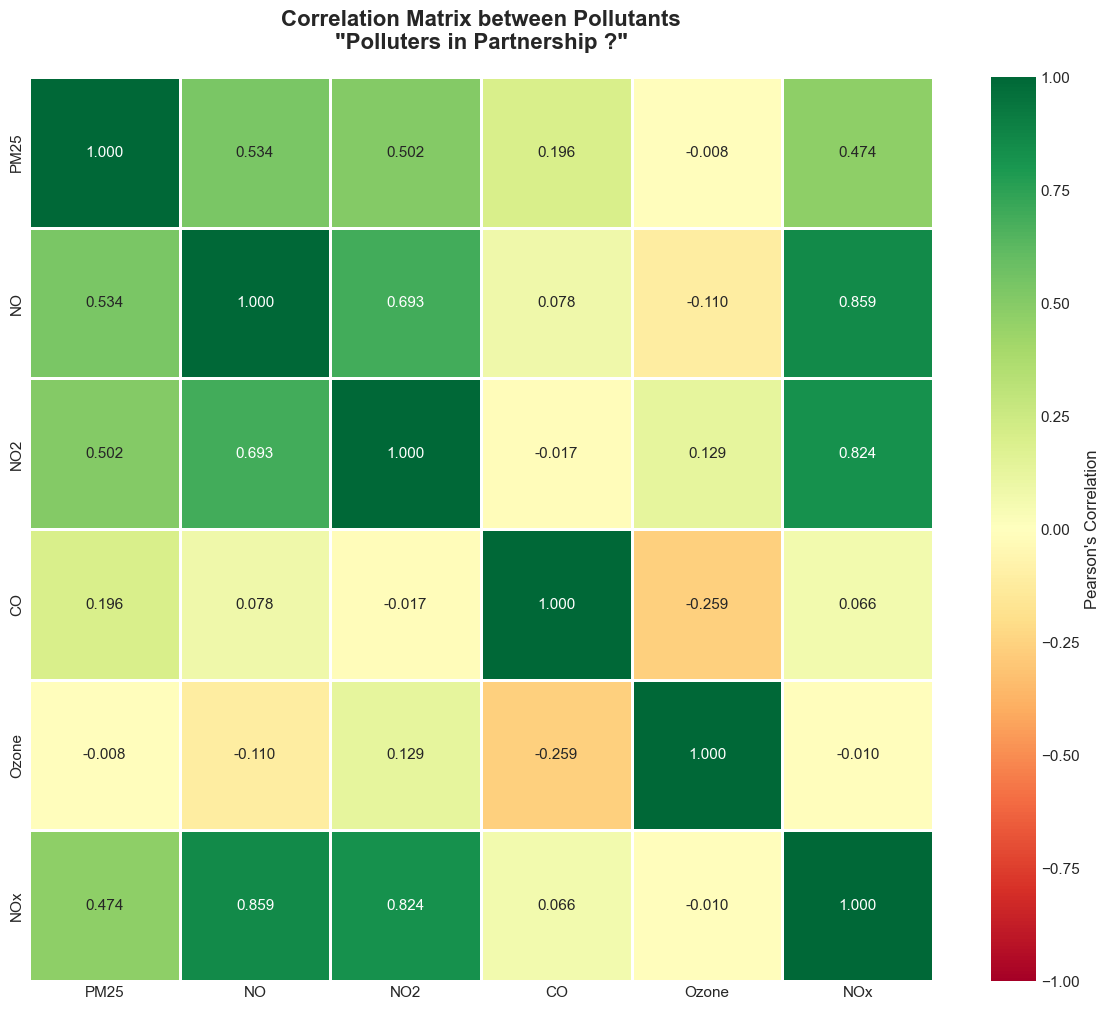

In [51]:
# Visualisation : Heatmap de corrélation
fig, ax = plt.subplots(figsize=(12, 10))

# Heatmap avec annotations
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.3f',
            cmap='RdYlGn',
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=1,
            cbar_kws={'label': 'Pearson\'s Correlation'},
            ax=ax)

ax.set_title('Correlation Matrix between Pollutants\n"Polluters in Partnership ?"', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [52]:
# Identify the most correlated pollutant pairs
print("\nMOST CORRELATED PAIRS")
print("="*70)

# Extract the upper triangle of the correlation matrix (excluding diagonal)
correlations = []
for i in range(len(pollutants)):
    for j in range(i + 1, len(pollutants)):
        pol1 = pollutants[i]
        pol2 = pollutants[j]
        corr_val = corr_matrix.loc[pol1, pol2]
        correlations.append((pol1, pol2, corr_val))

# Sort by absolute correlation value
correlations_sorted = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)

print("\nSTRONG POSITIVE CORRELATIONS")
for pol1, pol2, corr in correlations_sorted:
    if corr > 0.7:
        print(f"   {pol1:>6} ↔ {pol2:<6} : r = {corr:+.3f}")

print("\n NEGATIVE (INVERSE) CORRELATIONS")
for pol1, pol2, corr in correlations_sorted:
    if corr < -0.3:
        print(f"   {pol1:>6} ↔ {pol2:<6} : r = {corr:+.3f}")

print("\nWEAK OR INDEPENDENT CORRELATIONS")
for pol1, pol2, corr in correlations_sorted:
    if -0.3 <= corr <= 0.3:
        print(f"   {pol1:>6} ↔ {pol2:<6} : r = {corr:+.3f}")



MOST CORRELATED PAIRS

STRONG POSITIVE CORRELATIONS
       NO ↔ NOx    : r = +0.859
      NO2 ↔ NOx    : r = +0.824

 NEGATIVE (INVERSE) CORRELATIONS

WEAK OR INDEPENDENT CORRELATIONS
       CO ↔ Ozone  : r = -0.259
     PM25 ↔ CO     : r = +0.196
      NO2 ↔ Ozone  : r = +0.129
       NO ↔ Ozone  : r = -0.110
       NO ↔ CO     : r = +0.078
       CO ↔ NOx    : r = +0.066
      NO2 ↔ CO     : r = -0.017
    Ozone ↔ NOx    : r = -0.010
     PM25 ↔ Ozone  : r = -0.008


### 💡 Interprétation possibles des Corrélations a verifier

**Corrélations positives fortes** :
- Polluants émis par les mêmes sources
- Trafic routier (NOx, CO, PM2.5)
- Combustion (CO, NOx)

**Corrélations négatives** :
- PM2.5 vs Ozone : Réactions chimiques atmosphériques
- Ozone produit en conditions ensoleillées, PM2.5 réduit en hiver

**Corrélations faibles** :
- Polluants de sources différentes
- Processus de formation indépendants

### 5.2 Scatterplots - Visual Relations

**Objective** : Visualize the relations between PM2.5 and the other pollutants

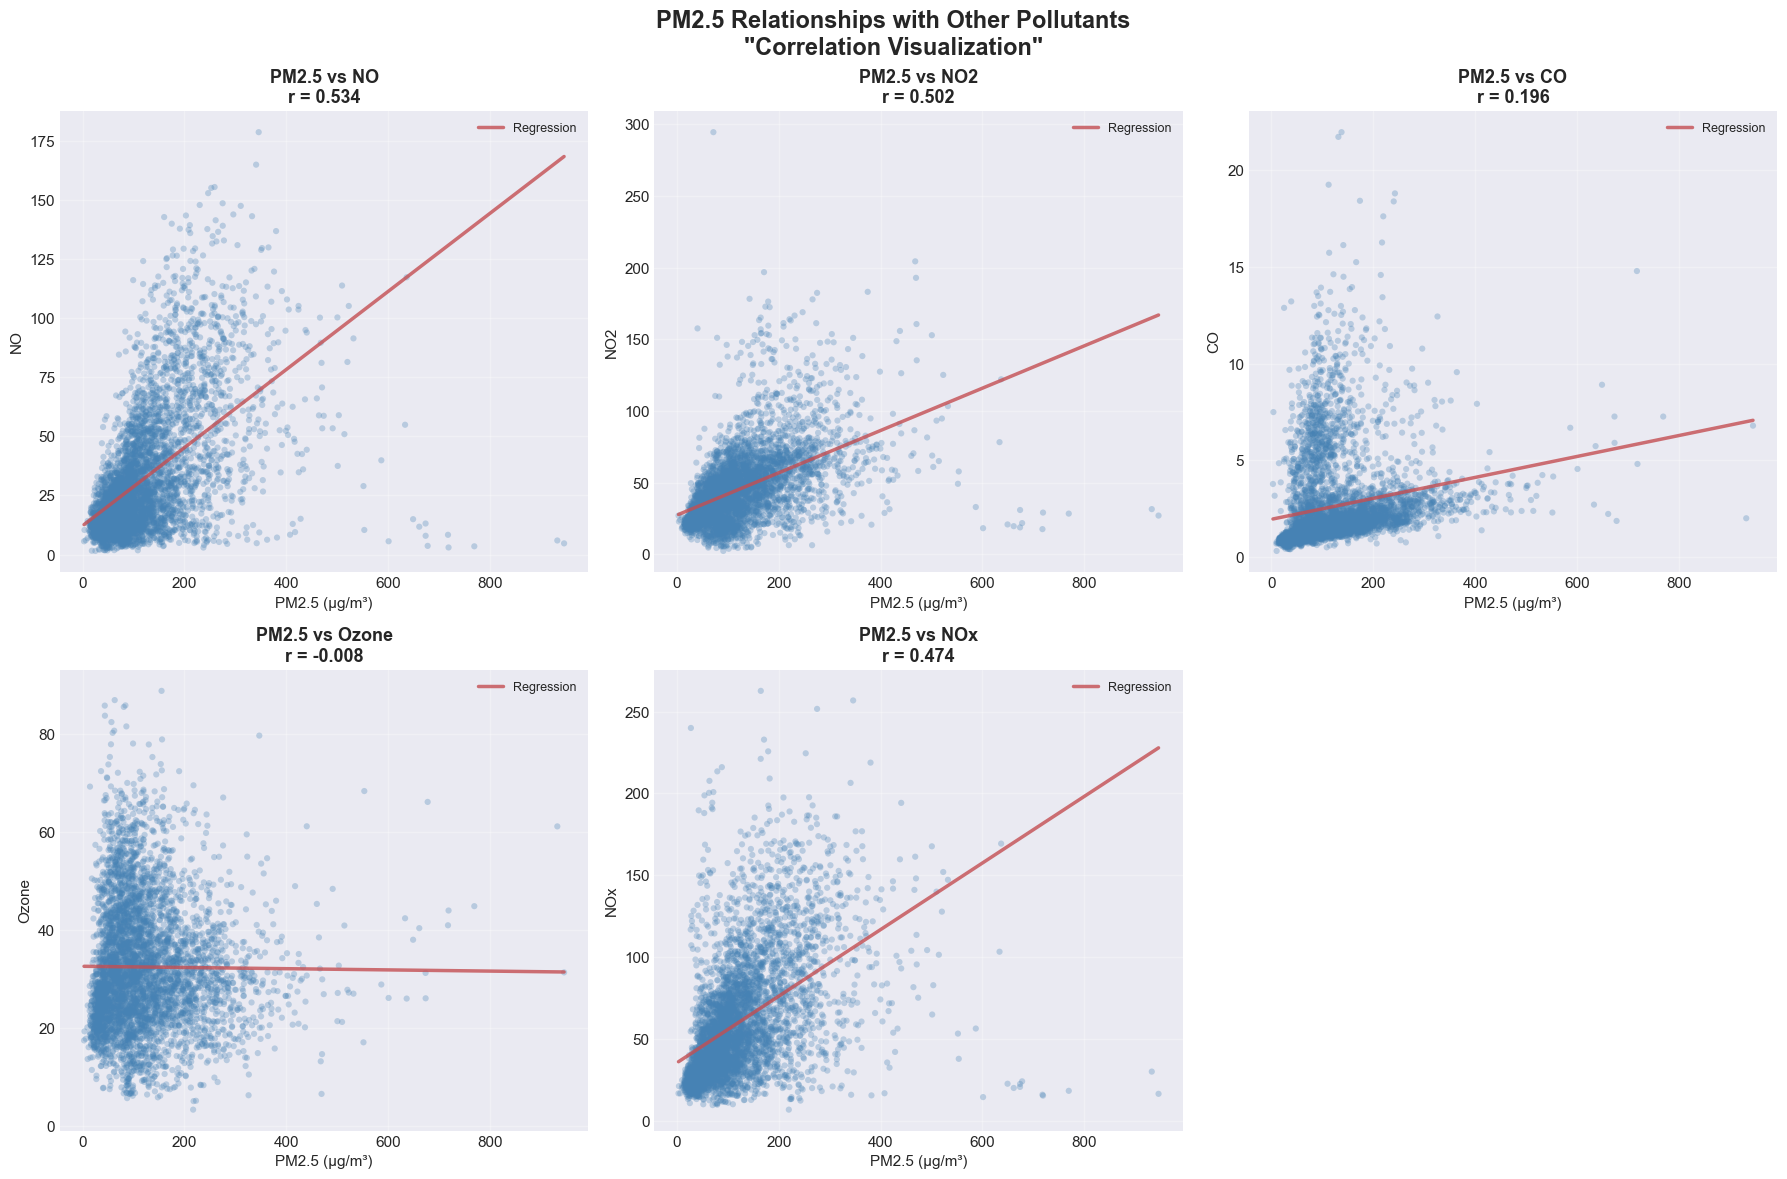

In [53]:
# Scatter plots: PM2.5 vs. other pollutants
other_pollutants = ['NO', 'NO2', 'CO', 'Ozone', 'NOx']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, pol in enumerate(other_pollutants):
    # Clean data
    data = df_daily[['PM25', pol]].dropna()
    
    # Scatter plot
    axes[idx].scatter(
        data['PM25'], data[pol],
        alpha=0.3, s=20, color='steelblue', edgecolors='none'
    )
    
    # Linear regression
    z = np.polyfit(data['PM25'], data[pol], 1)
    p = np.poly1d(z)
    x_reg = np.linspace(data['PM25'].min(), data['PM25'].max(), 100)
    axes[idx].plot(x_reg, p(x_reg), 'r-', linewidth=2.5, alpha=0.8, label='Regression')
    
    # Correlation
    corr = data['PM25'].corr(data[pol])
    
    # Titles and labels
    axes[idx].set_title(f'PM2.5 vs {pol}\nr = {corr:.3f}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('PM2.5 (μg/m³)', fontsize=11)
    axes[idx].set_ylabel(pol, fontsize=11)
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Hide the last empty subplot
axes[-1].axis('off')

plt.suptitle('PM2.5 Relationships with Other Pollutants\n"Correlation Visualization"', 
             fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()


### 5.3 Impact of the COVID

**Question** : Has the lockdown affected all the pollutants ?

**Period** :
- **Before COVID** : 2019-01-01 to 2020-03-22
- **Lockdown COVID** : 2020-03-23 to 2020-06-30
- **After COVID** : 2020-07-01 to 2023-03-31

In [54]:
before_covid = df_daily['2019-01-01':'2020-03-22']
during_covid = df_daily['2020-03-23':'2020-06-30']
after_covid = df_daily['2020-07-01':'2023-03-31']

# Calculer les moyennes par période
stats_covid = pd.DataFrame({
    'Before': before_covid[pollutants].mean(),
    'During': during_covid[pollutants].mean(),
    'After': after_covid[pollutants].mean()
})

# Calculer les variations en %
stats_covid['Δ During (%)'] = ((stats_covid['During'] - stats_covid['Before']) / stats_covid['Before'] * 100)
stats_covid['Δ After (%)'] = ((stats_covid['After'] - stats_covid['Before']) / stats_covid['Before'] * 100)

print("\n IMPACT OF COVID ON THE POLLUTANTS")
print("="*70)
print(stats_covid.round(2))


 IMPACT OF COVID ON THE POLLUTANTS
       Before  During   After  Δ During (%)  Δ After (%)
PM25   110.47   48.07  104.48        -56.49        -5.42
NO      33.07    9.39   36.23        -71.61         9.57
NO2     45.37   22.96   40.44        -49.38       -10.86
CO       1.36    0.83    1.36        -39.21        -0.38
Ozone   32.19   45.88   29.58         42.54        -8.09
NOx     54.28   21.28   55.78        -60.80         2.77


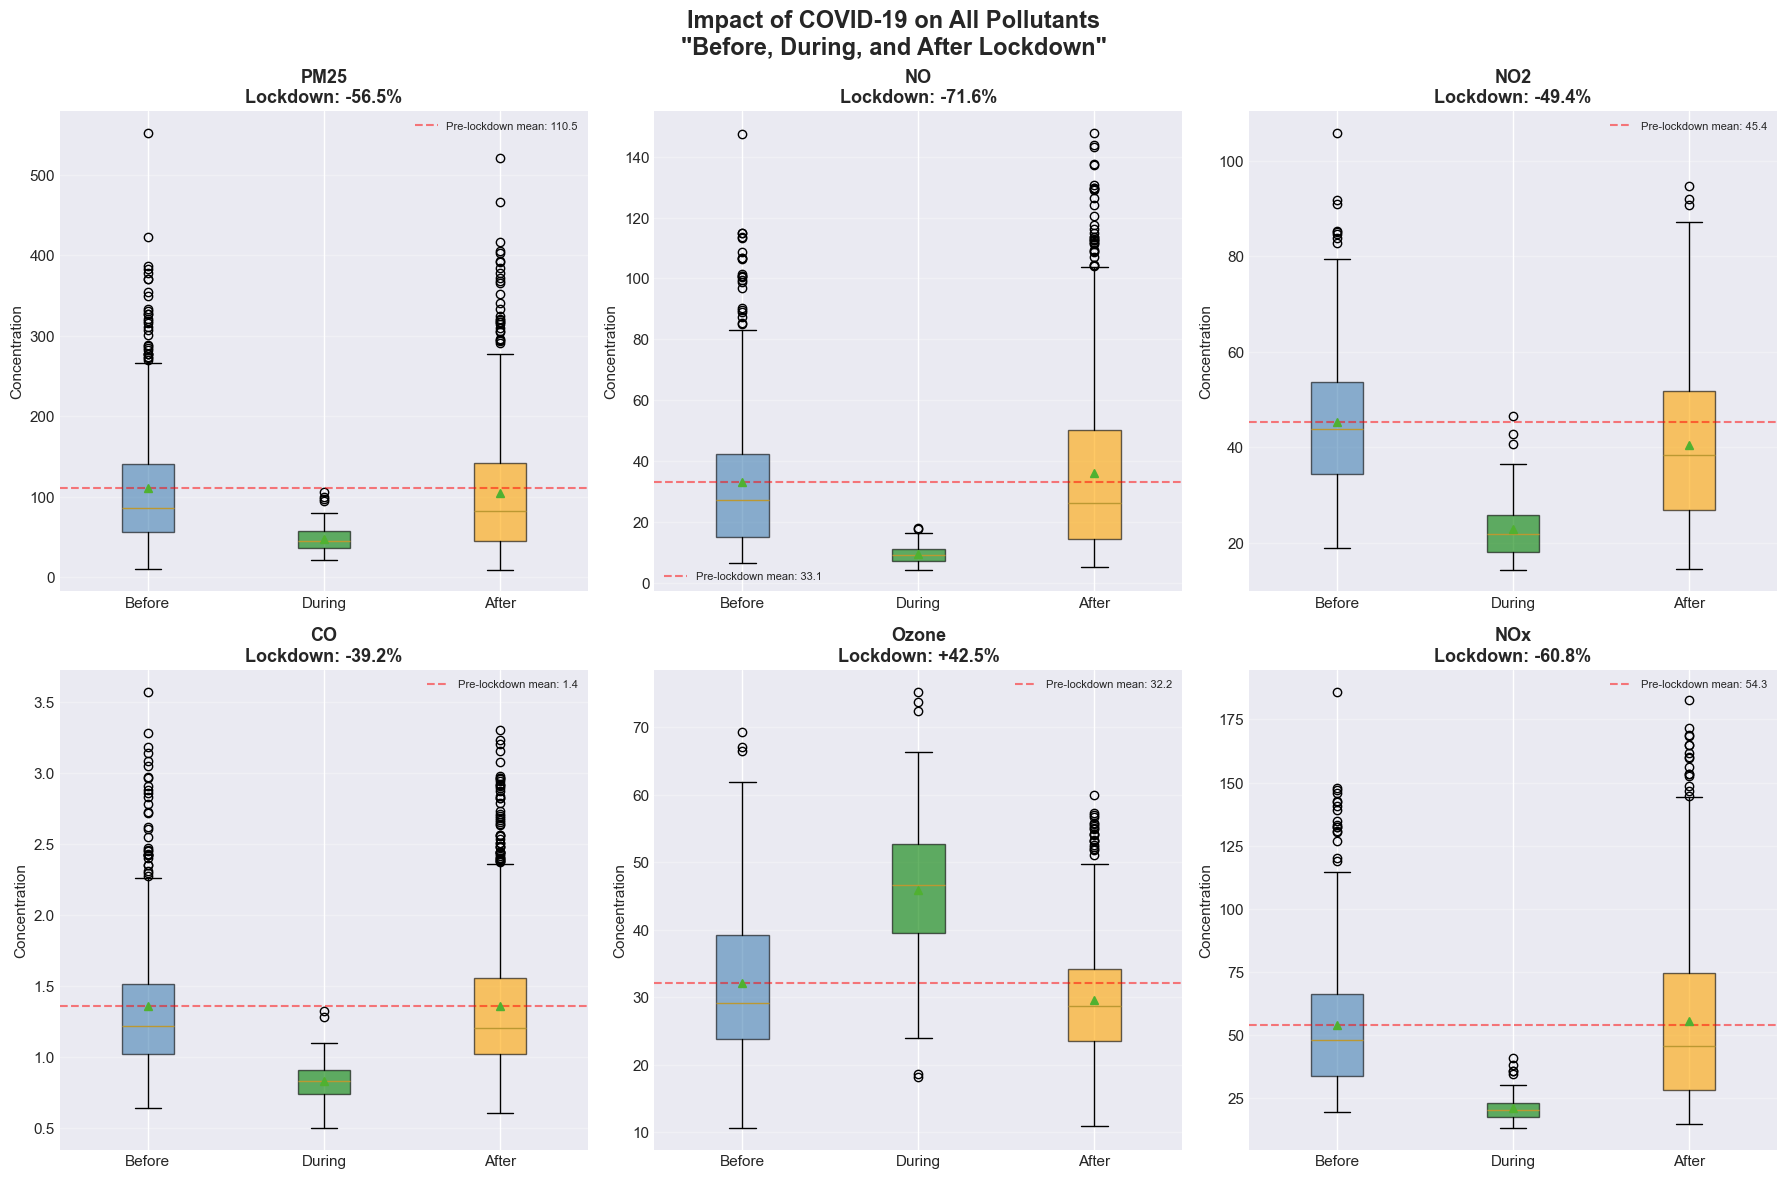

In [55]:
# Visualization of COVID-19 Impact
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, pol in enumerate(pollutants):
    # Data by period
    data_before = before_covid[pol].dropna()
    data_during = during_covid[pol].dropna()
    data_after = after_covid[pol].dropna()
    
    # Boxplots
    bp = axes[idx].boxplot(
        [data_before, data_during, data_after],
        labels=['Before', 'During', 'After'],
        patch_artist=True,
        showmeans=True
    )
    
    # Colors
    colors = ['steelblue', 'green', 'orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # Means
    mean_before = data_before.mean()
    mean_during = data_during.mean()
    mean_after = data_after.mean()
    
    # Change during lockdown
    change_during = ((mean_during - mean_before) / mean_before) * 100
    
    # Title with percentage change
    axes[idx].set_title(
        f'{pol}\nLockdown: {change_during:+.1f}%',
        fontsize=13, fontweight='bold'
    )
    axes[idx].set_ylabel('Concentration', fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Reference line (mean before)
    axes[idx].axhline(
        y=mean_before, color='red', linestyle='--',
        linewidth=1.5, alpha=0.5, label=f'Pre-lockdown mean: {mean_before:.1f}'
    )
    axes[idx].legend(loc='best', fontsize=8)

plt.suptitle(
    'Impact of COVID-19 on All Pollutants\n"Before, During, and After Lockdown"',
    fontsize=17, fontweight='bold'
)
plt.tight_layout()
plt.show()


In [56]:
# Summary of COVID-19 Impact
print("\nSYNTHESIS - COVID-19 IMPACT BY POLLUTANT")
print("="*70)

for pol in pollutants:
    before_mean = before_covid[pol].mean()
    during_mean = during_covid[pol].mean()
    after_mean = after_covid[pol].mean()
    
    change_during = ((during_mean - before_mean) / before_mean) * 100
    change_after = ((after_mean - before_mean) / before_mean) * 100
    
    print(f"\n{pol}:")
    print(f"   Before : {before_mean:.2f}")
    print(f"   During : {during_mean:.2f} ({change_during:+.1f}%)")
    print(f"   After  : {after_mean:.2f} ({change_after:+.1f}%)")
    
    if change_during < -30:
        print("   Significant decrease during lockdown")
    elif change_during < -10:
        print("   Moderate decrease during lockdown")
    elif change_during > 10:
        print("   Increase during lockdown (unusual)")
    
    if abs(change_after) < 10:
        print("   Return to pre-COVID levels")
    elif change_after < -10:
        print("   Persistent improvement post-COVID")



SYNTHESIS - COVID-19 IMPACT BY POLLUTANT

PM25:
   Before : 110.47
   During : 48.07 (-56.5%)
   After  : 104.48 (-5.4%)
   Significant decrease during lockdown
   Return to pre-COVID levels

NO:
   Before : 33.07
   During : 9.39 (-71.6%)
   After  : 36.23 (+9.6%)
   Significant decrease during lockdown
   Return to pre-COVID levels

NO2:
   Before : 45.37
   During : 22.96 (-49.4%)
   After  : 40.44 (-10.9%)
   Significant decrease during lockdown
   Persistent improvement post-COVID

CO:
   Before : 1.36
   During : 0.83 (-39.2%)
   After  : 1.36 (-0.4%)
   Significant decrease during lockdown
   Return to pre-COVID levels

Ozone:
   Before : 32.19
   During : 45.88 (+42.5%)
   After  : 29.58 (-8.1%)
   Increase during lockdown (unusual)
   Return to pre-COVID levels

NOx:
   Before : 54.28
   During : 21.28 (-60.8%)
   After  : 55.78 (+2.8%)
   Significant decrease during lockdown
   Return to pre-COVID levels


### 5.4 DTW - Series comparison

In [57]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

# DTW Function
def calculate_dtw_distance(series1, series2, window=50, name1='Series1', name2='Series2'):
    """
    Compute the Dynamic Time Warping (DTW) distance between two time series.
    
    Args:
        series1, series2: Time series data
        window: Sakoe-Chiba constraint window
        name1, name2: Series names for display
    """
    # Clean and normalize
    s1 = series1.dropna().values
    s2 = series2.dropna().values
    
    # Subsample if too long (for visualization purposes)
    if len(s1) > 500:
        indices = np.linspace(0, len(s1) - 1, 500, dtype=int)
        s1_sample = s1[indices]
        s2_sample = s2[indices]
    else:
        s1_sample = s1
        s2_sample = s2
    
    # Normalization (z-score)
    s1_norm = (s1_sample - np.mean(s1_sample)) / np.std(s1_sample)
    s2_norm = (s2_sample - np.mean(s2_sample)) / np.std(s2_sample)
    
    # Compute DTW distance
    distance = dtw.distance(s1_norm, s2_norm, window=window)
    
    print(f"\nDTW Distance: {name1} ↔ {name2}")
    print(f"   Distance: {distance:.4f}")
    print(f"   Series length: {len(s1_sample)} points")
    
    return distance, s1_norm, s2_norm


In [58]:
# Calculer DTW entre PM2.5 et autres polluants
print("\n DISTANCES DTW - PM2.5 vs Other Pollutants")
print("="*70)

dtw_distances = {}

for pol in ['NO', 'NO2', 'CO', 'Ozone', 'NOx']:
    if pol in df_daily.columns:
        distance, _, _ = calculate_dtw_distance(
            df_daily['PM25'], 
            df_daily[pol],
            window=50,
            name1='PM2.5',
            name2=pol
        )
        dtw_distances[pol] = distance


 DISTANCES DTW - PM2.5 vs Other Pollutants



DTW Distance: PM2.5 ↔ NO
   Distance: 15.3328
   Series length: 500 points

DTW Distance: PM2.5 ↔ NO2
   Distance: 14.6317
   Series length: 500 points

DTW Distance: PM2.5 ↔ CO
   Distance: 16.6014
   Series length: 500 points

DTW Distance: PM2.5 ↔ Ozone
   Distance: 14.8941
   Series length: 500 points

DTW Distance: PM2.5 ↔ NOx
   Distance: 14.9449
   Series length: 500 points


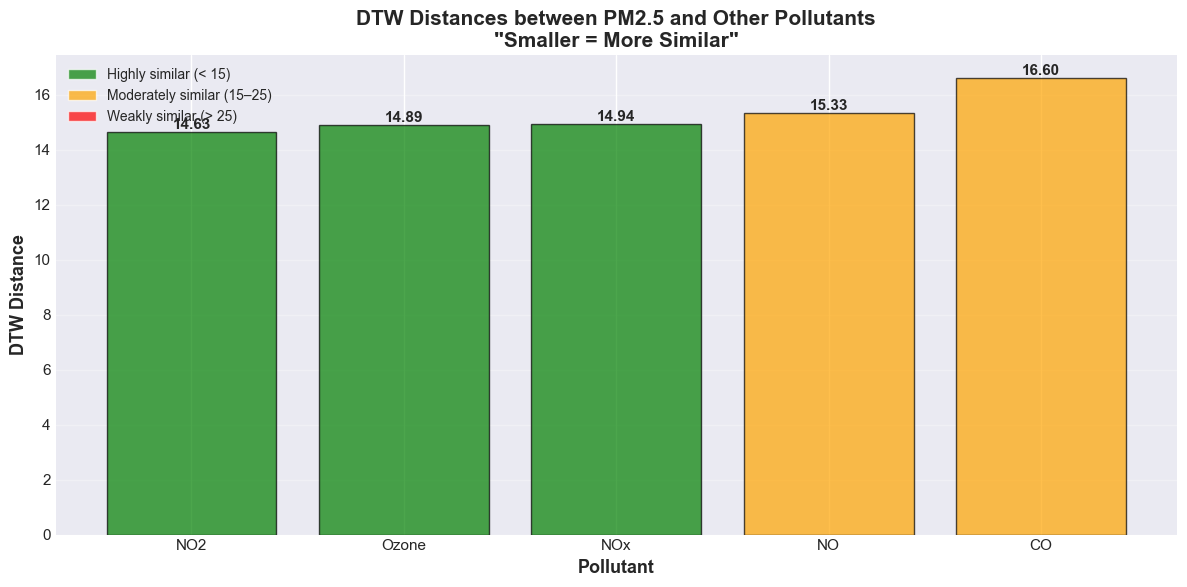

In [59]:
# Visualization of DTW Distances
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by distance
dtw_sorted = dict(sorted(dtw_distances.items(), key=lambda x: x[1]))

# Bar plot
colors = ['green' if d < 15 else 'orange' if d < 25 else 'red' 
          for d in dtw_sorted.values()]

bars = ax.bar(dtw_sorted.keys(), dtw_sorted.values(), color=colors, alpha=0.7, edgecolor='black')

# Annotations
for bar, (pol, dist) in zip(bars, dtw_sorted.items()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{dist:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Pollutant', fontsize=13, fontweight='bold')
ax.set_ylabel('DTW Distance', fontsize=13, fontweight='bold')
ax.set_title('DTW Distances between PM2.5 and Other Pollutants\n"Smaller = More Similar"', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Highly similar (< 15)'),
    Patch(facecolor='orange', alpha=0.7, label='Moderately similar (15–25)'),
    Patch(facecolor='red', alpha=0.7, label='Weakly similar (> 25)')
]
ax.legend(handles=legend_elements, loc='best', fontsize=10)

plt.tight_layout()
plt.show()


In [60]:
# DTW Interpretation
print("\nDTW INTERPRETATION")
print("="*70)

dtw_sorted = dict(sorted(dtw_distances.items(), key=lambda x: x[1]))

print("\nMOST SIMILAR POLLUTANTS to PM2.5 (low DTW distance):")
for pol, dist in list(dtw_sorted.items())[:2]:
    print(f"   {pol:<6} : Distance = {dist:.2f}")
    print(f"            → Very similar temporal pattern to PM2.5")
    print(f"            → Likely shared sources or strong interactions\n")

print("\nLEAST SIMILAR POLLUTANTS to PM2.5 (high DTW distance):")
for pol, dist in list(dtw_sorted.items())[-2:]:
    print(f"   {pol:<6} : Distance = {dist:.2f}")
    print(f"            → Temporal pattern differs significantly from PM2.5")
    print(f"            → Distinct emission sources or independent dynamics\n")



DTW INTERPRETATION

MOST SIMILAR POLLUTANTS to PM2.5 (low DTW distance):
   NO2    : Distance = 14.63
            → Very similar temporal pattern to PM2.5
            → Likely shared sources or strong interactions

   Ozone  : Distance = 14.89
            → Very similar temporal pattern to PM2.5
            → Likely shared sources or strong interactions


LEAST SIMILAR POLLUTANTS to PM2.5 (high DTW distance):
   NO     : Distance = 15.33
            → Temporal pattern differs significantly from PM2.5
            → Distinct emission sources or independent dynamics

   CO     : Distance = 16.60
            → Temporal pattern differs significantly from PM2.5
            → Distinct emission sources or independent dynamics



#### 💡 Différence Corrélation vs DTW

**Corrélation de Pearson** :
- Mesure relation linéaire instantanée
- Sensible aux valeurs extrêmes
- Ne capture pas les délais temporels

**DTW** :
- Mesure similarité de forme avec flexibilité temporelle
- Robuste aux décalages
- Capture patterns globaux

**Complémentarité** :
- Corrélation élevée + DTW faible → Forte relation linéaire synchrone
- Corrélation faible + DTW faible → Patterns similaires mais décalés
- Corrélation faible + DTW élevé → Polluants indépendants

### 5.5 “Toxic Cocktails” — Multi-Pollutant Events

**Question**: When are all pollutants simultaneously high?

Definition of a “Toxic Day”:
- PM2.5 > 150 μg/m³ (10× WHO guideline)
- NO₂ > 80 μg/m³
- CO > 2.0 mg/m³ <br>

At least three pollutants exceed their respective thresholds

In [61]:
# Define thresholds
thresholds = {
    'PM25': 150,   # μg/m³
    'NO2': 80,     # μg/m³
    'CO': 2.0,     # mg/m³
    'NOx': 150,    # μg/m³
}

print("DEFINED THRESHOLDS FOR 'TOXIC DAY'")
print("="*70)
for pol, thresh in thresholds.items():
    unit = 'mg/m³' if pol == 'CO' else 'μg/m³'
    print(f"   {pol:<6} > {thresh} {unit}")


DEFINED THRESHOLDS FOR 'TOXIC DAY'
   PM25   > 150 μg/m³
   NO2    > 80 μg/m³
   CO     > 2.0 mg/m³
   NOx    > 150 μg/m³


In [62]:
# Identify toxic days
toxic_days = df_daily.copy()

# Mark exceedances
for pol, thresh in thresholds.items():
    if pol in toxic_days.columns:
        toxic_days[f'{pol}_exceed'] = toxic_days[pol] > thresh

# Count the number of pollutants exceeding their threshold
exceed_cols = [f'{pol}_exceed' for pol in thresholds.keys() if f'{pol}_exceed' in toxic_days.columns]
toxic_days['n_exceed'] = toxic_days[exceed_cols].sum(axis=1)

# Define toxic days: at least 3 pollutants above their thresholds
toxic_days['is_toxic'] = toxic_days['n_exceed'] >= 3

# Statistics
n_toxic = toxic_days['is_toxic'].sum()
pct_toxic = 100 * n_toxic / len(toxic_days)

print("\nTOXIC DAYS IDENTIFIED")
print("="*70)
print(f"   Total days analyzed : {len(toxic_days)}")
print(f"   Toxic days          : {n_toxic} ({pct_toxic:.1f}%)")
print(f"   Normal days         : {len(toxic_days) - n_toxic} ({100 - pct_toxic:.1f}%)")



TOXIC DAYS IDENTIFIED
   Total days analyzed : 4838
   Toxic days          : 288 (6.0%)
   Normal days         : 4550 (94.0%)


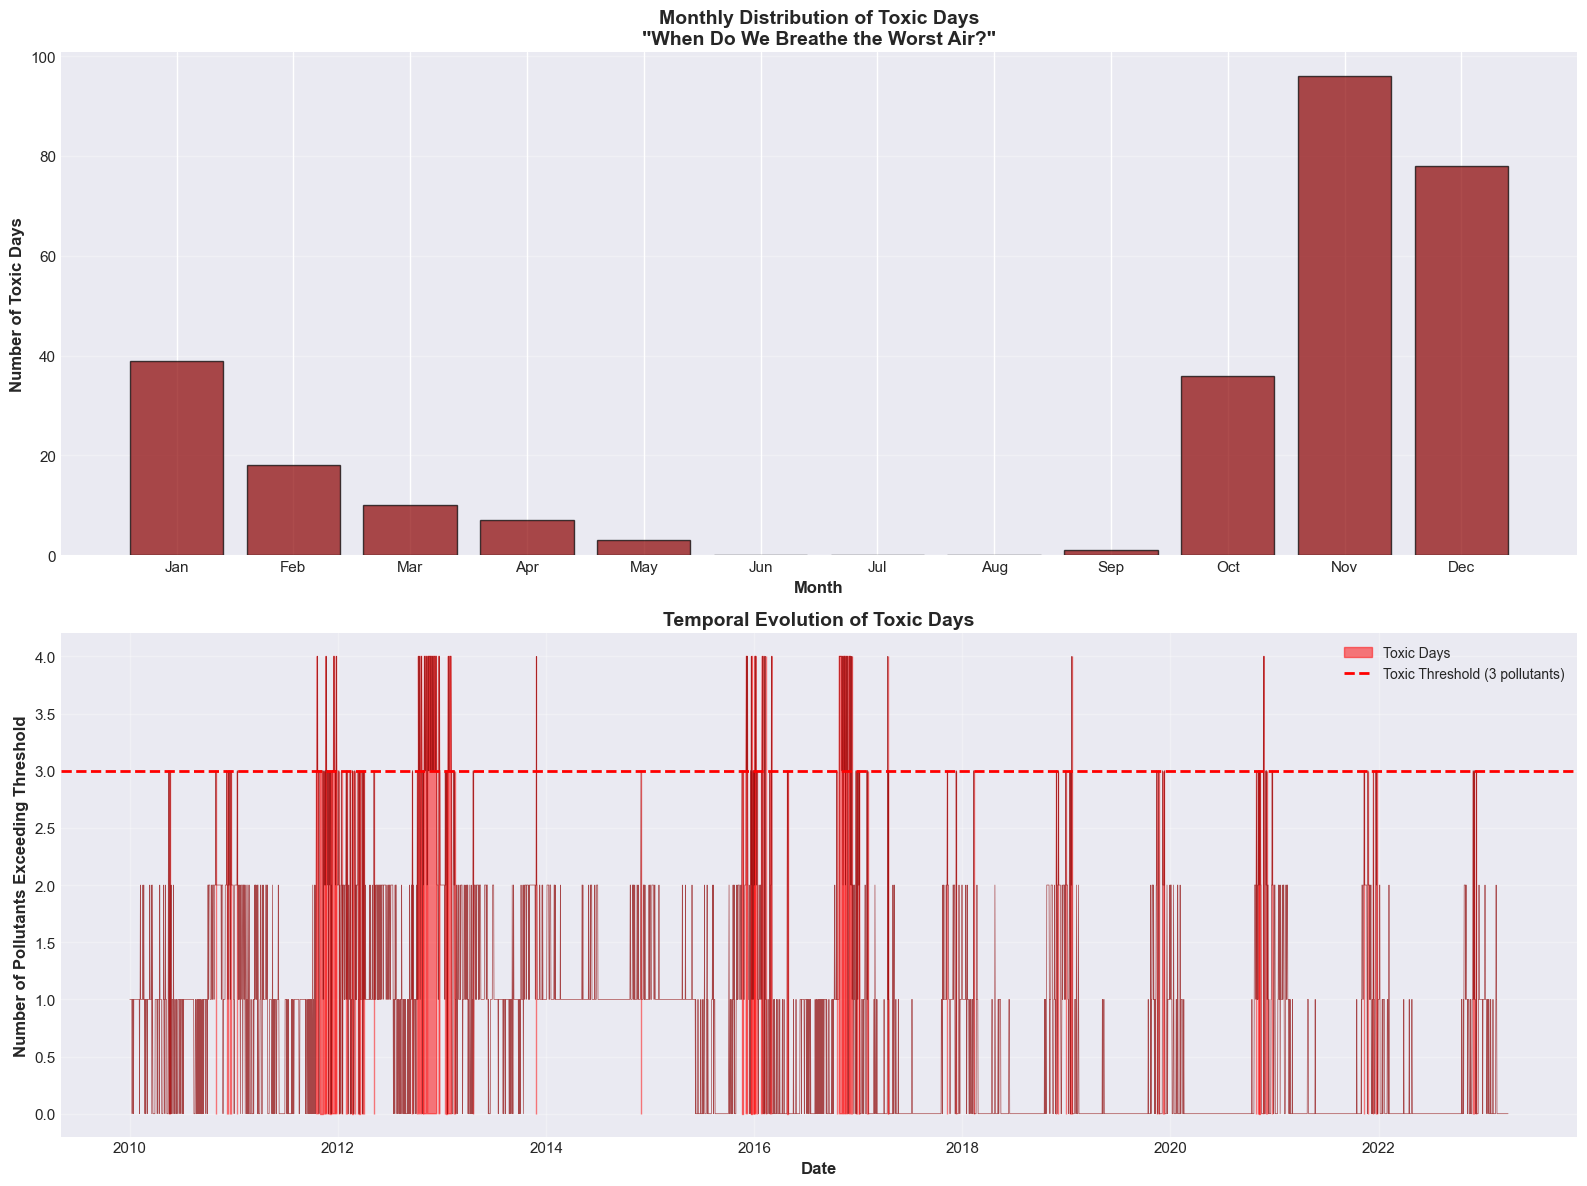

In [63]:
# Temporal analysis of toxic days
toxic_only = toxic_days[toxic_days['is_toxic']]

# By month
toxic_only_month = toxic_only.groupby(toxic_only.index.month).size()

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Monthly distribution
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0].bar(range(1, 13), 
            [toxic_only_month.get(i, 0) for i in range(1, 13)],
            color='darkred', alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names)
axes[0].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Toxic Days', fontsize=12, fontweight='bold')
axes[0].set_title('Monthly Distribution of Toxic Days\n"When Do We Breathe the Worst Air?"', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Temporal evolution
axes[1].fill_between(toxic_days.index, 0, toxic_days['n_exceed'], 
                     where=(toxic_days['is_toxic']), 
                     color='red', alpha=0.5, label='Toxic Days')
axes[1].plot(toxic_days.index, toxic_days['n_exceed'], 
             linewidth=0.5, color='darkred', alpha=0.7)
axes[1].axhline(y=3, color='red', linestyle='--', linewidth=2, 
                label='Toxic Threshold (3 pollutants)')
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Pollutants Exceeding Threshold', fontsize=12, fontweight='bold')
axes[1].set_title('Temporal Evolution of Toxic Days', 
                  fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [64]:
# Top 10 most toxic days
top_toxic = toxic_days.nlargest(10, 'n_exceed')[['PM25', 'NO2', 'CO', 'NOx', 'n_exceed']]

print("\nTOP 10 MOST TOXIC DAYS")
print("="*70)
print(top_toxic.round(2))

# Statistics by season
toxic_only['season'] = toxic_only.index.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

season_counts = toxic_only['season'].value_counts()

print("\n\nTOXIC DAYS BY SEASON")
print("="*70)
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    count = season_counts.get(season, 0)
    pct = 100 * count / n_toxic if n_toxic > 0 else 0
    print(f"   {season:<12} : {count:>4} days ({pct:>5.1f}%)")



TOP 10 MOST TOXIC DAYS
              PM25     NO2    CO     NOx  n_exceed
Timestamp                                         
2011-10-21  221.12  163.94  3.44  163.76         4
2011-11-21  468.03  204.30  3.80  161.34         4
2011-12-18  438.06  155.76  3.33  159.73         4
2011-12-19  523.06  125.10  3.84  151.99         4
2011-12-27  500.73  152.79  3.57  167.69         4
2012-10-10  233.97  143.34  2.08  169.62         4
2012-10-13  182.60  142.95  2.48  183.20         4
2012-10-19  216.84  130.18  2.64  153.59         4
2012-10-20  232.71  149.92  2.08  170.65         4
2012-10-21  187.44  136.10  2.34  162.71         4


TOXIC DAYS BY SEASON
   Winter       :  135 days ( 46.9%)
   Spring       :   20 days (  6.9%)
   Summer       :    0 days (  0.0%)
   Autumn       :  133 days ( 46.2%)


## 6. Predict the Invisible - Machine Learning & Forecasting

In [65]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    silhouette_score, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 6.1 CLASSIFICATION - Predict the Air Quality levels

**Objective** : Classify everyday given teh air quality

**Indian norms (CPCB)** :
- **Good** : PM2.5 ≤ 30 μg/m³
- **Moderate** : 31-60 μg/m³
- **Poor** : 61-120 μg/m³
- **Very Poor** : 121-250 μg/m³
- **Severe** : > 250 μg/m³


CLASS DISTRIBUTION
   Good         :   198 days (  4.1%)
   Moderate     :   857 days ( 17.7%)
   Poor         :  1800 days ( 37.2%)
   Very Poor    :  1505 days ( 31.1%)
   Severe       :   478 days (  9.9%)


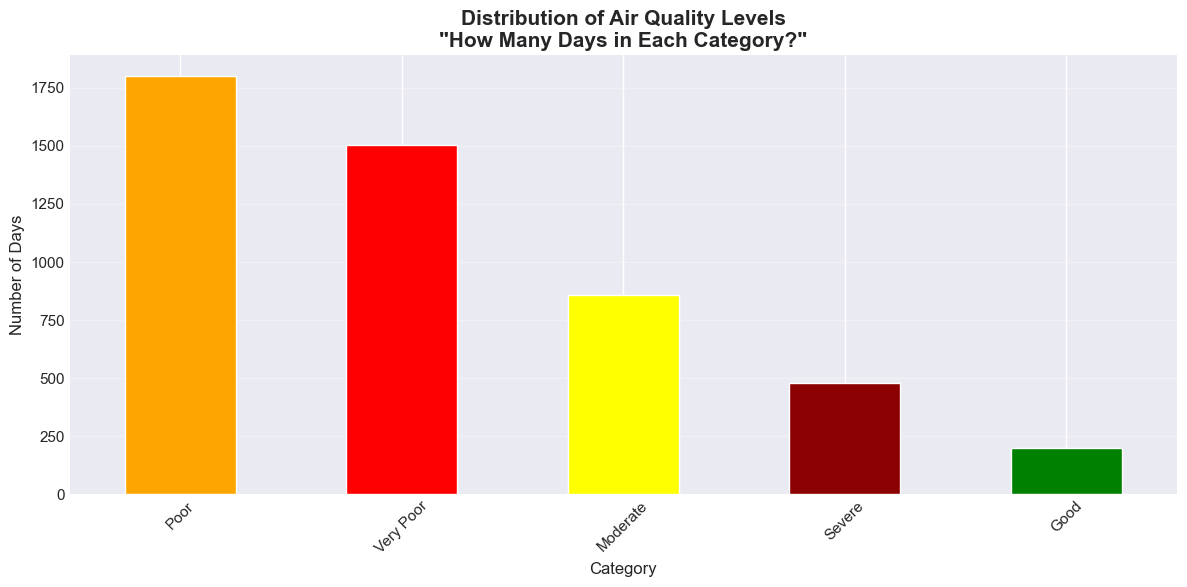

In [66]:
# Create classification labels
def classify_air_quality(pm25):
    if pm25 <= 30:
        return 'Good'
    elif pm25 <= 60:
        return 'Moderate'
    elif pm25 <= 120:
        return 'Poor'
    elif pm25 <= 250:
        return 'Very Poor'
    else:
        return 'Severe'

# Apply classification
df_ml = df_daily.copy()
df_ml['AQI_Category'] = df_ml['PM25'].apply(classify_air_quality)

# Class distribution
print("\nCLASS DISTRIBUTION")
print("="*70)
class_counts = df_ml['AQI_Category'].value_counts()
for category in ['Good', 'Moderate', 'Poor', 'Very Poor', 'Severe']:
    count = class_counts.get(category, 0)
    pct = 100 * count / len(df_ml)
    print(f"   {category:<12} : {count:>5} days ({pct:>5.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
colors = {
    'Good': 'green',
    'Moderate': 'yellow',
    'Poor': 'orange',
    'Very Poor': 'red',
    'Severe': 'darkred'
}
class_counts.plot(
    kind='bar',
    color=[colors.get(x, 'gray') for x in class_counts.index],
    ax=ax
)
ax.set_title(
    'Distribution of Air Quality Levels\n"How Many Days in Each Category?"',
    fontsize=15,
    fontweight='bold'
)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Number of Days', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Feature Engineering

- **Temporelles** : month, season, day_of_year (saisonnalité dominante)
- **Polluants** : NO2 (meilleure corrélation), NOx (trafic)
- **Binaires** : is_winter, post_covid

**To avoid** : NO + NO2 + NOx together (multicolinéarité r=0.859)

In [67]:
# Feature engineering
df_ml['month'] = df_ml.index.month
df_ml['day_of_year'] = df_ml.index.dayofyear
df_ml['day_of_week'] = df_ml.index.dayofweek
df_ml['is_weekend'] = (df_ml['day_of_week'] >= 5).astype(int)

# Season
def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5]:
        return 2  # Spring
    elif month in [6, 7, 8]:
        return 3  # Summer
    else:
        return 4  # Autumn

df_ml['season'] = df_ml['month'].apply(get_season)
df_ml['is_winter'] = (df_ml['season'] == 1).astype(int)
df_ml['is_summer'] = (df_ml['season'] == 3).astype(int)

# Diwali period (October–November)
df_ml['is_diwali_period'] = df_ml['month'].isin([10, 11]).astype(int)

# Post-COVID (after March 2020)
df_ml['post_covid'] = (df_ml.index >= '2020-03-23').astype(int)

# Lag features (previous PM2.5 values)
df_ml['PM25_lag1'] = df_ml['PM25'].shift(1)
df_ml['PM25_lag7'] = df_ml['PM25'].shift(7)

# Rolling features
df_ml['PM25_rolling7'] = df_ml['PM25'].rolling(window=7, min_periods=1).mean()
df_ml['NO2_rolling7'] = df_ml['NO2'].rolling(window=7, min_periods=1).mean()

print("\nFeatures created:")
print("   - Temporal: month, season, day_of_year, day_of_week, is_weekend")
print("   - Binary: is_winter, is_summer, is_diwali_period, post_covid")
print("   - Lag: PM25_lag1, PM25_lag7")
print("   - Rolling: PM25_rolling7, NO2_rolling7")
print("   - Pollutants: NO2, NOx (based on Part 3)")



Features created:
   - Temporal: month, season, day_of_year, day_of_week, is_weekend
   - Binary: is_winter, is_summer, is_diwali_period, post_covid
   - Lag: PM25_lag1, PM25_lag7
   - Rolling: PM25_rolling7, NO2_rolling7
   - Pollutants: NO2, NOx (based on Part 3)


In [68]:
# Prepare features for classification
feature_cols = [
    'month', 'season', 'day_of_year', 'day_of_week', 'is_weekend',
    'is_winter', 'is_summer', 'is_diwali_period', 'post_covid',
    'NO2', 'NOx',  # Pollutants (avoid NO to reduce multicollinearity)
    'PM25_lag1', 'PM25_lag7', 'PM25_rolling7', 'NO2_rolling7'
]

# Remove NaNs
df_clean = df_ml.dropna(subset=feature_cols + ['AQI_Category'])

# Split X and y
X = df_clean[feature_cols]
y = df_clean['AQI_Category']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nDataset ready for classification")
print(f"   Features (X): {X.shape}")
print(f"   Labels (y)  : {len(y)} ({len(le.classes_)} classes)")
print(f"   Classes     : {list(le.classes_)}")



Dataset ready for classification
   Features (X): (4697, 15)
   Labels (y)  : 4697 (5 classes)
   Classes     : ['Good', 'Moderate', 'Poor', 'Severe', 'Very Poor']


In [69]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTRAIN/TEST SPLIT")
print("="*70)
print(f"   Train: {X_train.shape[0]} samples ({100*X_train.shape[0]/len(X):.1f}%)")
print(f"   Test : {X_test.shape[0]} samples ({100*X_test.shape[0]/len(X):.1f}%)")



TRAIN/TEST SPLIT
   Train: 3757 samples (80.0%)
   Test : 940 samples (20.0%)


#### 6.1.1 Random Forest

In [70]:
# Random Forest
print("\nRANDOM FOREST CLASSIFIER")
print("="*70)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy: {acc_rf:.3f} ({100*acc_rf:.1f}%)")

# Classification report
print("\nCLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))



RANDOM FOREST CLASSIFIER

Accuracy: 0.733 (73.3%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good       0.69      0.51      0.59        39
    Moderate       0.71      0.68      0.69       167
        Poor       0.74      0.81      0.77       357
      Severe       0.72      0.49      0.58        78
   Very Poor       0.75      0.77      0.76       299

    accuracy                           0.73       940
   macro avg       0.72      0.65      0.68       940
weighted avg       0.73      0.73      0.73       940



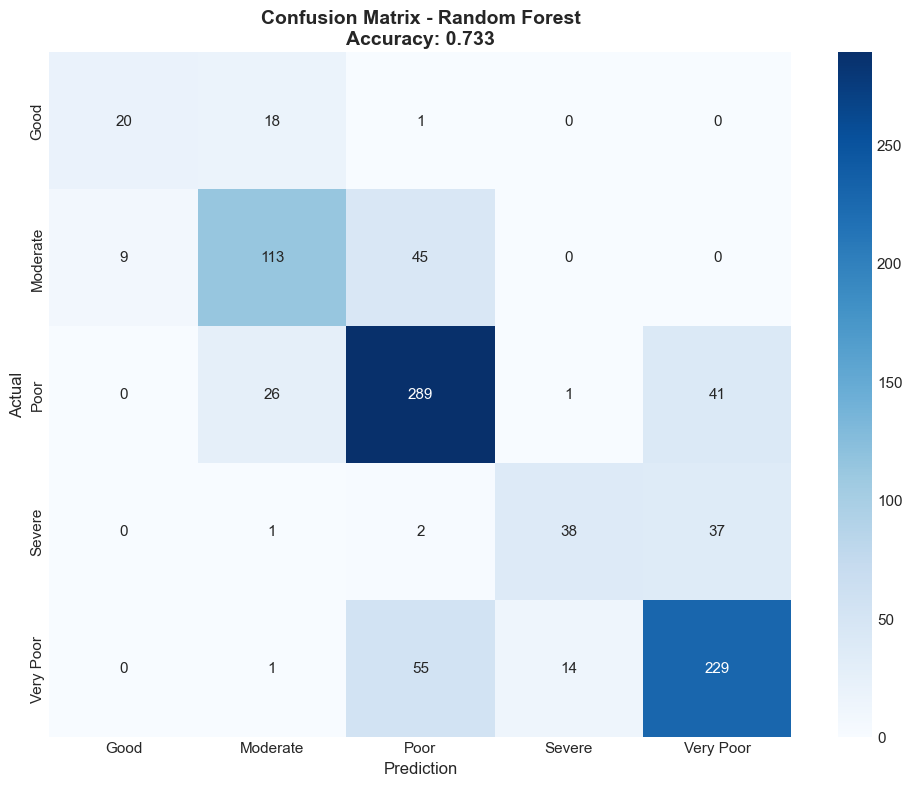

In [71]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    ax=ax
)

ax.set_title(f'Confusion Matrix - Random Forest\nAccuracy: {acc_rf:.3f}',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Prediction', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()



FEATURE IMPORTANCE (Top 10)
    1. PM25_lag1            : 0.2632 (26.3%)
    2. PM25_rolling7        : 0.2101 (21.0%)
    3. PM25_lag7            : 0.0974 (9.7%)
    4. NO2                  : 0.0960 (9.6%)
    5. NOx                  : 0.0875 (8.7%)
    6. NO2_rolling7         : 0.0735 (7.3%)
    7. day_of_year          : 0.0729 (7.3%)
    8. month                : 0.0250 (2.5%)
    9. day_of_week          : 0.0248 (2.5%)
   10. season               : 0.0155 (1.6%)


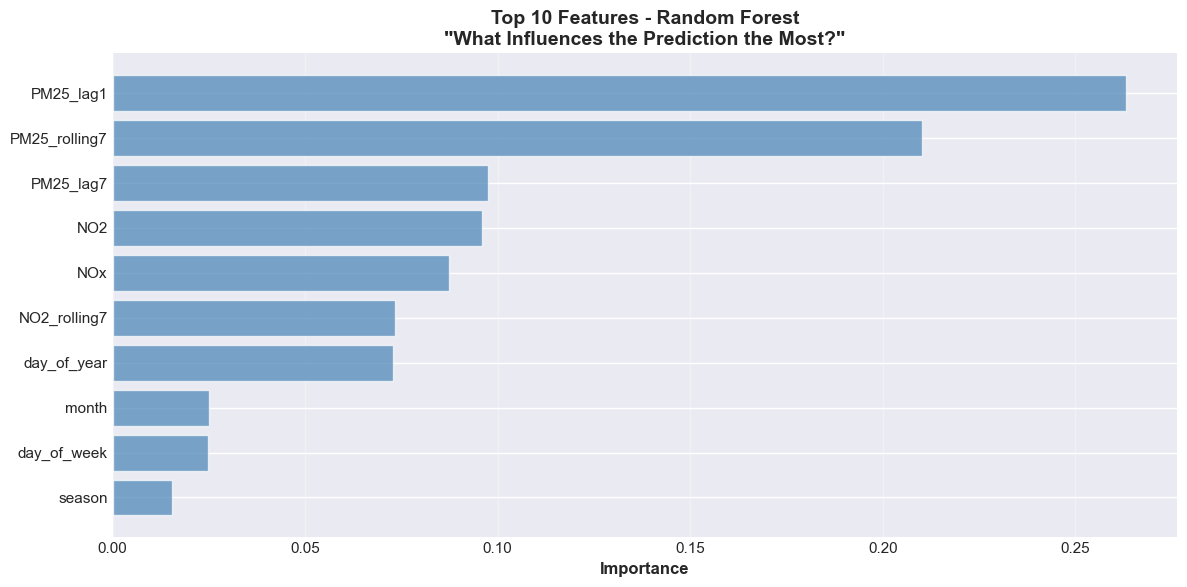

In [72]:
# Feature importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFEATURE IMPORTANCE (Top 10)")
print("="*70)
for i in range(min(10, len(indices))):
    idx = indices[i]
    print(f"   {i+1:>2}. {feature_cols[idx]:<20} : {importances[idx]:.4f} ({100*importances[idx]:.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
top_n = 10
top_indices = indices[:top_n]

ax.barh(range(top_n), importances[top_indices], color='steelblue', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_cols[i] for i in top_indices])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features - Random Forest\n"What Influences the Prediction the Most?"',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()


#### 6.1.2 SVM

In [73]:
# SVM with RBF kernel
print("\nSUPPORT VECTOR MACHINE (SVM)")
print("="*70)
print("Training in progress (may take 1–2 minutes)...")

svm_clf = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=42
)

svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)

# Accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nAccuracy: {acc_svm:.3f} ({100*acc_svm:.1f}%)")

# Classification report
print("\nCLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))



SUPPORT VECTOR MACHINE (SVM)
Training in progress (may take 1–2 minutes)...

Accuracy: 0.748 (74.8%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good       0.68      0.44      0.53        39
    Moderate       0.70      0.71      0.70       167
        Poor       0.74      0.83      0.78       357
      Severe       0.75      0.53      0.62        78
   Very Poor       0.79      0.77      0.78       299

    accuracy                           0.75       940
   macro avg       0.73      0.65      0.68       940
weighted avg       0.75      0.75      0.74       940



#### Comparison of the Models

In [74]:
print("\nMODEL COMPARISON")
print("="*70)
print(f"   Random Forest : {acc_rf:.3f} ({100*acc_rf:.1f}%)")
print(f"   SVM (RBF)     : {acc_svm:.3f} ({100*acc_svm:.1f}%)")

if acc_rf > acc_svm:
    print(f"\nWINNER: Random Forest (+{100*(acc_rf - acc_svm):.1f}%)")
else:
    print(f"\nWINNER: SVM (+{100*(acc_svm - acc_rf):.1f}%)")



MODEL COMPARISON
   Random Forest : 0.733 (73.3%)
   SVM (RBF)     : 0.748 (74.8%)

WINNER: SVM (+1.5%)


### 6.2 CLUSTERING - Identifier les Types de Jours

**Objectif** : Regrouper les jours selon leurs caractéristiques de pollution

**Basé sur Partie 3** :
- Hiver vs Été très différents (Ozone inverse)
- 93% jours toxiques en automne-hiver
- Patterns saisonniers dominants

In [75]:
# Features pour clustering
cluster_features = ['PM25', 'NO2', 'Ozone', 'NOx', 'month']
df_cluster = df_ml[cluster_features].dropna()

# Normalisation
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_cluster)


ELBOW METHOD - Searching for the optimal k
   k=2 : Inertia=16506.60, Silhouette=0.369
   k=3 : Inertia=13214.17, Silhouette=0.264
   k=4 : Inertia=11166.69, Silhouette=0.287
   k=5 : Inertia=9787.02, Silhouette=0.286
   k=6 : Inertia=8737.99, Silhouette=0.280
   k=7 : Inertia=8019.90, Silhouette=0.282
   k=8 : Inertia=7466.34, Silhouette=0.269
   k=9 : Inertia=6994.40, Silhouette=0.261
   k=10 : Inertia=6595.76, Silhouette=0.248


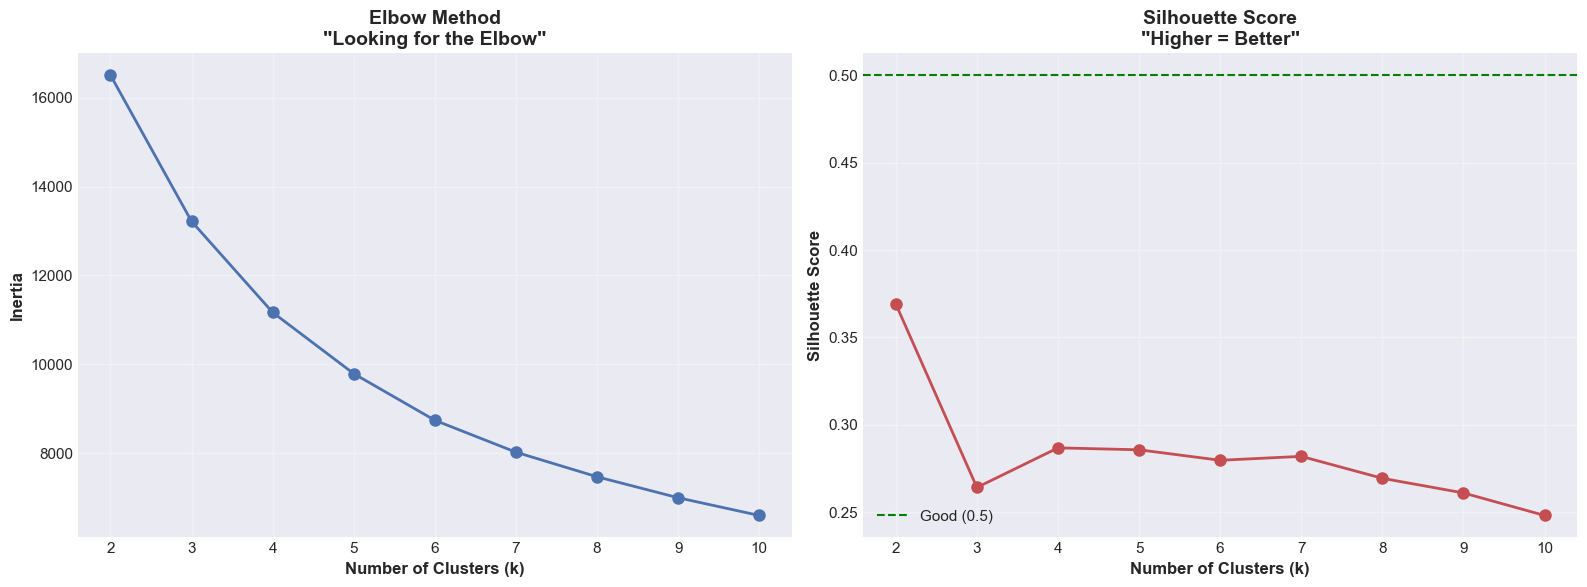


Optimal k (Silhouette): k=2 (score=0.369)


In [76]:
# Elbow method to find the optimal k
print("\nELBOW METHOD - Searching for the optimal k")
print("="*70)

inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_cluster, kmeans.labels_))
    print(f"   k={k} : Inertia={kmeans.inertia_:.2f}, Silhouette={silhouettes[-1]:.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method\n"Looking for the Elbow"', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score\n"Higher = Better"', fontsize=14, fontweight='bold')
axes[1].axhline(y=0.5, color='green', linestyle='--', label='Good (0.5)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best k
best_k_silhouette = K_range[np.argmax(silhouettes)]
print(f"\nOptimal k (Silhouette): k={best_k_silhouette} (score={max(silhouettes):.3f})")


In [77]:
# K-Means with optimal k
k_optimal = best_k_silhouette

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

# Add clusters to the dataframe
df_cluster['Cluster'] = clusters

# Silhouette score
sil_score = silhouette_score(X_cluster, clusters)

print("\nK-MEANS APPLIED")
print("="*70)
print(f"   Number of clusters : {k_optimal}")
print(f"   Silhouette score   : {sil_score:.3f}")
print("\n   Distribution:")
for i in range(k_optimal):
    count = (clusters == i).sum()
    pct = 100 * count / len(clusters)
    print(f"      Cluster {i} : {count:>5} days ({pct:>5.1f}%)")


K-MEANS APPLIED
   Number of clusters : 2
   Silhouette score   : 0.369

   Distribution:
      Cluster 0 :  3650 days ( 77.0%)
      Cluster 1 :  1089 days ( 23.0%)


In [78]:
# Cluster characterization
print("\nCLUSTER CHARACTERIZATION")
print("="*70)

for i in range(k_optimal):
    cluster_data = df_cluster[df_cluster['Cluster'] == i]
    print(f"\nCLUSTER {i} ({len(cluster_data)} days)")
    print("-" * 60)
    print(f"   PM2.5 : {cluster_data['PM25'].mean():.1f} ± {cluster_data['PM25'].std():.1f} µg/m³")
    print(f"   NO2   : {cluster_data['NO2'].mean():.1f} ± {cluster_data['NO2'].std():.1f} µg/m³")
    print(f"   Ozone : {cluster_data['Ozone'].mean():.1f} ± {cluster_data['Ozone'].std():.1f} µg/m³")
    print(f"   NOx   : {cluster_data['NOx'].mean():.1f} ± {cluster_data['NOx'].std():.1f} µg/m³")

    # Dominant months
    top_months = cluster_data['month'].value_counts().head(3)
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    print("   Main months: ", end="")
    print(", ".join([f"{month_names[m]} ({c})" for m, c in top_months.items()]))



CLUSTER CHARACTERIZATION

CLUSTER 0 (3650 days)
------------------------------------------------------------
   PM2.5 : 94.3 ± 52.0 µg/m³
   NO2   : 36.0 ± 13.6 µg/m³
   Ozone : 32.7 ± 13.4 µg/m³
   NOx   : 45.8 ± 20.3 µg/m³
   Main months: Mar (403), Aug (378), Sep (374)

CLUSTER 1 (1089 days)
------------------------------------------------------------
   PM2.5 : 220.8 ± 102.8 µg/m³
   NO2   : 77.3 ± 28.7 µg/m³
   Ozone : 31.8 ± 10.2 µg/m³
   NOx   : 109.8 ± 36.7 µg/m³
   Main months: Nov (290), Dec (286), Oct (169)


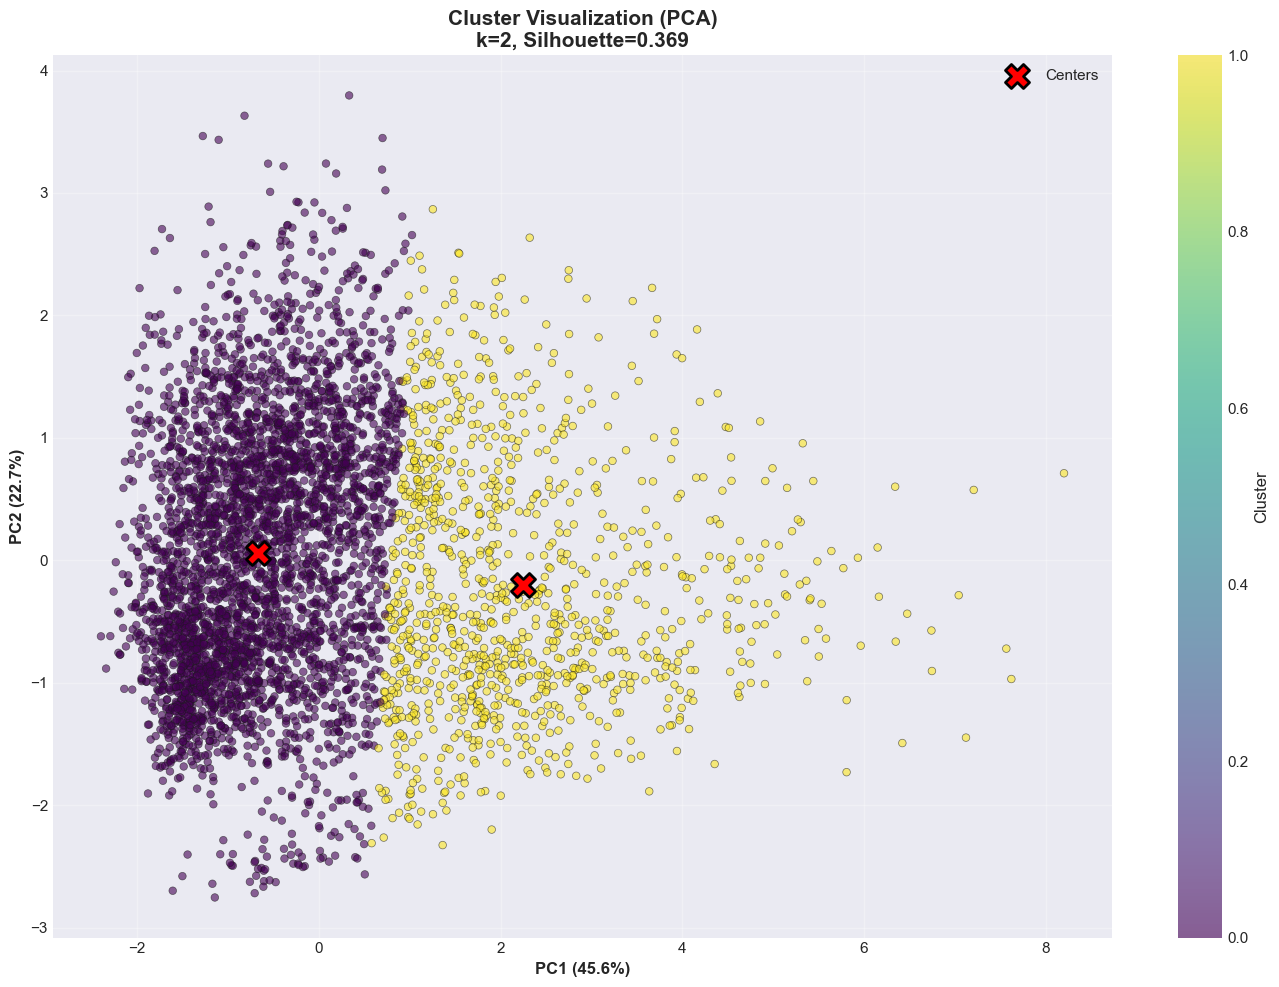


Explained variance by PCA:
   PC1: 45.6%
   PC2: 22.7%
   Total: 68.3%


In [79]:
# PCA 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.6,
    s=30,
    edgecolors='k',
    linewidth=0.5
)

# Cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Centers',
    zorder=10
)

ax.set_xlabel(f'PC1 ({100 * pca.explained_variance_ratio_[0]:.1f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({100 * pca.explained_variance_ratio_[1]:.1f}%)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Cluster Visualization (PCA)\nk={k_optimal}, Silhouette={sil_score:.3f}',
    fontsize=15,
    fontweight='bold'
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

print("\nExplained variance by PCA:")
print(f"   PC1: {100 * pca.explained_variance_ratio_[0]:.1f}%")
print(f"   PC2: {100 * pca.explained_variance_ratio_[1]:.1f}%")
print(f"   Total: {100 * sum(pca.explained_variance_ratio_):.1f}%")


### 6.3 ARIMA / SARIMA

**Objectif** : Prédire PM2.5 30-60 jours à l'avance

**Basé sur Partie 2** :
- Saisonnalité annuelle dominante (s=365)
- ACF/PACF suggèrent AR(1-2)
- Série stationnaire (d=1 suffisant)

**Modèle suggéré** : SARIMA(1,1,1)(1,1,1)[365]

In [80]:
# Prepare data for ARIMA
ts = df_daily['PM25'].dropna()

# Time-based train/test split
train_size = int(0.8 * len(ts))
train = ts[:train_size]
test = ts[train_size:]

print("\nTIME SERIES SPLIT")
print("="*70)
print(f"   Train: {len(train)} days ({train.index.min().date()} to {train.index.max().date()})")
print(f"   Test : {len(test)} days ({test.index.min().date()} to {test.index.max().date()})")


TIME SERIES SPLIT
   Train: 3791 days (2010-02-17 to 2020-08-25)
   Test : 948 days (2020-08-26 to 2023-03-31)


In [81]:
configurations = [
    {
        'name': 'SARIMA(1,1,1)(1,1,1)[7] - Weekly',
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 7),
        'maxiter': 100,
        'method': 'lbfgs',
        'description': 'Weekly seasonality, full SARIMA'
    },
    {
        'name': 'SARIMA(1,1,1)(1,0,1)[7] - Weekly No Diff',
        'order': (1, 1, 1),
        'seasonal_order': (1, 0, 1, 7),
        'maxiter': 50,
        'method': 'lbfgs',
        'description': 'Weekly, no seasonal differencing'
    },
    {
        'name': 'SARIMA(1,1,1)(1,1,1)[30] - Monthly',
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 30),
        'maxiter': 100,
        'method': 'lbfgs',
        'description': 'Monthly seasonality, full SARIMA'
    },
    {
        'name': 'SARIMA(1,1,1)(1,0,1)[30] - Monthly No Diff',
        'order': (1, 1, 1),
        'seasonal_order': (1, 0, 1, 30),
        'maxiter': 100,
        'method': 'lbfgs',
        'description': 'Monthly, no seasonal differencing'
    },
    {
        'name': 'SARIMA(2,1,1)(1,1,1)[7] - AR(2) Weekly',
        'order': (2, 1, 1),
        'seasonal_order': (1, 1, 1, 7),
        'maxiter': 100,
        'method': 'lbfgs',
        'description': 'AR(2) with weekly seasonality'
    },
    {
        'name': 'SARIMA(1,1,2)(1,1,1)[7] - MA(2) Weekly',
        'order': (1, 1, 2),
        'seasonal_order': (1, 1, 1, 7),
        'maxiter': 100,
        'method': 'lbfgs',
        'description': 'MA(2) with weekly seasonality'
    },
    {
        'name': 'SARIMA(2,1,0)(1,0,1)[30] - AR(2) Monthly',
        'order': (2, 1, 0),
        'seasonal_order': (1, 0, 1, 30),
        'maxiter': 100,
        'method': 'lbfgs',
        'description': 'AR(2) with monthly seasonality'
    },
]

print(f"{len(configurations)} configurations defined:")
for i, config in enumerate(configurations, 1):
    print(f"   {i}. {config['name']}")

7 configurations defined:
   1. SARIMA(1,1,1)(1,1,1)[7] - Weekly
   2. SARIMA(1,1,1)(1,0,1)[7] - Weekly No Diff
   3. SARIMA(1,1,1)(1,1,1)[30] - Monthly
   4. SARIMA(1,1,1)(1,0,1)[30] - Monthly No Diff
   5. SARIMA(2,1,1)(1,1,1)[7] - AR(2) Weekly
   6. SARIMA(1,1,2)(1,1,1)[7] - MA(2) Weekly
   7. SARIMA(2,1,0)(1,0,1)[30] - AR(2) Monthly


In [ ]:
import time
def benchmark_sarima(train, test, config, index, total):
    """
    Train and evaluate a SARIMA model.
    
    Parameters:
    -----------
    train : pd.Series
        Training data
    test : pd.Series
        Test data
    config : dict
        Model configuration
    index : int
        Current model index
    total : int
        Total number of models
    
    Returns:
    --------
    dict : Results with metrics and timings
    """
    name = config['name']
    
    print(f"\n{'='*70}")
    print(f"[{index}/{total}] Testing: {name}")
    print(f"{'='*70}")
    print(f"   Order          : {config['order']}")
    print(f"   Seasonal Order : {config['seasonal_order']}")
    print(f"   Max Iterations : {config['maxiter']}")
    print(f"   Method         : {config['method']}")
    
    results = {
        'name': name,
        'config': config,
        'success': False
    }
    
    try:
        # Timer start
        start_time = time.time()
        
        # Create model
        model = SARIMAX(
            train,
            order=config['order'],
            seasonal_order=config['seasonal_order'],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        # Fit model
        print("   Fitting model...")
        fitted = model.fit(
            disp=False,
            maxiter=config['maxiter'],
            method=config['method']
        )
        
        # Timer end
        elapsed_time = time.time() - start_time
        
        # Forecast
        print("   Generating forecast...")
        forecast = fitted.forecast(steps=len(test))
        
        # Metrics
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        aic = fitted.aic
        bic = fitted.bic
        
        # Store results
        results.update({
            'success': True,
            'time': elapsed_time,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'aic': aic,
            'bic': bic,
            'forecast': forecast,
            'fitted_model': fitted
        })
        
        print(f"   SUCCESS in {elapsed_time:.1f}s")
        print(f"   RMSE : {rmse:.2f} ug/m3")
        print(f"   MAE  : {mae:.2f} ug/m3")
        print(f"   MAPE : {mape:.2f}%")
        print(f"   AIC  : {aic:.2f}")
        print(f"   BIC  : {bic:.2f}")
        
    except Exception as e:
        elapsed_time = time.time() - start_time
        results.update({
            'success': False,
            'time': elapsed_time,
            'error': str(e)
        })
        print(f"   FAILED after {elapsed_time:.1f}s")
        print(f"   Error: {str(e)[:100]}")
    
    return results


Benchmark function defined.


In [83]:
print("="*80)
print("RUNNING BENCHMARK")
print("="*80)
print("Estimated time: 3-8 minutes")
print("Please wait...\n")

all_results = []

for i, config in enumerate(configurations, 1):
    result = benchmark_sarima(train, test, config, i, len(configurations))
    all_results.append(result)
    
    # Progress bar
    progress = 100 * i / len(configurations)
    bar_length = int(progress / 5)
    print(f"\n{'#' * bar_length}{'-' * (20-bar_length)} {progress:.0f}%")
    
    # Display current best
    if result['success']:
        successful_so_far = [r for r in all_results if r['success']]
        if successful_so_far:
            current_best_rmse = min([r['rmse'] for r in successful_so_far])
            print(f"Current best RMSE: {current_best_rmse:.2f} ug/m3")

print("\n" + "="*80)
print("BENCHMARK COMPLETED")
print("="*80)

RUNNING BENCHMARK
Estimated time: 3-8 minutes
Please wait...


[1/7] Testing: SARIMA(1,1,1)(1,1,1)[7] - Weekly
   Order          : (1, 1, 1)
   Seasonal Order : (1, 1, 1, 7)
   Max Iterations : 100
   Method         : lbfgs
   Fitting model...
   Generating forecast...
   SUCCESS in 6.2s
   RMSE : 123.60 ug/m3
   MAE  : 96.57 ug/m3
   MAPE : nan%
   AIC  : 40024.19
   BIC  : 40055.37

##------------------ 14%
Current best RMSE: 123.60 ug/m3

[2/7] Testing: SARIMA(1,1,1)(1,0,1)[7] - Weekly No Diff
   Order          : (1, 1, 1)
   Seasonal Order : (1, 0, 1, 7)
   Max Iterations : 50
   Method         : lbfgs
   Fitting model...
   Generating forecast...
   SUCCESS in 2.1s
   RMSE : 115.32 ug/m3
   MAE  : 85.93 ug/m3
   MAPE : nan%
   AIC  : 40057.33
   BIC  : 40088.51

#####--------------- 29%
Current best RMSE: 115.32 ug/m3

[3/7] Testing: SARIMA(1,1,1)(1,1,1)[30] - Monthly
   Order          : (1, 1, 1)
   Seasonal Order : (1, 1, 1, 30)
   Max Iterations : 100
   Method         : lbfgs


In [84]:
# Filter successful and failed results
successful_results = [r for r in all_results if r['success']]
failed_results = [r for r in all_results if not r['success']]

print(f"Successful models : {len(successful_results)}/{len(all_results)}")
if failed_results:
    print(f"Failed models     : {len(failed_results)}")
    for result in failed_results:
        print(f"   - {result['name']}")

# Create comparison DataFrame
if successful_results:
    comparison_df = pd.DataFrame([{
        'Model': r['name'],
        'Time (s)': r['time'],
        'RMSE': r['rmse'],
        'MAE': r['mae'],
        'MAPE (%)': r['mape'],
        'AIC': r['aic'],
        'BIC': r['bic']
    } for r in successful_results])
    
    # Sort by RMSE (lower is better)
    comparison_df = comparison_df.sort_values('RMSE').reset_index(drop=True)
    
    print("\n" + "="*80)
    print("RANKING BY RMSE (Lower is Better)")
    print("="*80)
    print(comparison_df.to_string(index=False))
else:
    print("\nNo successful models. Please check your data and configurations.")

Successful models : 7/7

RANKING BY RMSE (Lower is Better)
                                     Model  Time (s)       RMSE       MAE  MAPE (%)          AIC          BIC
SARIMA(1,1,1)(1,0,1)[30] - Monthly No Diff  8.721718 115.186343 85.761118       NaN 39813.591114 39844.749325
  SARIMA(1,1,1)(1,0,1)[7] - Weekly No Diff  2.050488 115.322709 85.931845       NaN 40057.325678 40088.514397
  SARIMA(2,1,0)(1,0,1)[30] - AR(2) Monthly  6.782253 119.660686 91.403240       NaN 40051.062708 40082.220919
        SARIMA(1,1,1)(1,1,1)[30] - Monthly 76.018065 122.862662 95.467459       NaN 39632.002620 39663.120755
          SARIMA(1,1,1)(1,1,1)[7] - Weekly  6.249202 123.598442 96.570380       NaN 40024.193840 40055.373293
    SARIMA(2,1,1)(1,1,1)[7] - AR(2) Weekly 12.177620 125.161791 98.542674       NaN 39941.875149 39979.290493
    SARIMA(1,1,2)(1,1,1)[7] - MA(2) Weekly  7.597192 125.314417 98.732798       NaN 39914.768424 39952.182178


In [85]:
if successful_results:
    # Get best model (lowest RMSE)
    best_idx = comparison_df['RMSE'].idxmin()
    best_model = successful_results[best_idx]
    
    print("\n" + "="*80)
    print("BEST MODEL")
    print("="*80)
    print(f"   Name : {best_model['name']}")
    print(f"   RMSE : {best_model['rmse']:.2f} ug/m3")
    print(f"   MAE  : {best_model['mae']:.2f} ug/m3")
    print(f"   MAPE : {best_model['mape']:.2f}%")
    print(f"   AIC  : {best_model['aic']:.2f}")
    print(f"   BIC  : {best_model['bic']:.2f}")
    print(f"   Time : {best_model['time']:.1f}s ({best_model['time']/60:.1f} min)")


BEST MODEL
   Name : SARIMA(1,1,1)(1,1,1)[7] - Weekly
   RMSE : 123.60 ug/m3
   MAE  : 96.57 ug/m3
   MAPE : nan%
   AIC  : 40024.19
   BIC  : 40055.37
   Time : 6.2s (0.1 min)


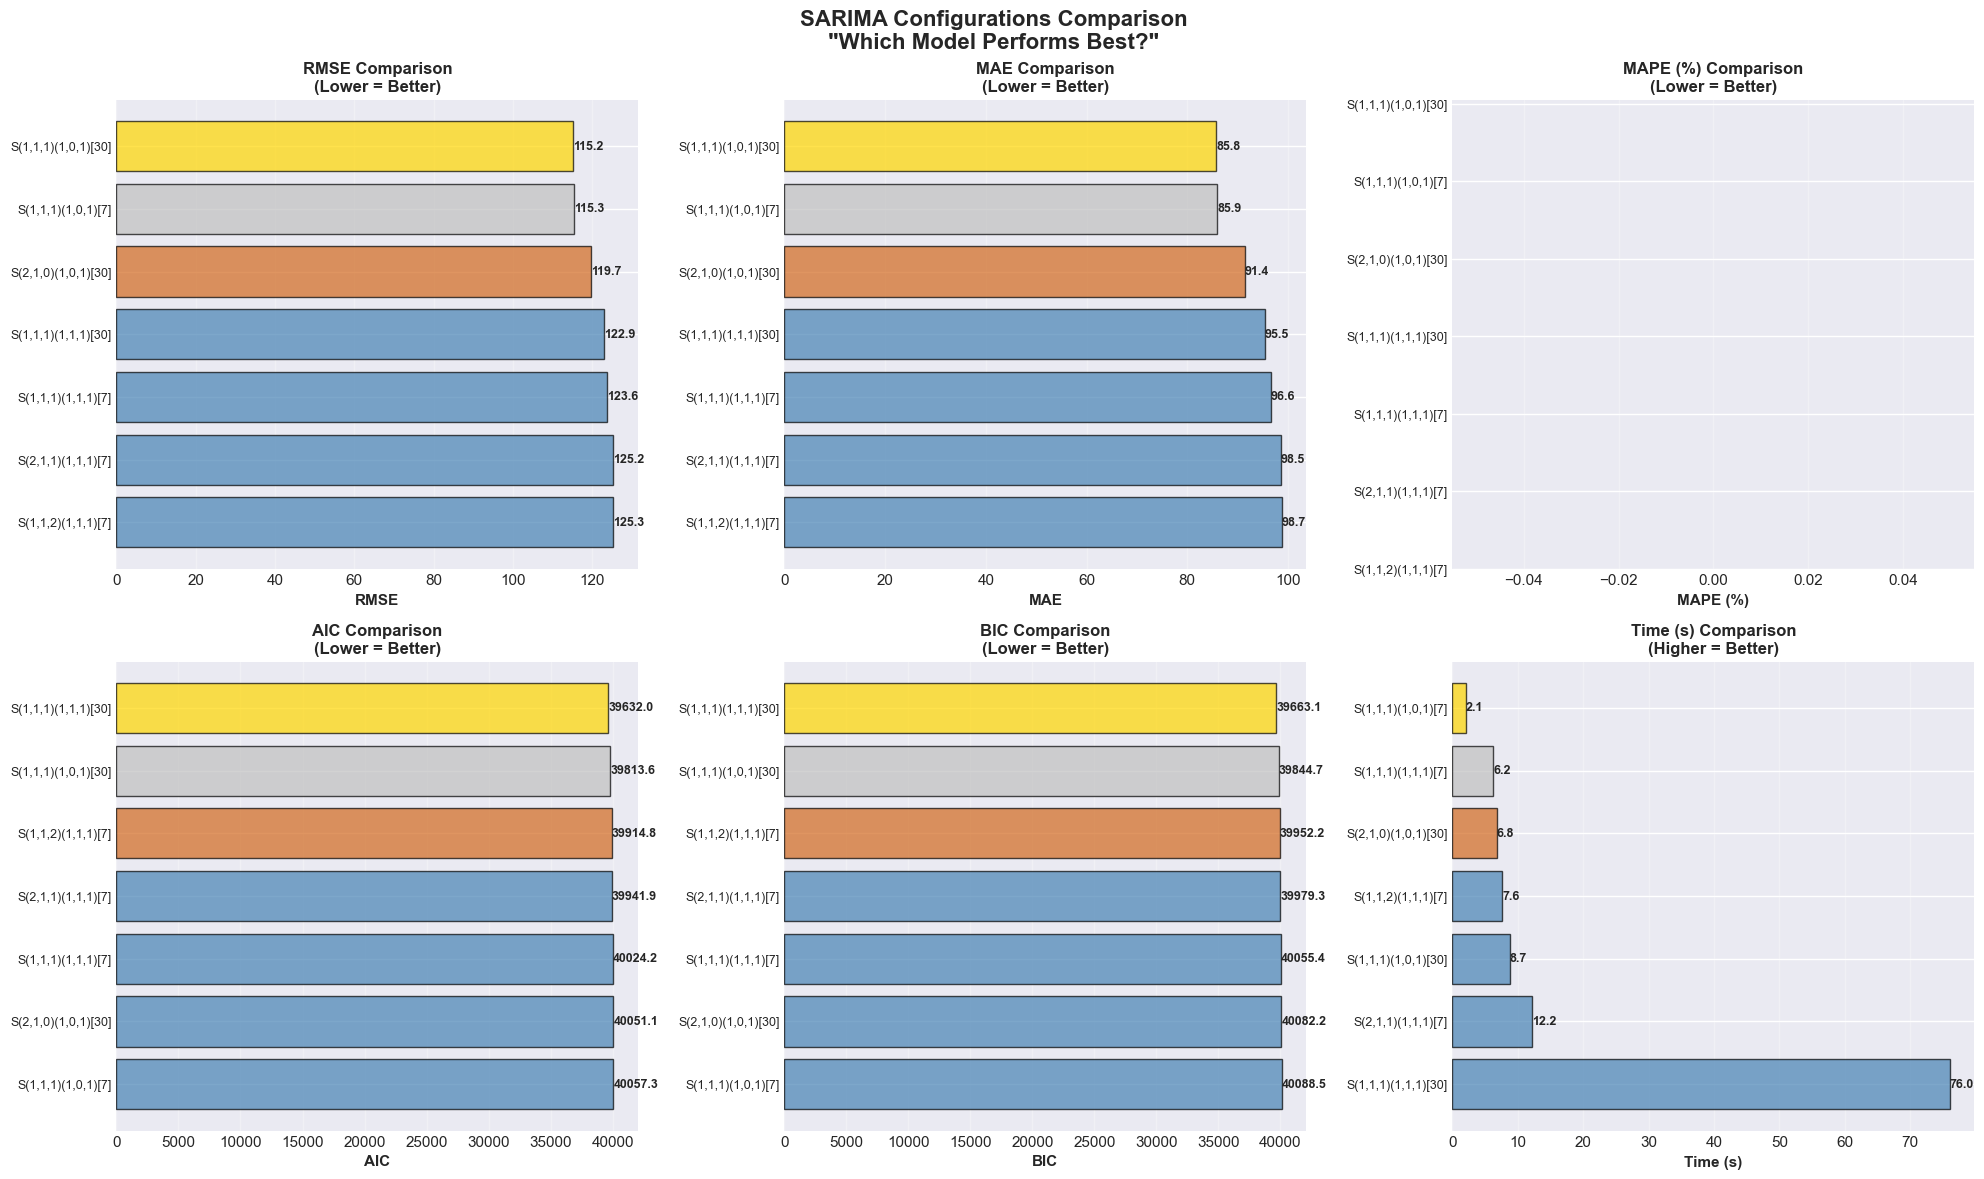

In [86]:
if successful_results:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    metrics = ['RMSE', 'MAE', 'MAPE (%)', 'AIC', 'BIC', 'Time (s)']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        
        # Data sorted by metric
        data = comparison_df.sort_values(metric)
        
        # Colors: gold for 1st, silver for 2nd, bronze for 3rd
        colors = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 
                  else 'steelblue' for i in range(len(data))]
        
        # Bar plot
        bars = ax.barh(range(len(data)), data[metric], color=colors, 
                      alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(data)))
        ax.set_yticklabels([name.split(' - ')[0].replace('SARIMA', 'S') 
                           for name in data['Model']], fontsize=9)
        ax.set_xlabel(metric, fontsize=11, fontweight='bold')
        ax.set_title(f'{metric} Comparison\n' + 
                    f"({'Lower' if metric in ['RMSE', 'MAE', 'MAPE (%)', 'AIC', 'BIC'] else 'Higher'} = Better)", 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.invert_yaxis()
        
        # Value annotations
        for i, (bar, val) in enumerate(zip(bars, data[metric])):
            ax.text(val, bar.get_y() + bar.get_height()/2, 
                   f'{val:.1f}', ha='left', va='center', 
                   fontsize=9, fontweight='bold')
    
    plt.suptitle('SARIMA Configurations Comparison\n"Which Model Performs Best?"', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

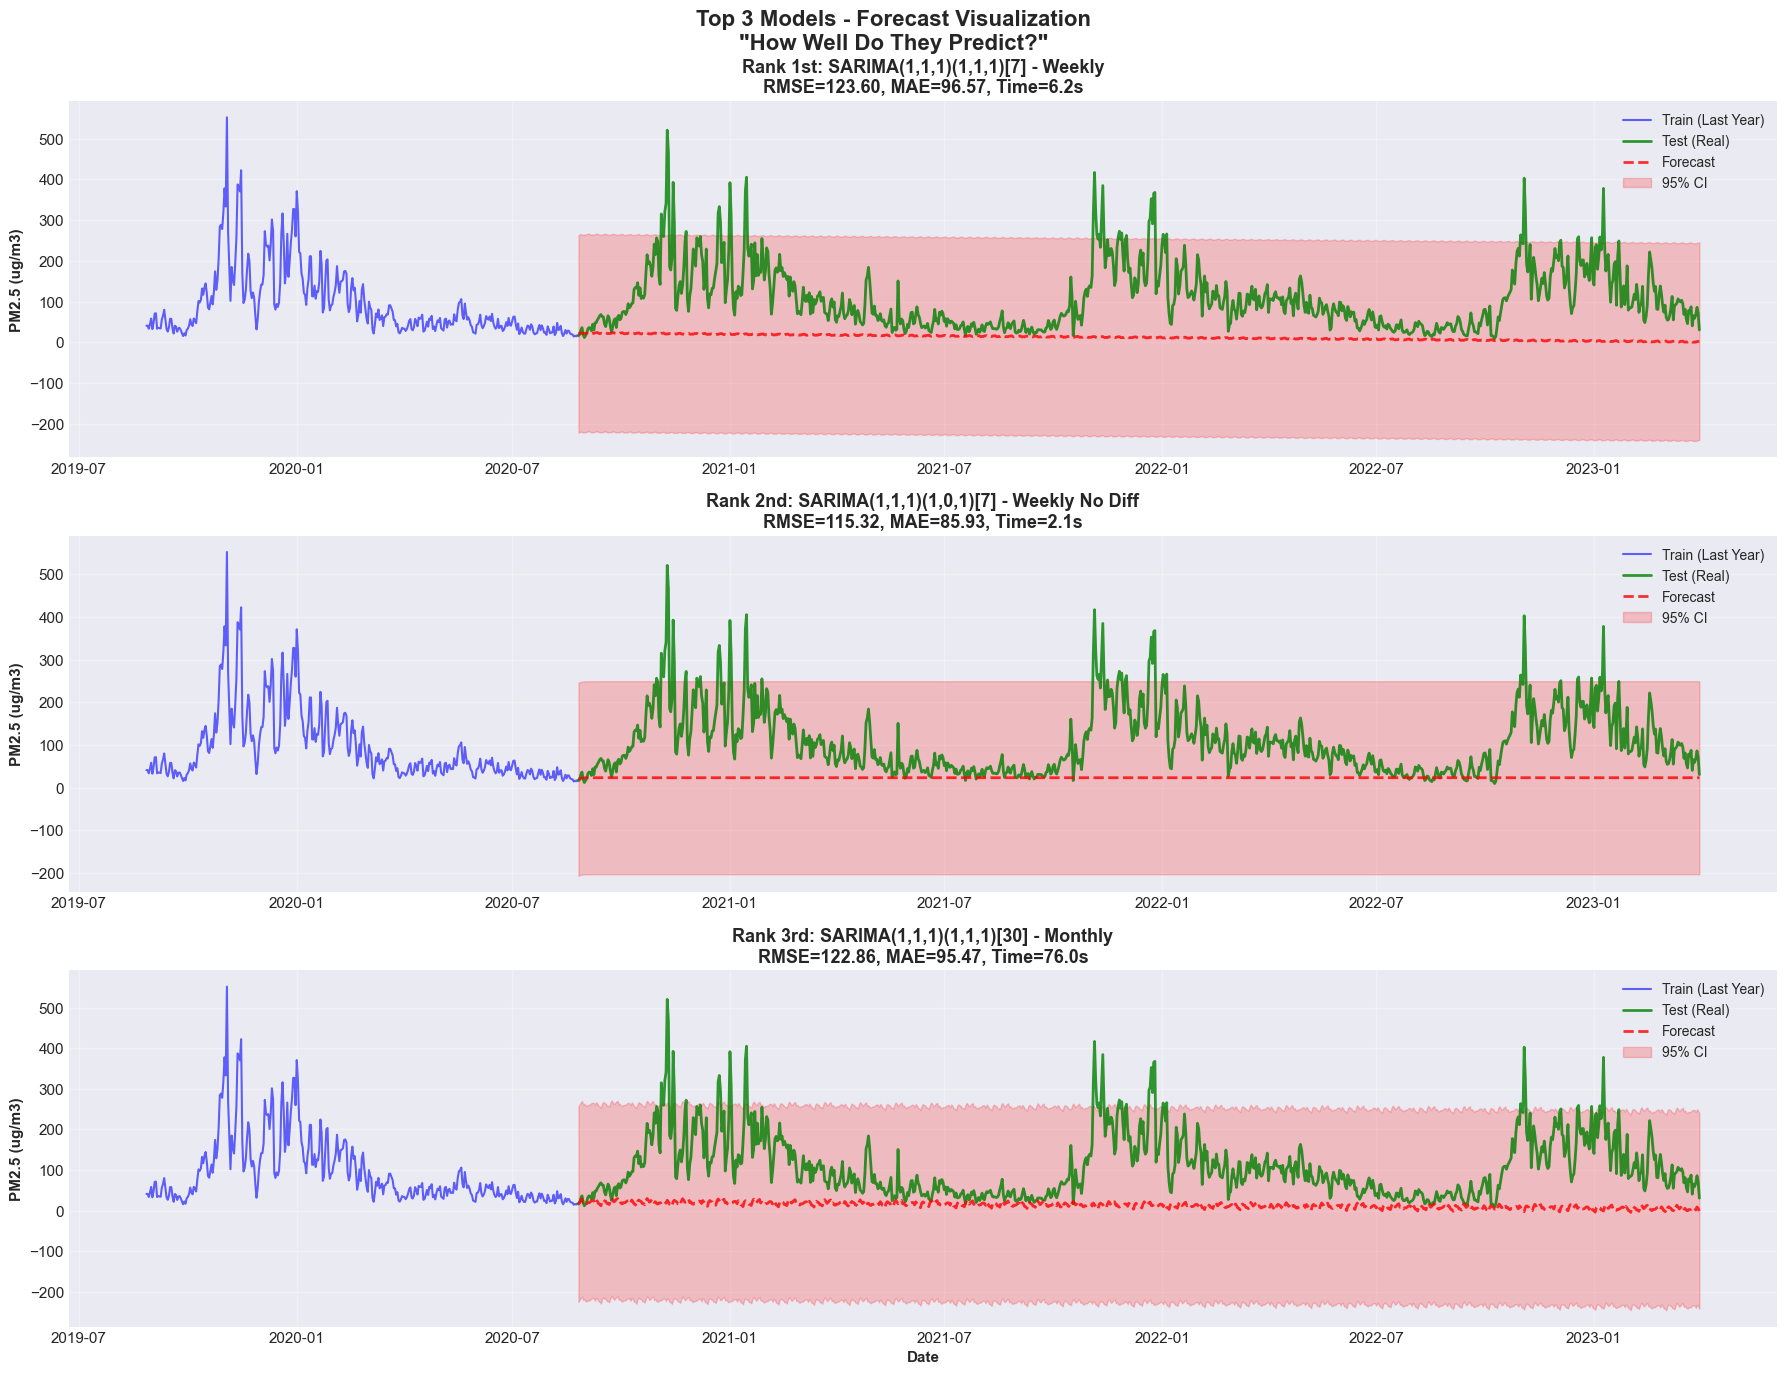

In [87]:
if successful_results and len(successful_results) >= 3:
    # Get top 3 models by RMSE
    top_3_indices = comparison_df.nsmallest(3, 'RMSE').index
    top_3 = [successful_results[i] for i in top_3_indices]
    
    fig, axes = plt.subplots(3, 1, figsize=(18, 14))
    
    for idx, result in enumerate(top_3):
        ax = axes[idx]
        
        # Plot train (last year only for clarity)
        ax.plot(train.index[-365:], train.values[-365:], 
               label='Train (Last Year)', color='blue', linewidth=1.5, alpha=0.6)
        
        # Plot test (real values)
        ax.plot(test.index, test.values, 
               label='Test (Real)', color='green', linewidth=2, alpha=0.8)
        
        # Plot forecast
        ax.plot(test.index, result['forecast'], 
               label='Forecast', color='red', linewidth=2, linestyle='--', alpha=0.8)
        
        # Confidence interval (95%)
        rmse = result['rmse']
        ax.fill_between(test.index, 
                       result['forecast'] - 1.96*rmse, 
                       result['forecast'] + 1.96*rmse,
                       color='red', alpha=0.2, label='95% CI')
        
        # Title with metrics
        rank_label = ['1st', '2nd', '3rd'][idx]
        ax.set_title(f"Rank {rank_label}: {result['name']}\n" +
                    f"RMSE={result['rmse']:.2f}, MAE={result['mae']:.2f}, " +
                    f"Time={result['time']:.1f}s",
                    fontsize=13, fontweight='bold')
        ax.set_ylabel('PM2.5 (ug/m3)', fontsize=11, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Date', fontsize=11, fontweight='bold')
    plt.suptitle('Top 3 Models - Forecast Visualization\n"How Well Do They Predict?"', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 6.4 Random Forest Regressor

In [90]:
# Préparer les données pour régression
df_reg = df_ml[feature_cols + ['PM25']].dropna()

X_reg = df_reg[feature_cols]
y_reg = df_reg['PM25']

# Train/Test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [91]:
# Random Forest Regressor
print("\nRANDOM FOREST REGRESSOR")
print("=" * 70)

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = rf_reg.predict(X_test_reg)

# Performance metrics
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
mae_rf = mean_absolute_error(y_test_reg, y_pred_reg)
r2_rf = r2_score(y_test_reg, y_pred_reg)

print("\nRANDOM FOREST PERFORMANCE")
print("=" * 70)
print(f"RMSE: {rmse_rf:.2f} μg/m³")
print(f"MAE : {mae_rf:.2f} μg/m³")
print(f"R²  : {r2_rf:.3f}")



RANDOM FOREST REGRESSOR

RANDOM FOREST PERFORMANCE
RMSE: 44.85 μg/m³
MAE : 23.91 μg/m³
R²  : 0.724


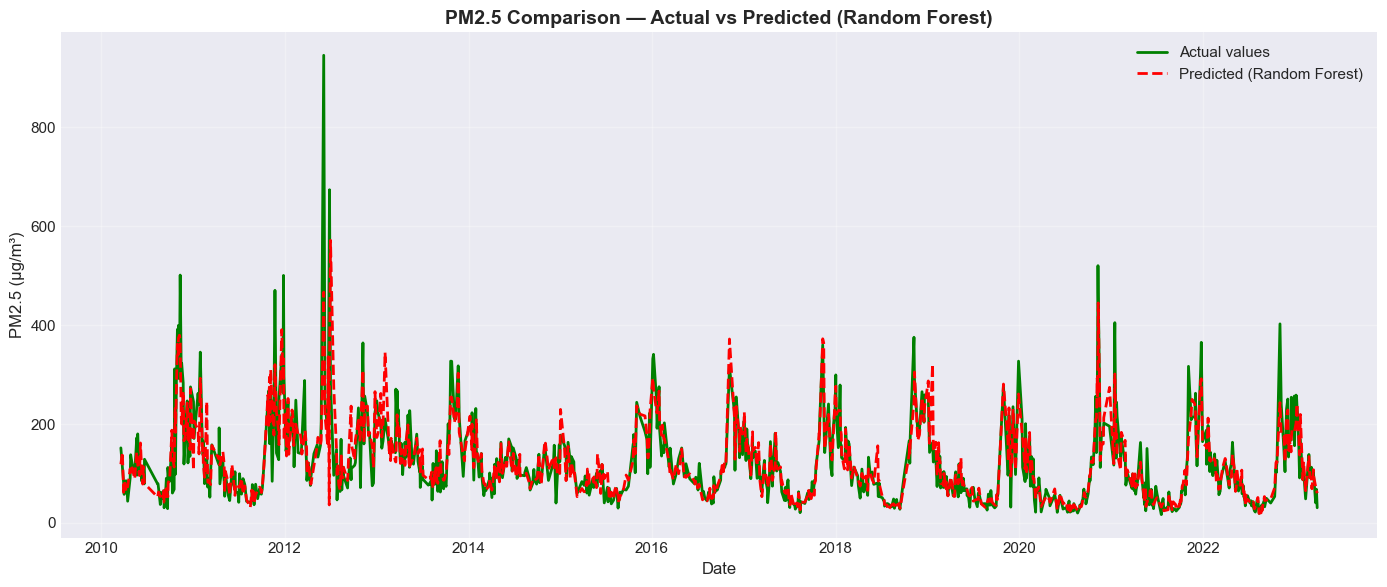

In [92]:
df_test = X_test_reg.copy()
df_test['PM25_real'] = y_test_reg
df_test['PM25_pred'] = y_pred_reg

# The timestamp is in the index:
df_test = df_test.sort_index()

# --- Visualization: Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, df_test['PM25_real'], label='Actual values', color='green', linewidth=2)
plt.plot(df_test.index, df_test['PM25_pred'], label='Predicted (Random Forest)', color='red', linestyle='--', linewidth=2)
plt.title('PM2.5 Comparison — Actual vs Predicted (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 (μg/m³)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## SARIMA 365


TIME SERIES SPLIT (last 2 years)
Train: 584 days (2021-03-31 -> 2022-11-04)
Test : 147 days (2022-11-05 -> 2023-03-31)

Fitting SARIMA(1,1,1)(1,1,1)[365] on the last 2 years...

SARIMA(1,1,1)(1,1,1)[365] PERFORMANCE (last 2 years)
RMSE: 132.69 μg/m³
MAE : 115.74 μg/m³
MAPE: 107.78%
AIC : 10.00
BIC : nan


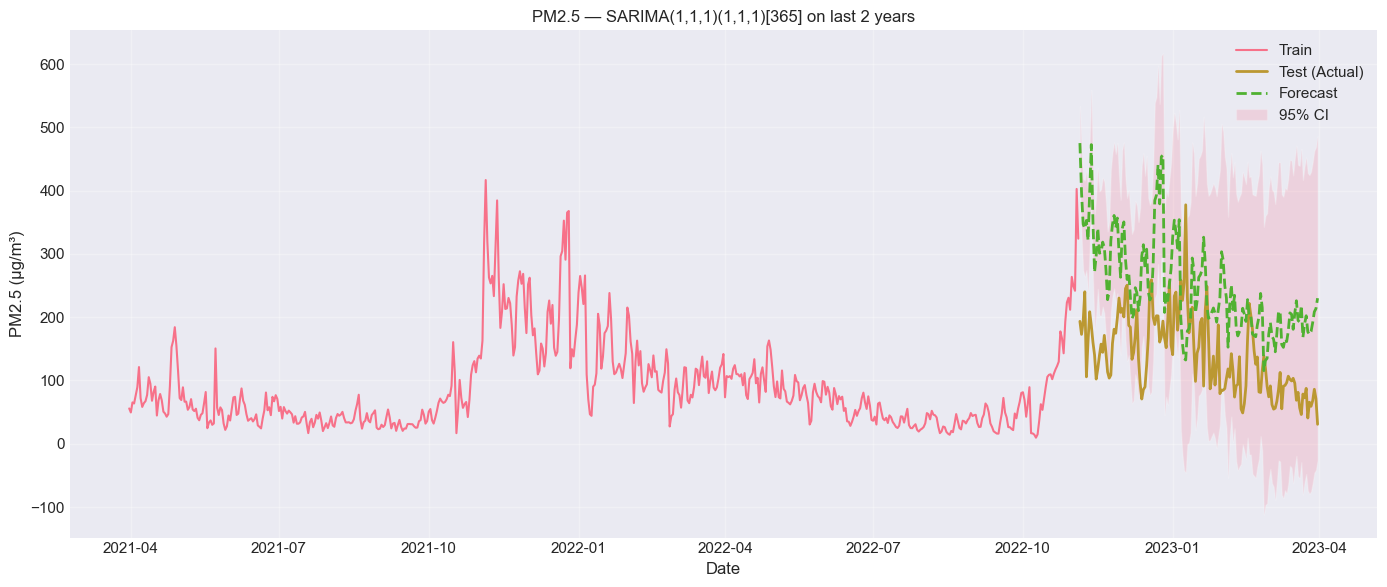

In [93]:
# --- 1) Prepare daily series and restrict to last 2 years ---
# Assumes df_daily has a DatetimeIndex and a 'PM25' column at daily frequency.
ts = df_daily['PM25'].dropna().sort_index()

# Keep only the most recent 2 years
cutoff = ts.index.max() - pd.DateOffset(years=2)
ts_2y = ts.loc[ts.index >= cutoff]

# --- 2) Time-based train/test split (e.g., 80/20 within the 2-year window) ---
train_size = int(0.8 * len(ts_2y))
train = ts_2y.iloc[:train_size]
test  = ts_2y.iloc[train_size:]

print("\nTIME SERIES SPLIT (last 2 years)")
print("="*70)
print(f"Train: {len(train)} days ({train.index.min().date()} -> {train.index.max().date()})")
print(f"Test : {len(test)} days ({test.index.min().date()} -> {test.index.max().date()})")

# --- 3) Single SARIMA with yearly seasonality s=365 ---
# You can adjust orders if convergence is slow; s=365 is heavy.
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 365)

model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

print("\nFitting SARIMA(1,1,1)(1,1,1)[365] on the last 2 years...")
res = model.fit(method="lbfgs", maxiter=200, disp=False)

# --- 4) Forecast on the holdout period ---
n_steps = len(test)
fc_res = res.get_forecast(steps=n_steps)
forecast = pd.Series(fc_res.predicted_mean, index=test.index)
conf_int = fc_res.conf_int(alpha=0.05)  # 95% CI
lower = conf_int.iloc[:, 0].rename("lower")
upper = conf_int.iloc[:, 1].rename("upper")

# --- 5) Metrics ---
rmse = np.sqrt(mean_squared_error(test, forecast))
mae  = mean_absolute_error(test, forecast)
mape = (np.abs((test - forecast) / test).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100)

print("\nSARIMA(1,1,1)(1,1,1)[365] PERFORMANCE (last 2 years)")
print("="*70)
print(f"RMSE: {rmse:.2f} μg/m³")
print(f"MAE : {mae:.2f} μg/m³")
print(f"MAPE: {mape:.2f}%")
print(f"AIC : {res.aic:.2f}")
print(f"BIC : {res.bic:.2f}")

# --- 6) Plot actual vs forecast with 95% CI ---
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label="Train", linewidth=1.5)
plt.plot(test.index,  test,  label="Test (Actual)", linewidth=2)
plt.plot(forecast.index, forecast, label="Forecast", linestyle="--", linewidth=2)
plt.fill_between(forecast.index, lower, upper, alpha=0.2, label="95% CI")
plt.title("PM2.5 — SARIMA(1,1,1)(1,1,1)[365] on last 2 years")
plt.xlabel("Date")
plt.ylabel("PM2.5 (μg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
